# Lab 2: Comparing Means
## w203 Statistics for Data Science

#### Student Names: Blake Allen, Sam Shih, Mike Fan
#### Section: 1

In [3]:
library(plyr)
library(dplyr)
library(ggplot2)
library(summarytools)
library(coin)
library(effsize)
library(tidyverse)
library(lsr)
library(corrplot)
library(rstatix)
library(BSDA)
library(cowplot)
library(ggrepel)

In [222]:
A = read.csv("anes_pilot_2018.csv")
sprintf("ANES pilot 2018 dataset has %s rows and %s columns", nrow(A), ncol(A))

[1] "ANES pilot 2018 dataset has 2500 rows and 767 columns"

# Research Questions

## Question 1: Do US voters have more respect for the police or for journalists?

We would like to evaluate if there are significant differences in the respect measure between the groups polics and journalists.

We are interested in registered voters, we can use the **reg** variable ("Are you registered to vote, or not?") to determine if the survey respondent was a registered voter or not.

Second, there are 2 questions in the survey that prompted particpants to gauge their rating of both the police and journalists based on a likert scale of 0 to 100. The resulting variables are:
 - **ftpolice**: "How would you rate the police?"
 - **ftjournal**: "How would rate journalists?"

Below is an image of the Widget UI used to collect these variables.
<img width=400 src="thermometer.png"></img>

### Perform an exploratory data analysis (EDA) of the relevant variables. (5 points)

In [223]:
#Step 0: Make a copy of the original dataframe for further manipulation
A1 = data.frame(A)

#Step 1: Check to see that all of ftpolice's values are bound between 0 and 100.
ftp = A1$ftpolice

#remove any rows with values outside of our range (0 - 100)
ftp[ftp == -7] = NA
ftp[ftp == -1] = NA

#perform sanity check that all values are within range
stopifnot(max(ftp) <= 100) #check max value
stopifnot(min(ftp) >= 0) #check min value

#Step 2: Check to see that all of ftjournal's values are bound between 0 and 100.
ftj = A1$ftjournal

#remove -7 or -1 values
ftj[ftj == -7] = NA
ftj[ftj == -1] = NA

#get min / max, ignore NA's
max_ftj <- max(ftj, na.rm = TRUE)
min_ftj <- min(ftj, na.rm = TRUE)

stopifnot(max_ftj <= 100) #check for max value
stopifnot(min_ftj >= 0) #checks for min value

#Step 3: Filter out non-registered voters from both the ftp and ftj vectors. 
#Thus, we only keep respondents with a "1" or "2" to the reg variable
A1 = A1 %>% filter(reg %in% as.numeric(1:2)) #new table with reg == 1|2
A1$ftjournal[A1$ftjournal == -7] = NA

#Step 4: create a data frame for both police and journalist and then combine in order to draw a combined histogram
dfp = data.frame(score = A1$ftpolice)
dfj = data.frame(score = A1$ftjournal)

dfp$category = "Police"
dfj$category = "Journalists"

dfc = rbind(dfp, dfj) #combined dataframe

#Step 4.1: Calculate the mean rating for journalists and police that will be used in our visual inspection via the histogram and density plot
mu = ddply(dfc, "category", summarize, grp.mean = mean(score, na.rm = TRUE), sd = sd(score, na.rm = TRUE), grp.count = n())

j_mean = mu[1,2]
p_mean = mu[2,2]

#Step 5: Overlay histogram of both occupation groups to visualize differences in rating distribution
options(repr.plot.width = 22, repr.plot.height = 15)
plot_theme =  theme(plot.title = element_text(size = 20, hjust = .5, face = "bold"), axis.text = element_text(size = 14), axis.title = element_text(size = 16), 
                    legend.title = element_text(size = 16), legend.text=element_text(size = 14), legend.position = "top", 
                    strip.text.y = element_text(size = 16, color = "black", angle = 90))

histo = ggplot(dfc, aes(score, fill = category, color = category)) + 
    geom_histogram(position = "identity", alpha = .5, bins = 30) +
    geom_vline(data = mu, aes(xintercept = grp.mean, color = category), linetype = "dashed", size = 1) +
    annotate(geom = "text", x = j_mean-5, y = 200, label = paste("Mean:", round(j_mean, 0)), color = "#F8766D", size = 7) +
    annotate(geom = "text", x = p_mean + 5, y = 200, label = paste("Mean:", round(p_mean, 0)), color = "#00BFC4", size = 7 ) +
    labs(title = "Distribution of Police and Journalist Sentiment Ratings by Registered US Voters", x = "Rating", y = "Number of Voters") + 
    plot_theme

#Facet histogram: Alternative to overlaid histogram above
faceted = ggplot(dfc, aes(score, fill = category, color = category)) + 
    geom_histogram(position = "identity", alpha = .5, bins = 30) +
    facet_grid(category ~ .) + 
    geom_vline(data = mu, aes(xintercept = grp.mean, color = category), linetype = "dashed", size = 1) +
    labs(title = "Distribution of Police and Journalist Sentiment Ratings by Registered US Voters", x = "Age", y = "Number of Voters") + 
    plot_theme

#Step 6: Create a density plot to compare distribution shape agnostic of bin sizes
dens = ggplot(dfc, aes(score, fill = category, color = category)) + 
    geom_density(position = "identity", alpha = .5) +
    labs(title = "Density Curve of Police and Journalist Sentiment Ratings by Registered US Voters", x = "Rating", y = "Density") +
    plot_theme

#Step 7: Create notched boxplot to get a more precise reading of the rating score per occupation
bplot = ggplot(dfc, aes(y = score, x = category, fill = category, color = category)) + 
    geom_boxplot(
        alpha = .5, 
        outlier.color = "black",
        ymin=0,
        ymax=100,
        notch = TRUE) + 
    labs(title = "Boxplot of Police and Journalist Sentiment Ratings by Registered US Voters", 
         x = "Occupation", y = "Rating") + 
    stat_summary(fun = mean, geom = "point", shape = 23, size = 4, fill = "black") + 
    plot_theme

[1] "Summary of Feelings Toward Police and Journalists By Registered Voters"

,Category,Mean,Standard_Deviation,Count
,<fct>,<dbl>,<dbl>,<int>
1,Journalists,54.13,33.47,2023
2,Police,67.62,27.57,2023


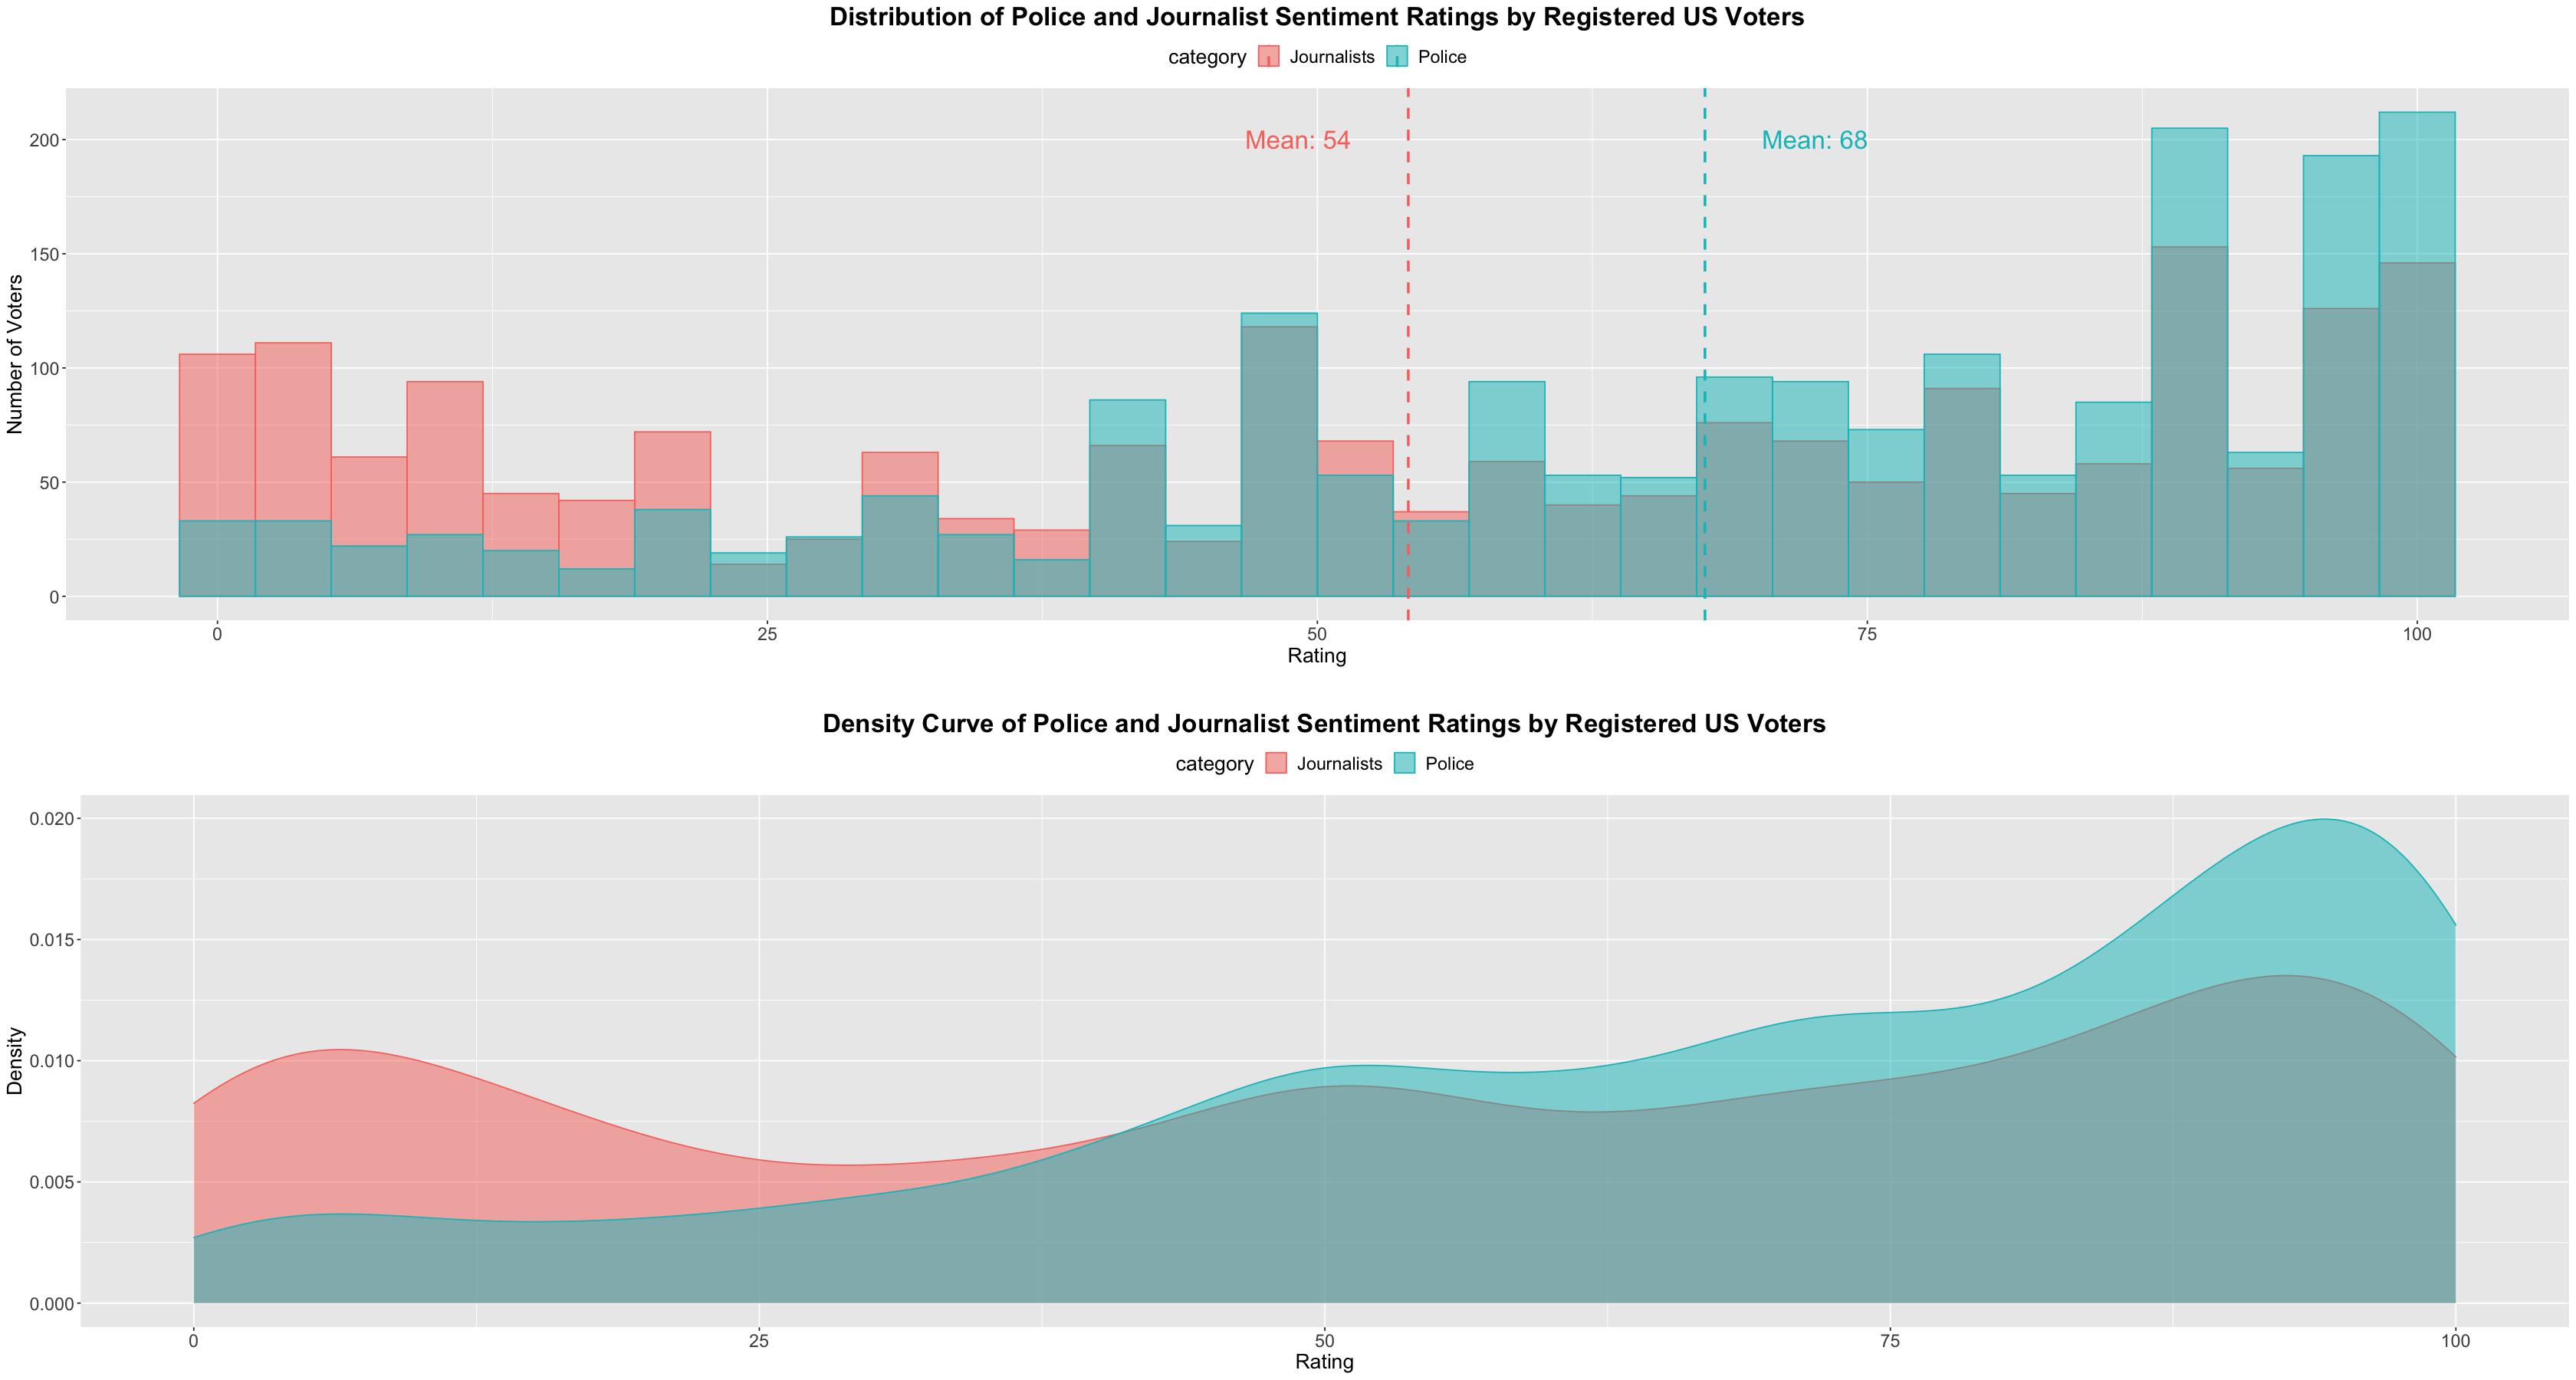

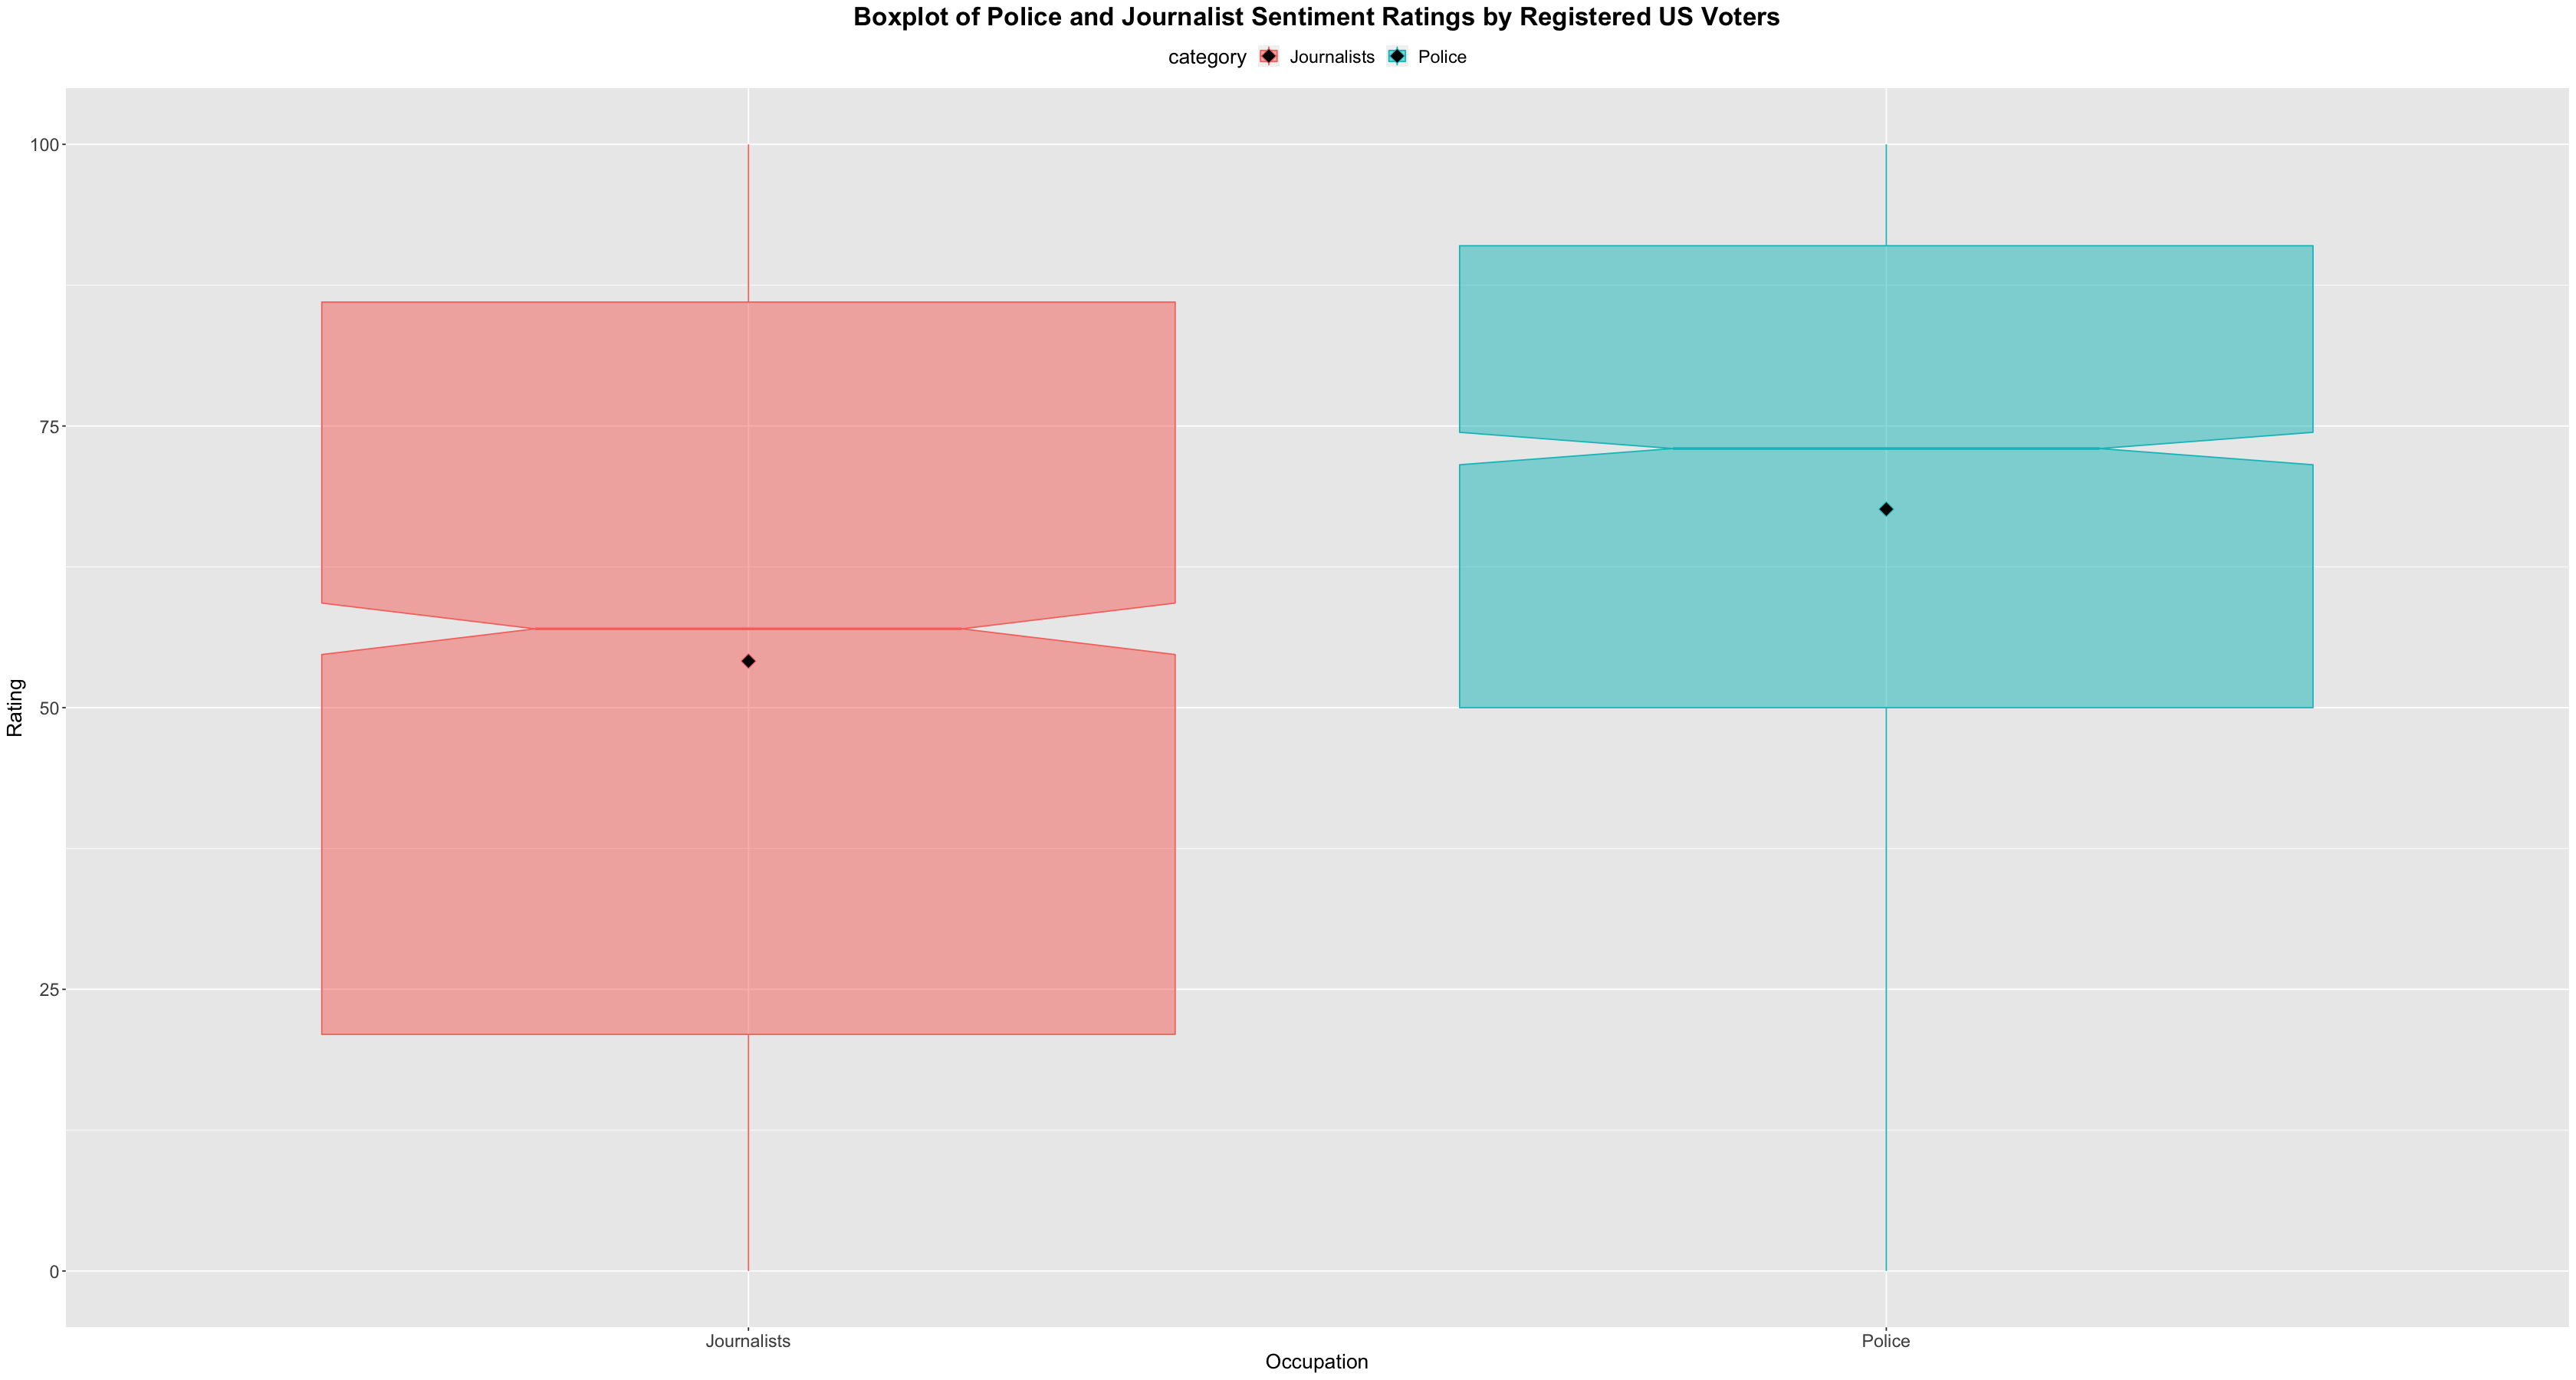

In [224]:
#now that the data has been wrangled, display our EDA
"Summary of Feelings Toward Police and Journalists By Registered Voters"
names <- c("Category","Mean","Standard Deviation", "Count")
df <- data.frame("Category" = mu$category, "Mean" = round(mu$grp.mean,2), "Standard_Deviation" = round(mu$sd, 2), "Count"=mu$grp.count)
head(df)


#Side by side plots of count and proportion in categories
#Suppressing warning messages for the 2 NA rows
suppressWarnings(plot_grid(histo, NULL, dens, ncol = 1, align = "h", rel_heights = c(2, .1, 2)))
bplot

From the histogram, police possess a greater concentration of high scores than journalists. 

The peaks of each density plot helps us identify where ratings are concentrated over the range. Journalist ratings have 3 local peaks, one interpretation, is that respondents were categorically divided in their perception of journalists; low, moderate and high regard. On the contrary, police ratings are left skewed with the peak towards the high end of the range, indicating that a large proportion of respondents held police officers with high regard. 

The notched boxplot not only conveys a higher concentration of higher scores for police, it also shows the distribution is more right skewed than journalists. Additonally, because the notch displays the confidence interval around the median which is normally based on the median for police is higher than journalists, there is strong evidence that the means differ.

$$ \pm 1.58 * IQR/sqrt(n) $$ (Where IQR is the interquartile range) 

### Based on your EDA, select an appropriate hypothesis test.  (5 points)

We will apply a paired two sample T-test and believe it's the most approriate choice for 4 reasons:
1. We're interested in knowing whether the mean difference between 2 groups (police and journalists) is different
2. Each observation is a random sample (independently and identically distributed) meaning that each observation is independent of one another
3. Despite non-normality of the underlying distributions, we have over 700 observations for each party, well over the n > 30 minimum requirement to invoke the Central Limit Theorem
4. The dependent variable, sentiment rating, is of interval type

#### Null hypothesis:
$$H_{0}: \mu_{police} = \mu_{journalist}$$ 
The Null hypothesis is there is no difference in terms of favorability/respect between police officers and journalists

#### Alternative hypothesis:
$$H_{a}: \mu_{police} \ne \mu_{journalist}$$
there is a difference in terms of favorability/respect between police officers and journalists

### Conduct your test. (5 points)

In [16]:
#Shapiro-Wilk to nest normality; p-value < .05 implies that the distribution of the data are significantly different from normal distribution
shapiro.test(dfp$score) #police scores
shapiro.test(dfj$score) #journalist scores


	Shapiro-Wilk normality test

data:  dfp$score
W = 0.91291, p-value < 2.2e-16



	Shapiro-Wilk normality test

data:  dfj$score
W = 0.91559, p-value < 2.2e-16


In [17]:
#apply paired t-test to assess for statistical significance
t.test(dfp$score, dfj$score, paired = TRUE, alternative = "two.sided")


	Paired t-test

data:  dfp$score and dfj$score
t = 12.859, df = 2020, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 11.41273 15.52047
sample estimates:
mean of the differences 
                13.4666 


To assess for practical significance or the effect size, we will use Cohen's d, since the 2 groups have similar standard deviations and similar sample size (see mu group summary statistics in previous section).

We will also be using the below table to interpret the computed effect size of the d-value:

| d | Effect Size  |
|---|---|
|0.2   | Small  |
|0.5  | Medium |
|0.8   | Large   |

In [18]:
#cohen's d for paired t-test to assess for practical significance
cohens_d(score ~ category, data = dfc, paired = TRUE)

,.y.,group1,group2,effsize,n1,n2,magnitude
,<chr>,<chr>,<chr>,<dbl>,<int>,<int>,<ord>
1,score,Journalists,Police,-0.2860288,2023,2023,small


#### Q1 Results Interpretation
- **Statistical significance:** Because the computed p-value (2.2e-16) is very small, we can safely reject the null hypothesis and accept the alternative hypothesis there is a difference in terms of favorability between police officers and journalists

- **Practical significance:** Because the computed effect size of cohen's d test (-0.2860288) is between small and medium, we can conclude that magnitude of the difference between police and journalists are relatively minor. Thus, we can conclude that the magnitude of the mean difference of rating scores between the age of police officers and journalists is minor. 

In conclusion, while the exploratory data analysis coupled with the paired T-test indicate that we can extrapolate that in general voters have a higher opinion (more respect) of police than they do of journalists. However, given the small effect size, the result should be taken with caution as it has limited practical significance.

## Question 2: Are Republican voters older or younger than Democratic voters?

Our goal is to compare the mean age of Republican voters against Democratic voters and assess if the difference is statisically significant or not. In order to accomplish this, we must operationalize 2 variables of interest:
- Voter's age: According to the ANES user code book, there is a **birthyr** variable used to capture the birthyear of each respondent as part the profile data.
- Party affliation: Self-identified through variables such as **pid1d** or **pid1r** (Generally speaking, do you usually think of yourself as a Democrat, a Republican or another political affliation?)

### Perform an exploratory data analysis (EDA) of the relevant variables. (5 points)


In [19]:
#create a copy of the original dataframe
A2 = data.frame(A)

In [225]:
#Data transformation from pid1r responses
df_r = select(A2, birthyr, pid1r) #pulls birthyr and pid1r values
df_r$age = 2018 - A2$birthyr #computes age
df_r$pid1r = replace(df_r$pid1r, df_r$pid1r == 1, "Democrat") #replaces 1 with Democrat
df_r$pid1r = replace(df_r$pid1r, A2$pid1r == 2, "Republican") #replaces 2 with Republican
df_r = df_r %>% filter(pid1r == "Republican" | pid1r == "Democrat") #filter out all non Democrat and Republican values in pid1r
names(df_r)[names(df_r) == "pid1r"] = "party" #renames pid1r with party
df_r = subset(df_r, select = -c(birthyr)) #drop birthyr since it's no longer needed
# head(df_r)
# nrow(df_r)

In [226]:
#Data transformation from pid1d responses
df_d = select(A2, birthyr, pid1d) #pulls birthyr and pid1d values
df_d$age = 2018 - A$birthyr #computes age
df_d$pid1d = replace(df_d$pid1d, A2$pid1d == 1, "Democrat") #replaces 1 with Democrat
df_d$pid1d = replace(df_d$pid1d, A2$pid1d == 2, "Republican") #replaces 2 with Republican
df_d = df_d %>% filter(pid1d == "Republican" | pid1d == "Democrat") #filter out all non Democrat and Republican values in pid1d
names(df_d)[names(df_d) == "pid1d"] = "party" #renames pid1d with party
df_d = subset(df_d, select = -c(birthyr)) #drop birthyr since it's no longer needed
# head(df_d)
# nrow(df_d)

In [228]:
#combine df_r and df_d
df_p = rbind(df_d, df_r)
#nrow(df_p)

#create vector for each party
repub = filter(df_p, party == "Republican")
demo = filter(df_p, party == "Democrat")

#nrow(repub) #sanity check that we have the correct total number of self-identified Republicans
#nrow(demo)  #sanity check that we have the correct total number of self-identified Democrats
stopifnot(nrow(repub) + nrow(demo) == nrow(df_p))

In [229]:
#computes the mean and standard deviation of age by party
mu2 = ddply(df_p, "party", summarize, mean_age = mean(age, na.rm = TRUE), sd_age = sd(age, na.rm = TRUE))
demo_mean = mu2[1,2]
repub_mean = mu2[2,2]

In [24]:
#Histogram
histo2 = ggplot(df_p, aes(age, fill = party, color = party)) + 
    geom_histogram(position = "identity", alpha = .5, bins = 30) +
    geom_vline(data = mu2, aes(xintercept = mean_age, color = party), linetype = "dashed", size = 1) +
    annotate(geom = "text", x = repub_mean - 6, y = 64, label = paste("Mean:", round(demo_mean, 1)), color = "#F8766D", size = 7) +
    annotate(geom = "text", x = demo_mean + 6, y = 64, label = paste("Mean:", round(repub_mean, 1)), color = "#00BFC4", size = 7 ) +
    labs(title = "Distribution of Voter Age by Party Affliation (Self-Identified)", x = "Age", y = "Number of Voters") + 
    plot_theme

In [26]:
#Density plot
dens2 = ggplot(df_p, aes(age, fill = party, color = party)) + 
    geom_density(position = "identity", alpha = .5) +
    labs(title = "Density Curve of Voter Age by Party Affliation (Self-Identified)", x = "Age", y = "Density") +
    plot_theme

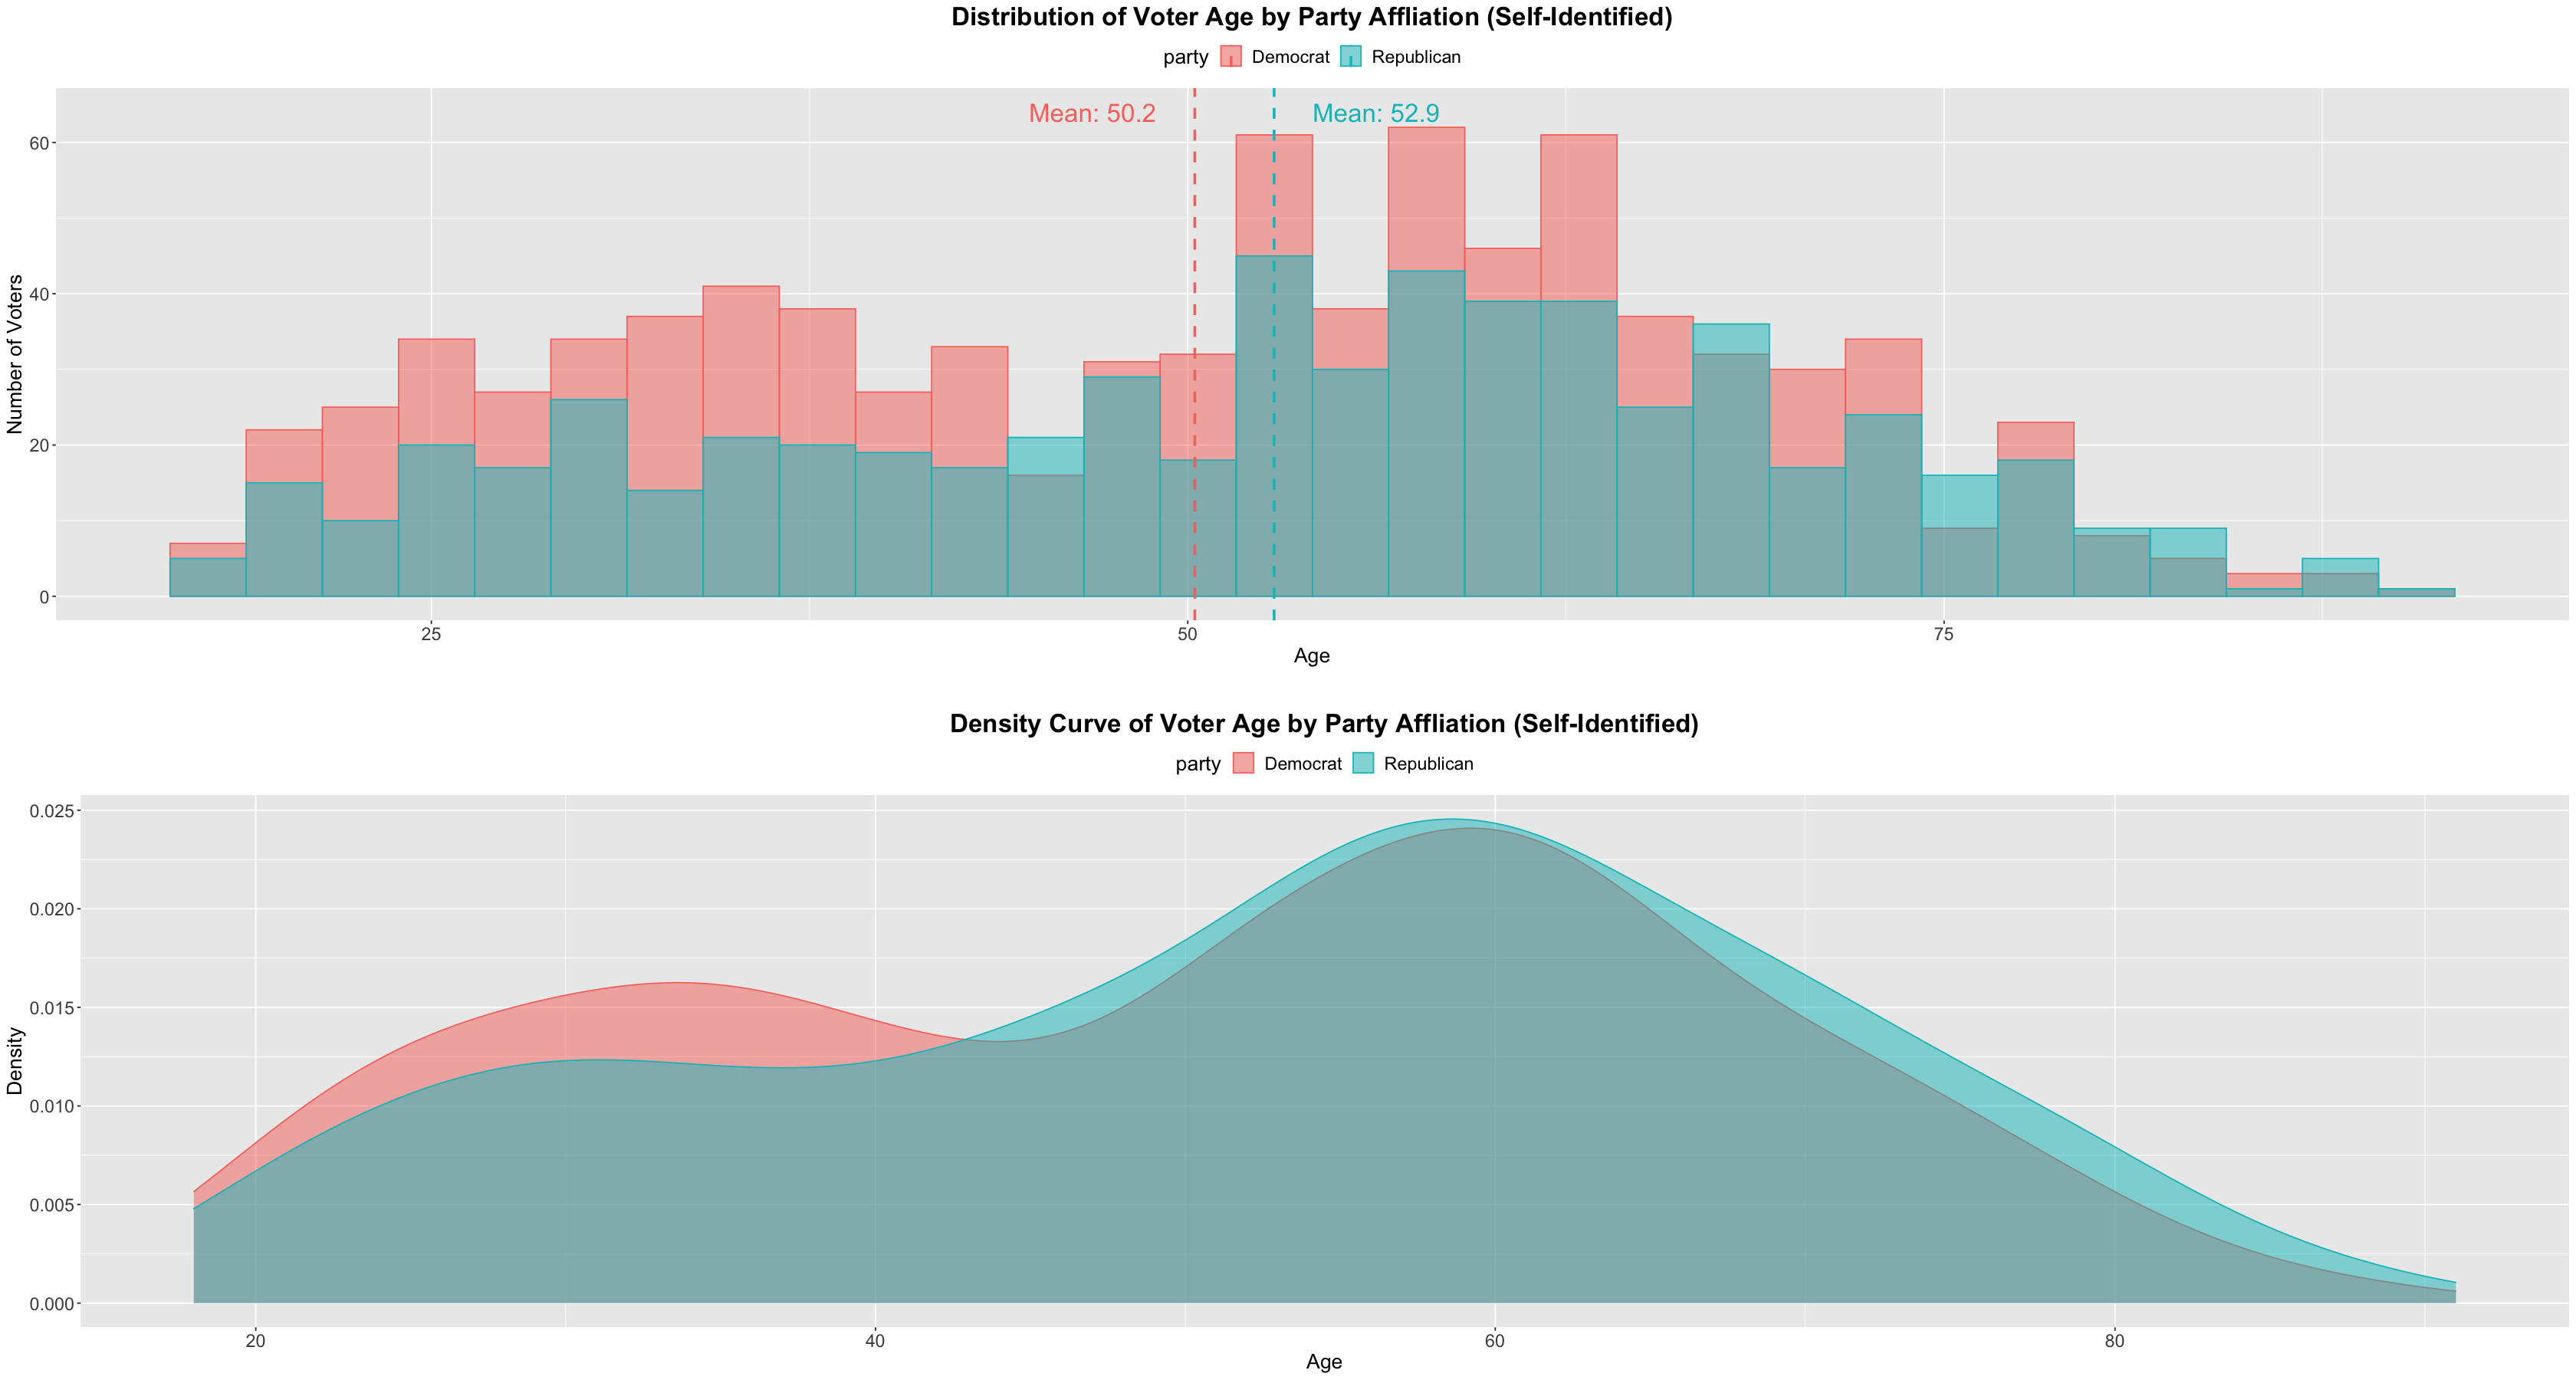

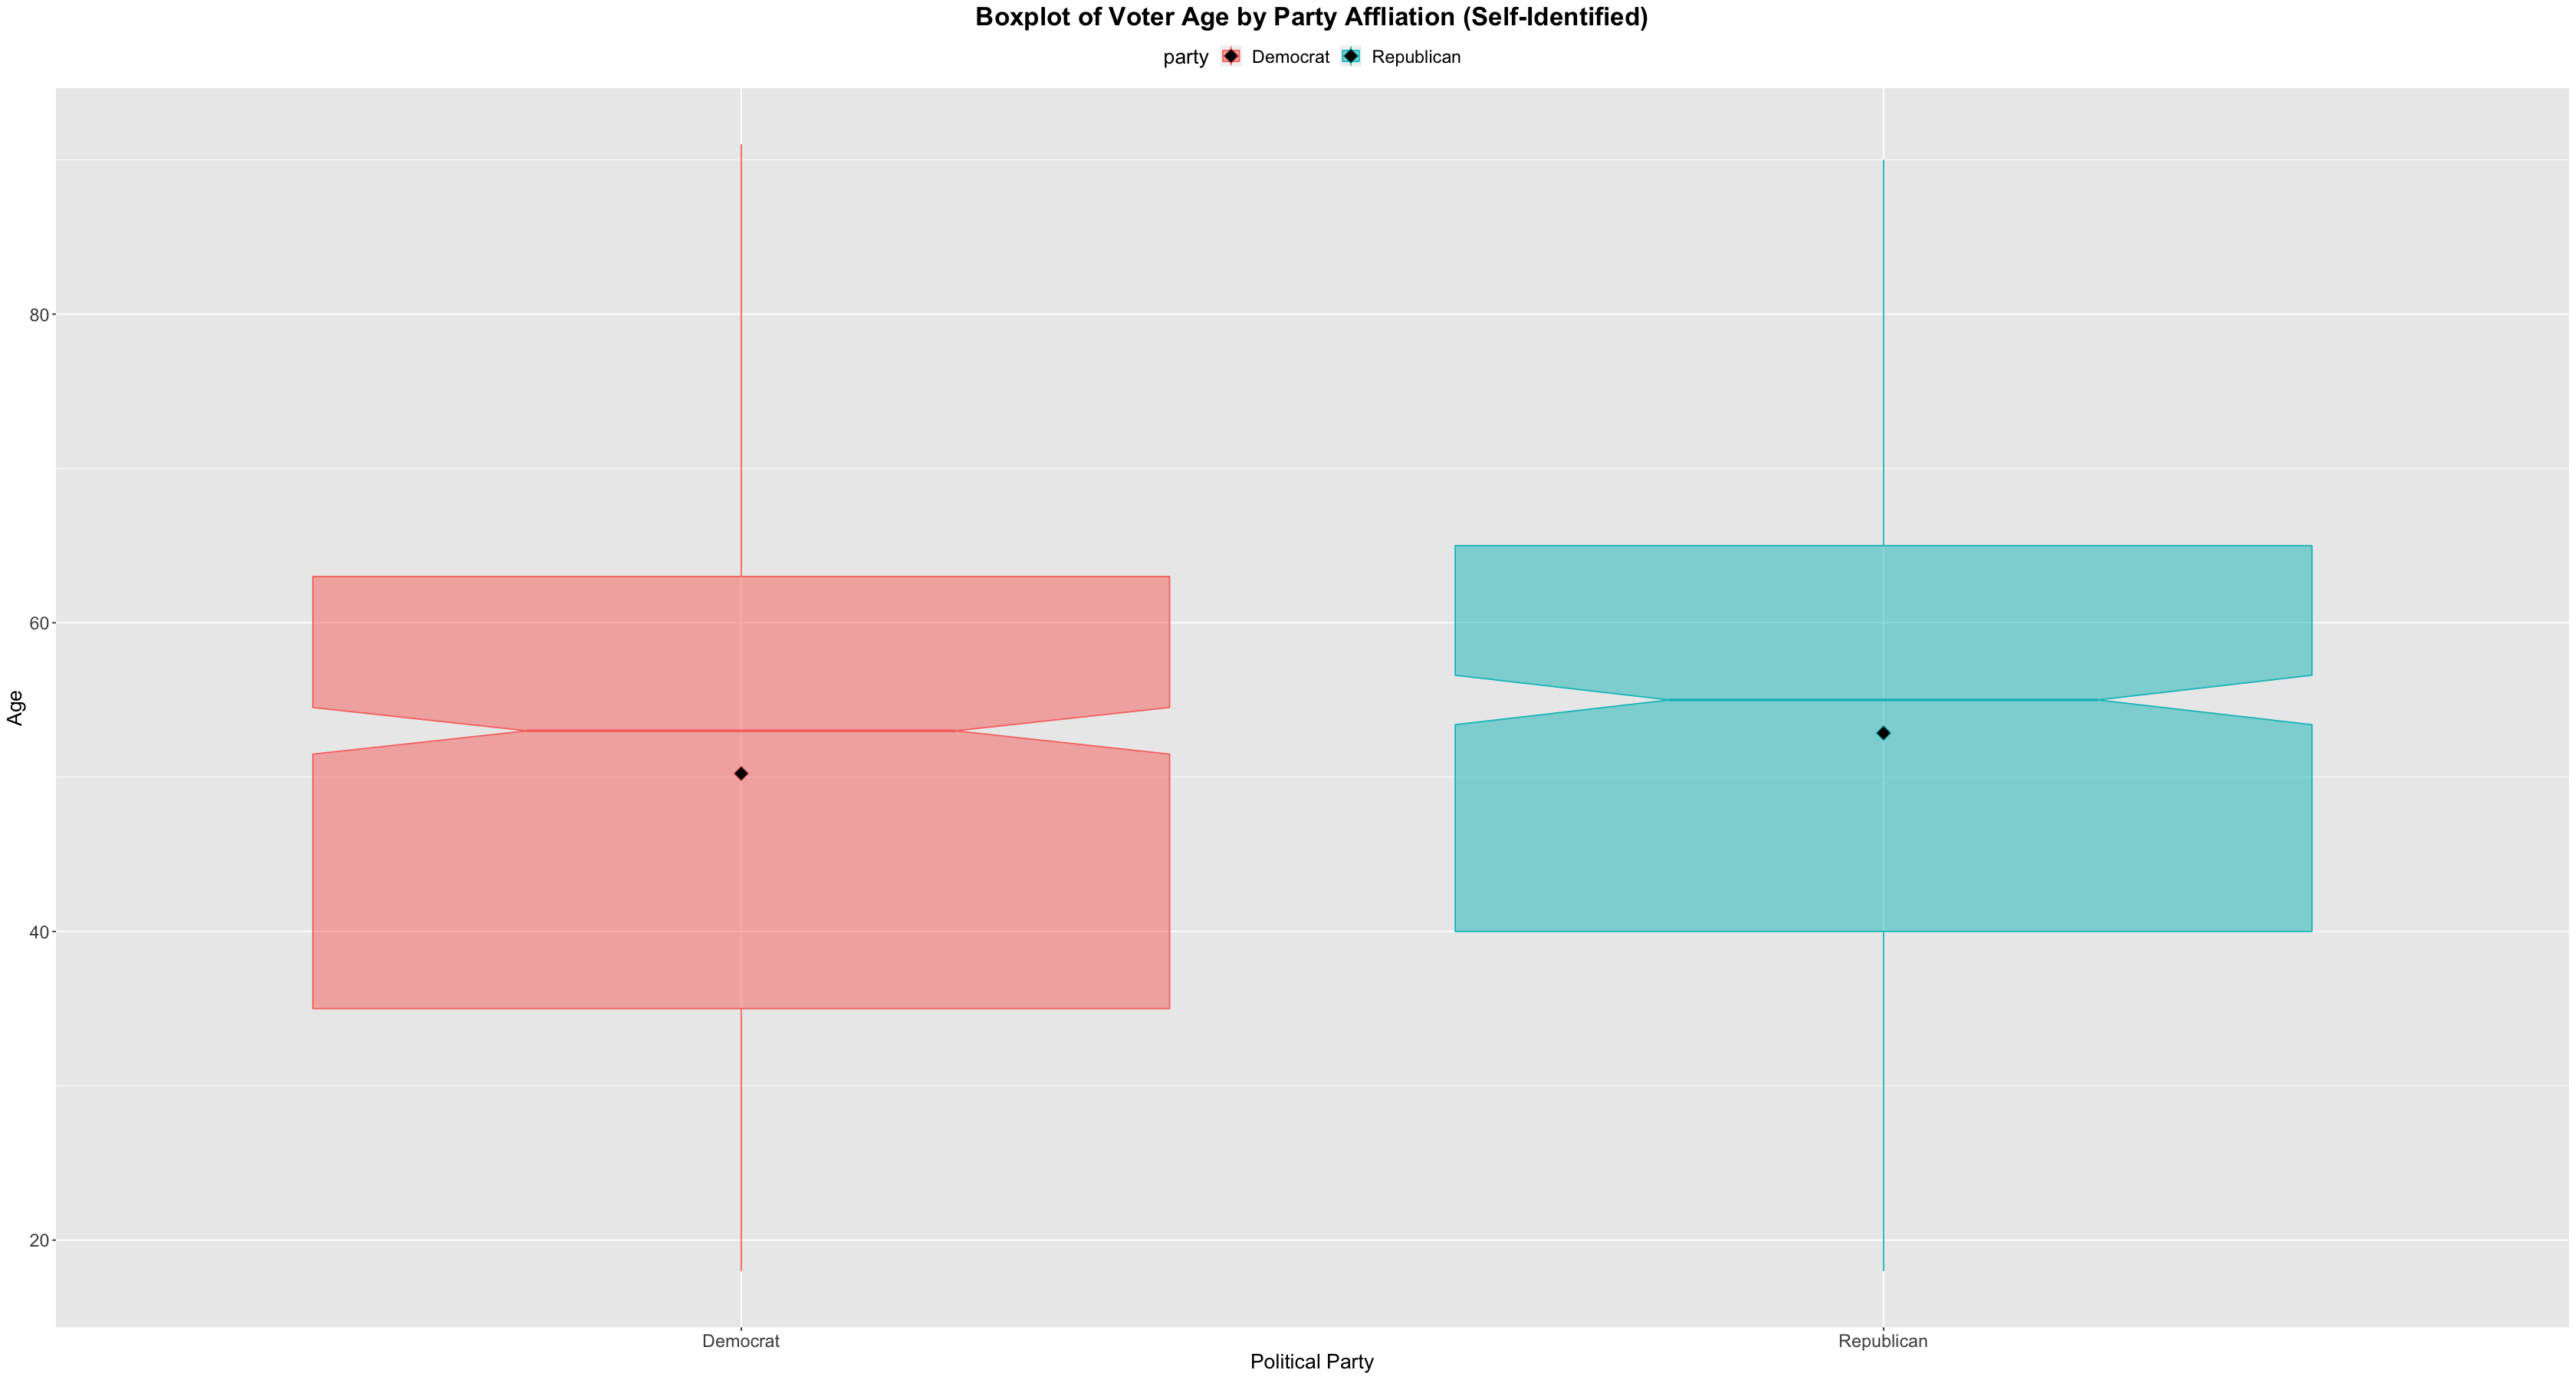

In [230]:
#histogram and density plot side by side
plot_grid(histo2, NULL, dens2, ncol = 1, align = "h", rel_heights = c(2, .1, 2))

#Notched boxplot
box_p2 = ggplot(df_p, aes(y = age, x = party, fill = party, color = party)) + 
    geom_boxplot(alpha = .5, outlier.color = "black", notch = TRUE) + 
    labs(title = "Boxplot of Voter Age by Party Affliation (Self-Identified)", x = "Political Party", y = "Age") + 
    stat_summary(fun = mean, geom = "point", shape = 23, size = 4, fill = "black") + 
    plot_theme

box_p2

From the histogram, density plot and boxplot, the distribution of voter age between Democrats and Republicans exhibit similar shape with the average age of Democrat voters slightly higher than Republican voters. Additionally, the mean, median, and range of of voter age between the 2 parties are similar.

### Based on your EDA, select an appropriate hypothesis test.  (5 points)

We believe a two sided, two sample T-test is appropriate for 4 reasons:

1. We're interested in knowing whether there is a difference between 2 populations (self-professed Republicans and Democrats)
2. Each observation is a random sample (independently and identically distributed) from the population meaning that each observation is independent of one another
3. We have over 700 observations for each party, well over the n > 30 minimum requirement to invoke the Central Limit Theorem
4. The dependent variable, age, is continuous

Thus, we will conduct an independent two sample T-test to determine if the difference in mean voter age between self-identified Republicans and Democrats are statistically significant or not.

Null hypothesis:
 - $H_{0}: \mu_{DemocratAge} = \mu_{RepublicanAge}$; there is no difference in mean age of Democrats and Republicans
 
Alternative hypothesis:
 - $H_{a}: \mu_{DemocratAge} \ne \mu_{RepublicanAge}$; there is a difference in mean age of Democrats and Republicans

### Conduct your test. (5 points)

In [29]:
#Shapiro-Wilk to nest normality; p-value < .05 implies that the distribution of the data are significantly different from normal distribution
shapiro.test(df_d$age) #Democrat age
shapiro.test(df_r$age) #Republican age


	Shapiro-Wilk normality test

data:  df_d$age
W = 0.97737, p-value = 1.922e-09



	Shapiro-Wilk normality test

data:  df_r$age
W = 0.96718, p-value = 1.679e-11


In [30]:
#Two sample T-test to assess statistical significance
t.test(age ~ party, data = df_p)


	Welch Two Sample t-test

data:  age by party
t = -2.939, df = 1309.7, p-value = 0.00335
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -4.3723921 -0.8718651
sample estimates:
  mean in group Democrat mean in group Republican 
                50.23337                 52.85550 


In [31]:
#Cohen's d to assess practical significance
cohens_d(age ~ party, data = df_p)

,.y.,group1,group2,effsize,n1,n2,magnitude
,<chr>,<chr>,<chr>,<dbl>,<int>,<int>,<ord>
1,age,Democrat,Republican,-0.1557597,857,609,negligible


#### Q2 Results Interpretation
- **Statistical significance:** Because the two sample T-test's p-value (0.00335) is smaller than .05, we  reject the null hypothesis and accept the alternative (there is a difference in mean age between Democrats and Republicans) 

- **Practical significance:** Because the computed d-value is -0.155755 (the sign of Cohen's d is determined by which group mean is selected first. Thus, it indicates that we had a mean increase from Democrat to Republican. The same mean difference, but flipped (i.e. Republican first and Democrat second) would give us the same value, but positive instead. Therefore, the sign doesn't tell us anything about the effect size), the practical significance is negligible. Thus, we can conclude the magnitude of the mean difference between the age of Democrats and Replublicans is minor. 

In conclusion, the exploratory data analysis coupled with the T-test as well as Cohen's d provide strong evidence that the age difference between self-identified Democrats and Republicans are not significant, from both a statistical and practical perspective.

## Question 3: Do a majority of independent voters believe that the federal investigations of Russian election interference are baseless?

Our goal is to determine if a majority of independent voters believe the Russian election inteference are baseless. In order to accomplish this, we need to define 3 parameters to conduct the analysis:
1. **Majority definition:** We define a majority to be over 50% (i.e. simple majority)
2. **Party identification:** For the same rationale as Question 2, we believe self-identification provides the strongest and cleanest indicator of respondent's political party affliation and once again use variables **pid1r** and **pid1d**
3. **Belief that the Federal investigations of Russian election inteference are baseless:** The federal investigations into Russian election inteference were pursued separately by the US House of Representatives, Senate and Department of Justice to determine:
   - Whether or not the Russians interfered in the 2016 presidential election (russia16)
   - Whether Donald Trump's 2016 campaign coordinated with the Russian government (coord16)

Since the question asks about the validity of the subsequent Federal investigation, we will use the variable **muellerinv** to measure the survey respondents' perception on the quality of the investigation that was led by Robert Mueller. The corresponding question asks respondents "Do you approve, disapprove, or neither approve nor disapprove of Robert Mueller’s investigation of Russian interference in the 2016 election?"

### Perform an exploratory data analysis (EDA) of the relevant variables. (5 points)

In [32]:
#create a copy of the original dataframe
A3 = data.frame(A)

In [231]:
#data extraction and manipulation from muellerinv and pid1r variables
df_muel_r = select(A3, muellerinv, pid1r)
df_muel_r$pid1r = replace(df_muel_r$pid1r, df_muel_r$pid1r == 3, "Independent") #replaces 3 with Independent
df_muel_r = df_muel_r %>% filter(pid1r == "Independent") #filter out all non 3 values in pid1r
names(df_muel_r)[names(df_muel_r) == "pid1r"] = "party" #renames pid1r with party
names(df_muel_r)[names(df_muel_r) == "muellerinv"] = "inv_rating" #renames muellerinv with inv_rating (investigation rating)
#df_emo$anger = factor(df_emo$anger, levels = 1:5, labels = c("Not at all", "A little", "Somewhat", "Very", "Extremely"), ordered = TRUE) #factorize integer values to 5 emotion levels

#nrow(df_muel_r)
#head(df_muel_r)

In [232]:
#data extraction and manipulation from muellerinv and pid1d variables
df_muel_d = select(A3, muellerinv, pid1d)
df_muel_d$pid1d = replace(df_muel_d$pid1d, df_muel_d$pid1d == 3, "Independent") #replaces 3 with Independent
df_muel_d = df_muel_d %>% filter(pid1d == "Independent") #filter out all non 3 values in pid1r
names(df_muel_d)[names(df_muel_d) == "pid1d"] = "party" #renames pid1r with party
names(df_muel_d)[names(df_muel_d) == "muellerinv"] = "inv_rating" #renames muellerinv with inv_rating (investigation rating)

#nrow(df_muel_d)
#head(df_muel_d)

In [233]:
#combine df_muel_r and df_muel_d
df_mueller = rbind(df_muel_r, df_muel_d)
df_mueller$inv_rating[df_mueller$inv_rating == -7] = NA #recode no answers (-7 value) to NA
df_mueller$inv_scale = cut(df_mueller$inv_rating, c(0,1,2,3,4,5,6,7), c("Approve extremely strongly", "Approve moderately strongly", "Approve slightly", "Neither approve nor disapprove", 
                                    "Disapprove slightly", "Disapprove moderately strongly", " Disapprove extremely strongly"), ordered = TRUE) #add an ordered response scale column
df_mueller$sentiment = cut(df_mueller$inv_rating, c(0,3,4,7), c("Approve", "Neutral", "Disapprove"), ordered = TRUE) #maps 1:3 response value to "Approved," 4 to "Neutral" and 5:7 to "Disapprove"
df_mueller$inv_rating = factor(df_mueller$inv_rating, levels = 1:7, ordered = TRUE) #factorize integer values ordered levels
df_mueller = df_mueller[c(2,1,3,4)] #reoders column index

#unique(df_mueller$inv_rating) #sanity check to make sure there values 1:7 exist
#unique(df_mueller$party) #sanity check that only Independent value should be present

#nrow(df_mueller)
#head(df_mueller)

In [235]:
#scale specific data frame to plot out the distribution 
df_mueller_scale = df_mueller %>%
    group_by(inv_scale) %>%
    tally() %>%
    mutate(perc = n / sum(n) * 100) %>%
    group_by(inv_scale)
names(df_mueller_scale)[names(df_mueller_scale) == "n"] = "count" #renames n to count

stopifnot(sum(df_mueller_scale$count)==767) #sanity check to make sure sum of count equals to 767
stopifnot(sum(df_mueller_scale$perc)==100) #sanity check to make sure sum of perc equals to 100%
#df_mueller_scale

In [37]:
#histogram of response sentiment by count
muel_count = ggplot(df_mueller_scale, aes(x = inv_scale, y = count, fill = inv_scale)) +
    geom_bar(stat = "identity") +
    geom_text(aes(label = count), hjust = -0.3, size = 6) + 
    coord_flip() + 
    labs(title = "Sentiment Towards Robert Mueller's Investigation of Russian Interference in the 2016 Election", 
         x = "Sentiment Scale", y = "Number of Independent Respondents") +
    scale_fill_discrete(name = "Sentiment Scale") + 
    plot_theme

In [38]:
#histogram of response sentiment by proportion
options(repr.plot.width = 22, repr.plot.height = 16) 
muel_prop = ggplot(df_mueller_scale, aes(x = inv_scale, y = perc, fill = inv_scale)) +
    geom_bar(stat = "identity") +
    geom_text(aes(label = paste(round(perc,1),"%")), hjust = -0.05, size = 6) + 
    coord_flip() + 
    labs(title = "Sentiment Towards Robert Mueller's Investigation of Russian Interference in the 2016 Election", 
         x = "Sentiment Scale", y = "Percent of Total Independent Respondents") +
    scale_fill_discrete(name = "Sentiment Scale") + 
    plot_theme

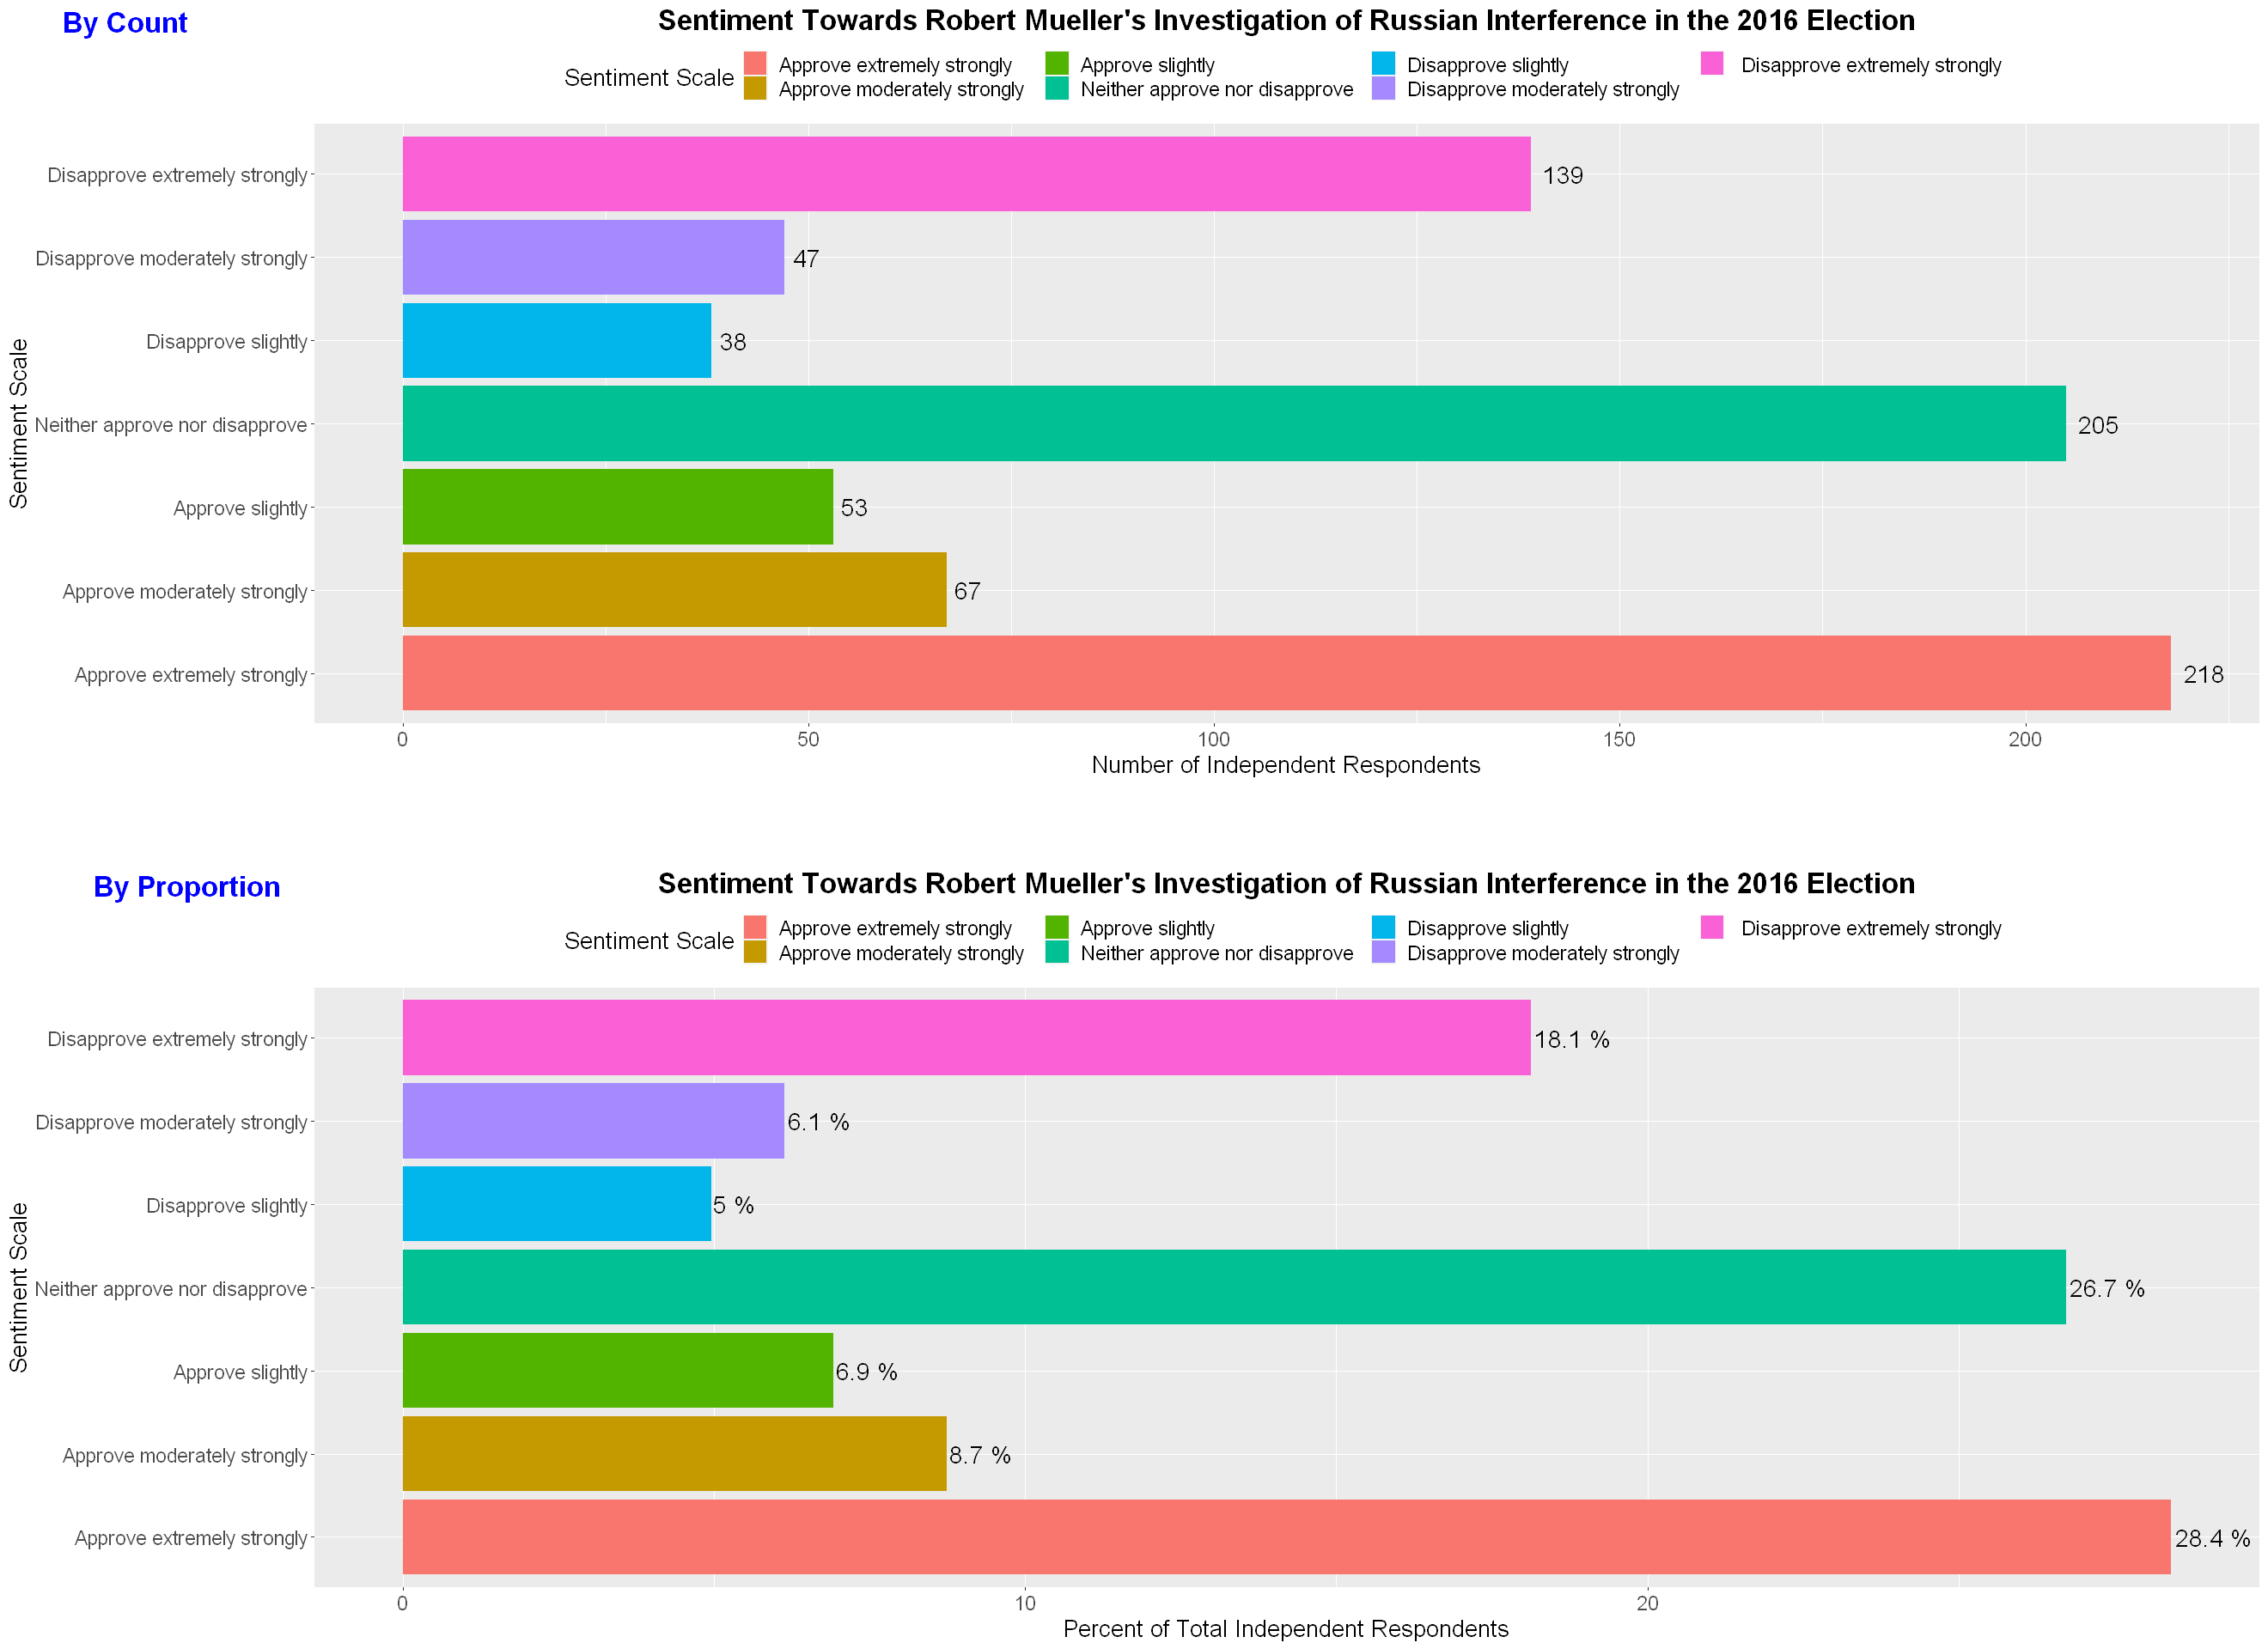

In [39]:
#Side by side plots of count and proportion
plot_grid(muel_count, NULL, muel_prop, ncol = 1, align = "v", rel_heights = c(1, .1, 1), labels = c("By Count", "", "By Proportion"), label_size = 20, label_colour = "blue")

From the distribution of both count and sentiment plots, there are 2 spikes that can be observed:
1. Almost 23% of respondents had a neutral sentiment
2. Approximately 43% of Independent respondents approved Robert Mueller's investigation, with 66% (28.4 / 43) of the total from the "Approve extremely strongly" category

From the visualization alone, there is evidence to indicate Independent respondents are split in their overall sentiment towards how well Robert Mueller and the FBI executed the investigation of Russian interference in the 2016 Presidential election. 

Next, we will collapse the different sentiment scale into 3 overall buckets (Approve, Neutral, Disapprove) to gain a better understanding of the overall belief, which will also be used to test both the statistical and practical significance of whether a majority of Independent voters believe that the federal investigations of Russian election interference are baseless. Specifically, the mapping ofsentiment scale to category is:
- **Approve** = Approve extremely strongly (1) or Approve moderately strongly (2) or Approve slightly (3)
- **Neutral** = Neither approve nor disapprove (4)
- **Disapprove** = Disapprove slightly (5) or Disapprove moderately strongly (6) or Disapprove extremely strongly (7)

In [236]:
#category data frame to plot out the distribution 
df_mueller_cat = df_mueller %>%
    group_by(sentiment) %>%
    tally() %>%
    mutate(perc = n / sum(n) * 100) %>%
    group_by(sentiment)
names(df_mueller_cat)[names(df_mueller_cat) == "n"] = "count" #renames n to count

stopifnot(sum(df_mueller_cat$count)==767) #sanity check to make sure sum of count equals to 767
stopifnot(sum(df_mueller_cat$perc)==100) #sanity check to make sure sum of perc equals to 100%
df_mueller_cat

sentiment,count,perc
<ord>,<int>,<dbl>
Approve,338,44.06780
Neutral,205,26.72751
Disapprove,224,29.20469


In [41]:
#histogram of sentiment category by count
muel_count_cat = ggplot(df_mueller_cat, aes(x = sentiment, y = count, fill = sentiment)) +
    geom_bar(stat = "identity") +
    geom_text(aes(label = count), hjust = -0.3, size = 6) + 
    coord_flip() + 
    labs(title = "Sentiment Towards Robert Mueller's Investigation of Russian Interference in the 2016 Election", 
         x = "Sentiment Category", y = "Number of Independent Respondents") +
    scale_fill_discrete(name = "Sentiment Category") + 
    plot_theme

In [42]:
#histogram of response category by proportion
muel_prop_cat = ggplot(df_mueller_cat, aes(x = sentiment, y = perc, fill = sentiment)) +
    geom_bar(stat = "identity") +
    geom_text(aes(label = paste(round(perc,1),"%")), hjust = -0.05, size = 6) + 
    coord_flip() + 
    labs(title = "Sentiment Towards Robert Mueller's Investigation of Russian Interference in the 2016 Election", 
         x = "Sentiment Category", y = "Percent of Total Independent Respondents") +
    scale_fill_discrete(name = "Sentiment Category") + 
    plot_theme

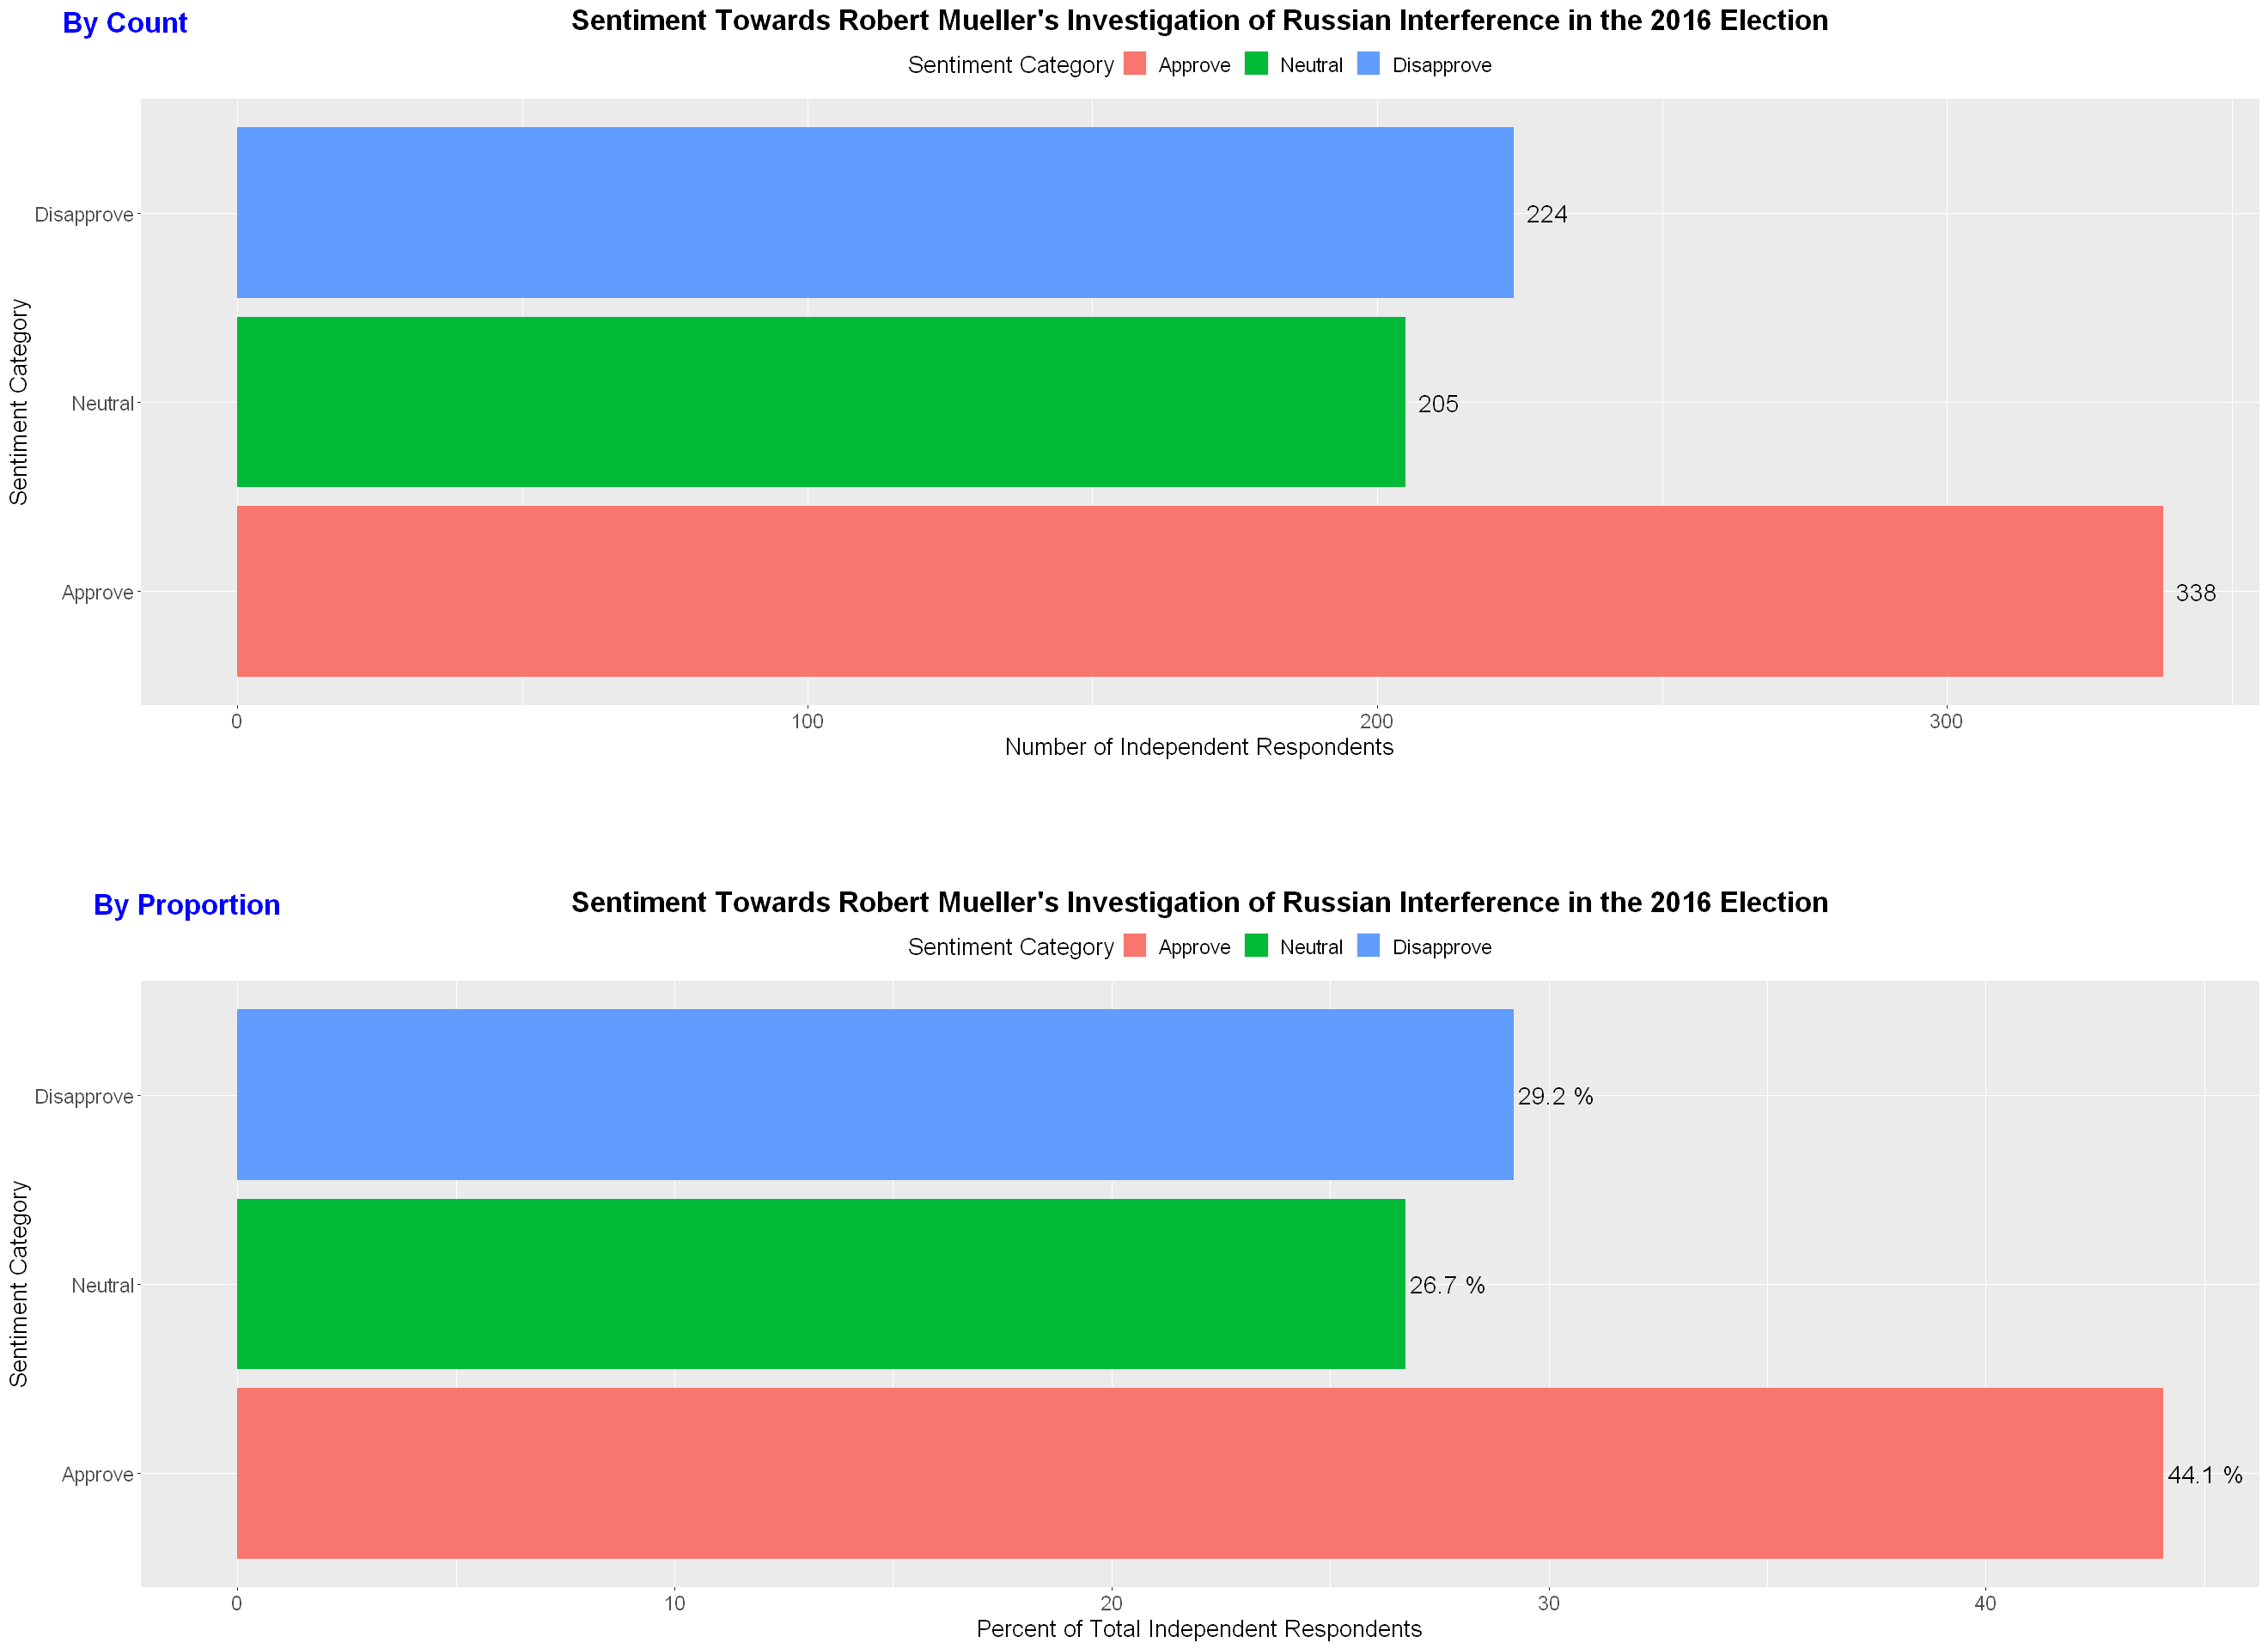

In [43]:
#Side by side plots of count and proportion in categories
plot_grid(muel_count_cat, NULL, muel_prop_cat, ncol = 1, align = "v", rel_heights = c(1, .15, 1), labels = c("By Count", "", "By Proportion"), label_size = 20, label_colour = "blue")

After collapsing individual sentiment scales into their respective categories, it appears that 44% of Independent respondents approve of Robert Mueller's handling of the Russian intereference investigation.

### Based on your EDA, select an appropriate hypothesis test.  (5 points)

We will apply the one sample Wilcoxon Signed Rank test to determine if the median sentiment value of Independents is different than the neutral rating of a 4. We're taking a non-parametric approach in lieu of a T-test because the underlying data are ordinal, which is not apprproriate for a T-test, since ordinal data doesn't have a normal distribution. Thus, means and variances are arbitrary with ordinal data, and hence the t-statistic is also arbitrary. hence, with Likert scale data, the T-test is inappropriate and uninterpretable.

Null hypothesis:
 - $H_{0}: \mu = 4$; there is no difference in the sentiment (neutral) of Independent voters on their view of how the Russian interference investigation was handled
 
Alternative hypothesis:
 - $H_{a}: \mu \ne 4$; there is a difference in the sentiment (non-neutral) of Independent voters on their view of how the Russian interference investigation was handled

### Conduct your test. (5 points)

In [44]:
#one sample Wilcoxon Signed Ranked test to test against median = 4 (neutral sentiment) and the 95% CI falls between (3.5, 4). Rating of 1-3 = Approve
df_sign = select(df_mueller, party, inv_rating)
df_sign$inv_rating = as.numeric(df_sign$inv_rating)

df_sign %>% wilcox_test(inv_rating ~ 1, mu = 4, detailed = TRUE) %>% add_significance() 

estimate,.y.,group1,group2,n,statistic,p,conf.low,conf.high,method,alternative,p.signif
<dbl>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
3.999955,inv_rating,1,null model,767,62103.5,4.89e-06,3.499971,3.999939,Wilcoxon,two.sided,****


>We will also be using the below table to interpret the computed effect size:
>
>| R | Effect Size  |
>|---|---|
>|0.1   | Small  |
>|0.3  | Medium |
>|0.5   | Large   |

In [45]:
#effect size by assessing the r value
df_sign %>% wilcox_effsize(inv_rating ~ 1, mu  = 4)

,.y.,group1,group2,effsize,n,magnitude
,<chr>,<chr>,<chr>,<dbl>,<int>,<ord>
1,inv_rating,1,null model,0.1727161,767,small


#### Q3 Results Interpretation
- **Statistical significance:** Because the one sample Wilcoxon Signed Ranked test returned a p-value of 4.89e-06 against our median of 4 (neutral sentiment) that's much smaller than our alpha of .05, we can reject the null hypothesis. Additionally, based on the 95% confidence interval of ~(3.5, 4), the true population sentiment of Independent voters is that they slightly approve Mueller's investigation but borders on neutral (neither approve or disapprove). However, we cannot say that a majority of Independent voters believed the investigation was baseless.

- **Practical significance:** Because the computed r value is ~0.17, the practical significance is small. Thus, we can conclude that magnitude of the difference between Independent voter's belief regarding Russian interference in the 2016 presidential election is negligible. 

In conclusion, while there is a difference in belief, among self-identified Independent voters, of approval sentiments of Mueller's invesitgation of the 2016 presidential election, we cannot claim that a majority of the self-identified Independents believe the investigation was baseless.

## Question 4: Was anger or fear more effective at driving increases in voter turnout from 2016 to 2018?

Our goal is to understand levels of voter fear and anger as a measure of influence to voter turnout. Specifically, we wish to determine which of the 2 emotions play a more contributing factor to voter turnout. To conduct the analysis, we will need to operationalize 3 variables:
1. Anger
2. Fear
3. Voter turnout

From the ANES survey, there is a question called Global Emotion Battery (GEB) that prompts respondents to rank their sentiment towards a specific emotion with respect to the way things are going in the country these days. Two of the emotions listed are anger (geangry) and fear (geafraid), which will use for the analysis.

We operationalize the definition of increased turnout sample to include those respondents that voted in 2018 versus those who did not vote. We are not comparing voters in 2018 with 2016 to deduce this because we are not arguing whether increased turnout happened in this research, but rather taking it on face value that it did and relying on other research that has shown the 2018 off-cycle election did indeed have higher turnout. 

We would also need the same GEB question and response data for the 2016 election as a baseline if we wish to understand which of the 2 emotions _caused_ the increase in voter turnout. 

We make the assumption that turnout was higher and evaluate which emotion, anger or fear, was the more influential in the 2018 election. The variable of interest and its associated prompt is:

- **turnout18:** In the election held on November 6, did you definitely vote in person on election day, vote in person before Nov 6, vote by mail, did you definitely not vote, or are you not completely sure whether you voted in that election?

For respondents that were not sure if they voted in 2018, they were asked: "If you had to guess, would you say that you probably did vote in the election held on
November 6, or probably did not vote in that election?" This is an example of a leading question and forces the user to recall from memory, which has been shown to cause memory error or the incorrect recall of information. For this reason, we have excluded any "Probably did vote" responses to minimize contamination of unreliable data into the analysis.

### Perform an exploratory data analysis (EDA) of the relevant variables. (5 points)

In [46]:
#create a copy of the original dataframe
A4 = data.frame(A)

In [47]:
#Create a new dataframe with geangry, geafraid and turnout18 variables/columns
df_emo = select(A4, geangry, geafraid, turnout18)
names(df_emo)[names(df_emo) == "geangry"] = "anger" #renames geangry to anger
names(df_emo)[names(df_emo) == "geafraid"] = "afraid" #renames geafraid to fear
names(df_emo)[names(df_emo) == "turnout18"] = "voted18" #renames turnout18 to voted18
df_emo$anger[df_emo$anger == -7] = NA #recode no answers (-7 value) to NA
df_emo$afraid[df_emo$afraid == -7] = NA #recode no answers (-7 value) to NA
df_emo$anger = factor(df_emo$anger, levels = 1:5, labels = c("Not at all", "A little", "Somewhat", "Very", "Extremely"), ordered = TRUE) #factorize integer values to 5 emotion levels
df_emo$afraid = factor(df_emo$afraid, levels = 1:5, labels = c("Not at all", "A little", "Somewhat", "Very", "Extremely"), ordered = TRUE) #factorize integer values into 5 emotion levels
df_emo$voted18 = ifelse(df_emo$voted18 %in% 1:3, "Voted", "Not Voted" ) #response value of 1:3 indicates the respondent voted in 2018
df_emo$voted18 = factor(df_emo$voted18, levels = c("Voted", "Not Voted"), ordered = TRUE) #factorize values into 2 levels (voted and not voted)

summary(df_emo)
head(df_emo, 10)

        anger            afraid         voted18    
 Not at all:527   Not at all:607   Voted    :1842  
 A little  :470   A little  :572   Not Voted: 658  
 Somewhat  :576   Somewhat  :602                   
 Very      :469   Very      :426                   
 Extremely :455   Extremely :287                   
 NA's      :  3   NA's      :  6                   

,anger,afraid,voted18
,<ord>,<ord>,<ord>
1,A little,A little,Voted
2,Somewhat,Extremely,Not Voted
3,Somewhat,A little,Not Voted
4,Not at all,Not at all,Not Voted
5,A little,Somewhat,Voted
6,Somewhat,Somewhat,Voted
7,Not at all,Very,Voted
8,Not at all,Somewhat,Voted
9,Somewhat,Somewhat,Not Voted


In [237]:
#Change wide format into long format by collapsing fear and afraid into a single variable called "emotion_type"
df_emo2 = df_emo %>% gather(emotion_type, scale, 1:2, factor_key = TRUE)
df_emo2$scale = factor(df_emo2$scale, levels = c("Not at all", "A little", "Somewhat", "Very", "Extremely"), ordered = TRUE) #factorize values into 2 levels (voted and not voted)

stopifnot(nrow(df_emo2)==5000) #sanity check to make sure there are 5000 rows (2500 * 2)
#head(df_emo2)

In [240]:
#create an "anger" specific datafram with relative proportion between voters and non-voters
df_angry_voted = df_emo2 %>% #voters df
    filter(emotion_type == "anger" & voted18 == "Voted") %>%
    group_by(scale, voted18) %>%
    tally() %>% #counts the number of responses
    group_by(voted18) %>%
    mutate(percent = n/sum(n) * 100) %>%
    arrange(voted18)

df_angry_not_voted = df_emo2 %>% #non voters df
    filter(emotion_type == "anger" & voted18 == "Not Voted") %>%
    group_by(scale, voted18) %>%
    tally() %>% #counts the number of responses
    group_by(voted18) %>%
    mutate(percent = n/sum(n) * 100) %>%
    arrange(voted18)

df_angry = rbind(df_angry_voted, df_angry_not_voted)
names(df_angry)[names(df_angry) == "n"] = "count" #renames n to count
df_angry$emo = "Anger"
df_angry = df_angry[c(5, 2,1,3,4)] #reoders column index

stopifnot(sum(df_angry$count)==2500) #sanity check total adds up to 2500
stopifnot(sum(df_angry$percent)==200) #sanity check that total percent adds up to 100
#df_angry

In [241]:
#create an "afraid" specific datafram with relative proportion between voters and non-voters
df_afraid_voted = df_emo2 %>% #voters df
    filter(emotion_type == "afraid" & voted18 == "Voted") %>%
    group_by(scale, voted18) %>%
    tally() %>% #counts the number of responses
    group_by(voted18) %>%
    mutate(percent = n/sum(n) * 100) %>%
    arrange(voted18)

df_afraid_not_voted = df_emo2 %>% #non voters df
    filter(emotion_type == "afraid" & voted18 == "Not Voted") %>%
    group_by(scale, voted18) %>%
    tally() %>% #counts the number of responses
    group_by(voted18) %>%
    mutate(percent = n/sum(n) * 100) %>%
    arrange(voted18)

df_afraid = rbind(df_afraid_voted, df_afraid_not_voted)
names(df_afraid)[names(df_afraid) == "n"] = "count" #renames n to count
df_afraid$emo = "Afraid"
df_afraid = df_afraid[c(5,2,1,3,4)] #reoders column index

stopifnot(sum(df_afraid$count)==2500) #sanity check total adds up to 2500
stopifnot(sum(df_afraid$percent)==200) #sanity check that total percent adds up to 100
#df_afraid

In [242]:
#combine both df_angry and df_afraid into a single dataframe for visualization and analysis
df_all = rbind(df_afraid, df_angry)
df_all$emo = factor(df_all$emo, levels = c("Anger", "Afraid"), ordered = TRUE) #factorize values into 2 levels (voted and not voted)
stopifnot(sum(df_all$count)==5000) #sanity check to make sure it adds up to 5000 (2500 * 2 df)
stopifnot(sum(df_all$percent)==400) #sanity check to make sure the percent adds up to 400 (100 * 2 df)
df_all

emo,voted18,scale,count,percent
<ord>,<ord>,<ord>,<int>,<dbl>
Afraid,Voted,Not at all,418,22.6927253
Afraid,Voted,A little,423,22.9641694
Afraid,Voted,Somewhat,433,23.5070575
Afraid,Voted,Very,343,18.6210641
Afraid,Voted,Extremely,221,11.9978284
Afraid,Voted,NA,4,0.2171553
Afraid,Not Voted,Not at all,189,28.7234043
Afraid,Not Voted,A little,149,22.6443769
Afraid,Not Voted,Somewhat,169,25.6838906


In [52]:
#Response count by emotion and scale
options(repr.plot.width = 28, repr.plot.height = 15)
emo_c = ggplot(df_all, mapping = aes(x = voted18, y = count, fill = scale)) +
    facet_wrap(~ emo) + 
    geom_col() +
    geom_text(aes(label = count, y = count), size = 5, position = position_stack(vjust = 0.5), color = "white") +
    stat_summary(fun = sum, aes(label = ..y.., group = voted18), size = 5, geom = "text", vjust = -.25) +
    annotate(geom = "text", x = 2, y =1800, label = "Total: 2,500", color = "blue", size = 6) +
    labs(title="Emotional Battery Response", y = "Number of Responses", x = "Did You Vote in 2018?") +
    theme(strip.text.x = element_text(size = 18, color = "black")) +
    plot_theme
emo_c = emo_c + scale_fill_discrete(name = "Emotional Scale")

In [53]:
#Response proprotion by emotion and scale
emo_p = ggplot(df_all, mapping = aes(x = voted18, y = percent, fill = scale)) +
    facet_wrap(~ emo) + 
    geom_col() +
    geom_text(aes(label = paste(round(percent,1),"%")), size = 5, position = position_stack(vjust = 0.5), color = "white") +
    #annotate(geom = "text", x = 1.5, y =105, label = "Total : 2,500", color = "blue", size = 6) +
    labs(title = "Emotional Battery Response", y = "Percent of Responses", x = "Did You Vote in 2018?") +
    theme(strip.text.x = element_text(size = 18, color = "black")) + 
    scale_fill_discrete(name = "Emotional Scale") + 
    plot_theme

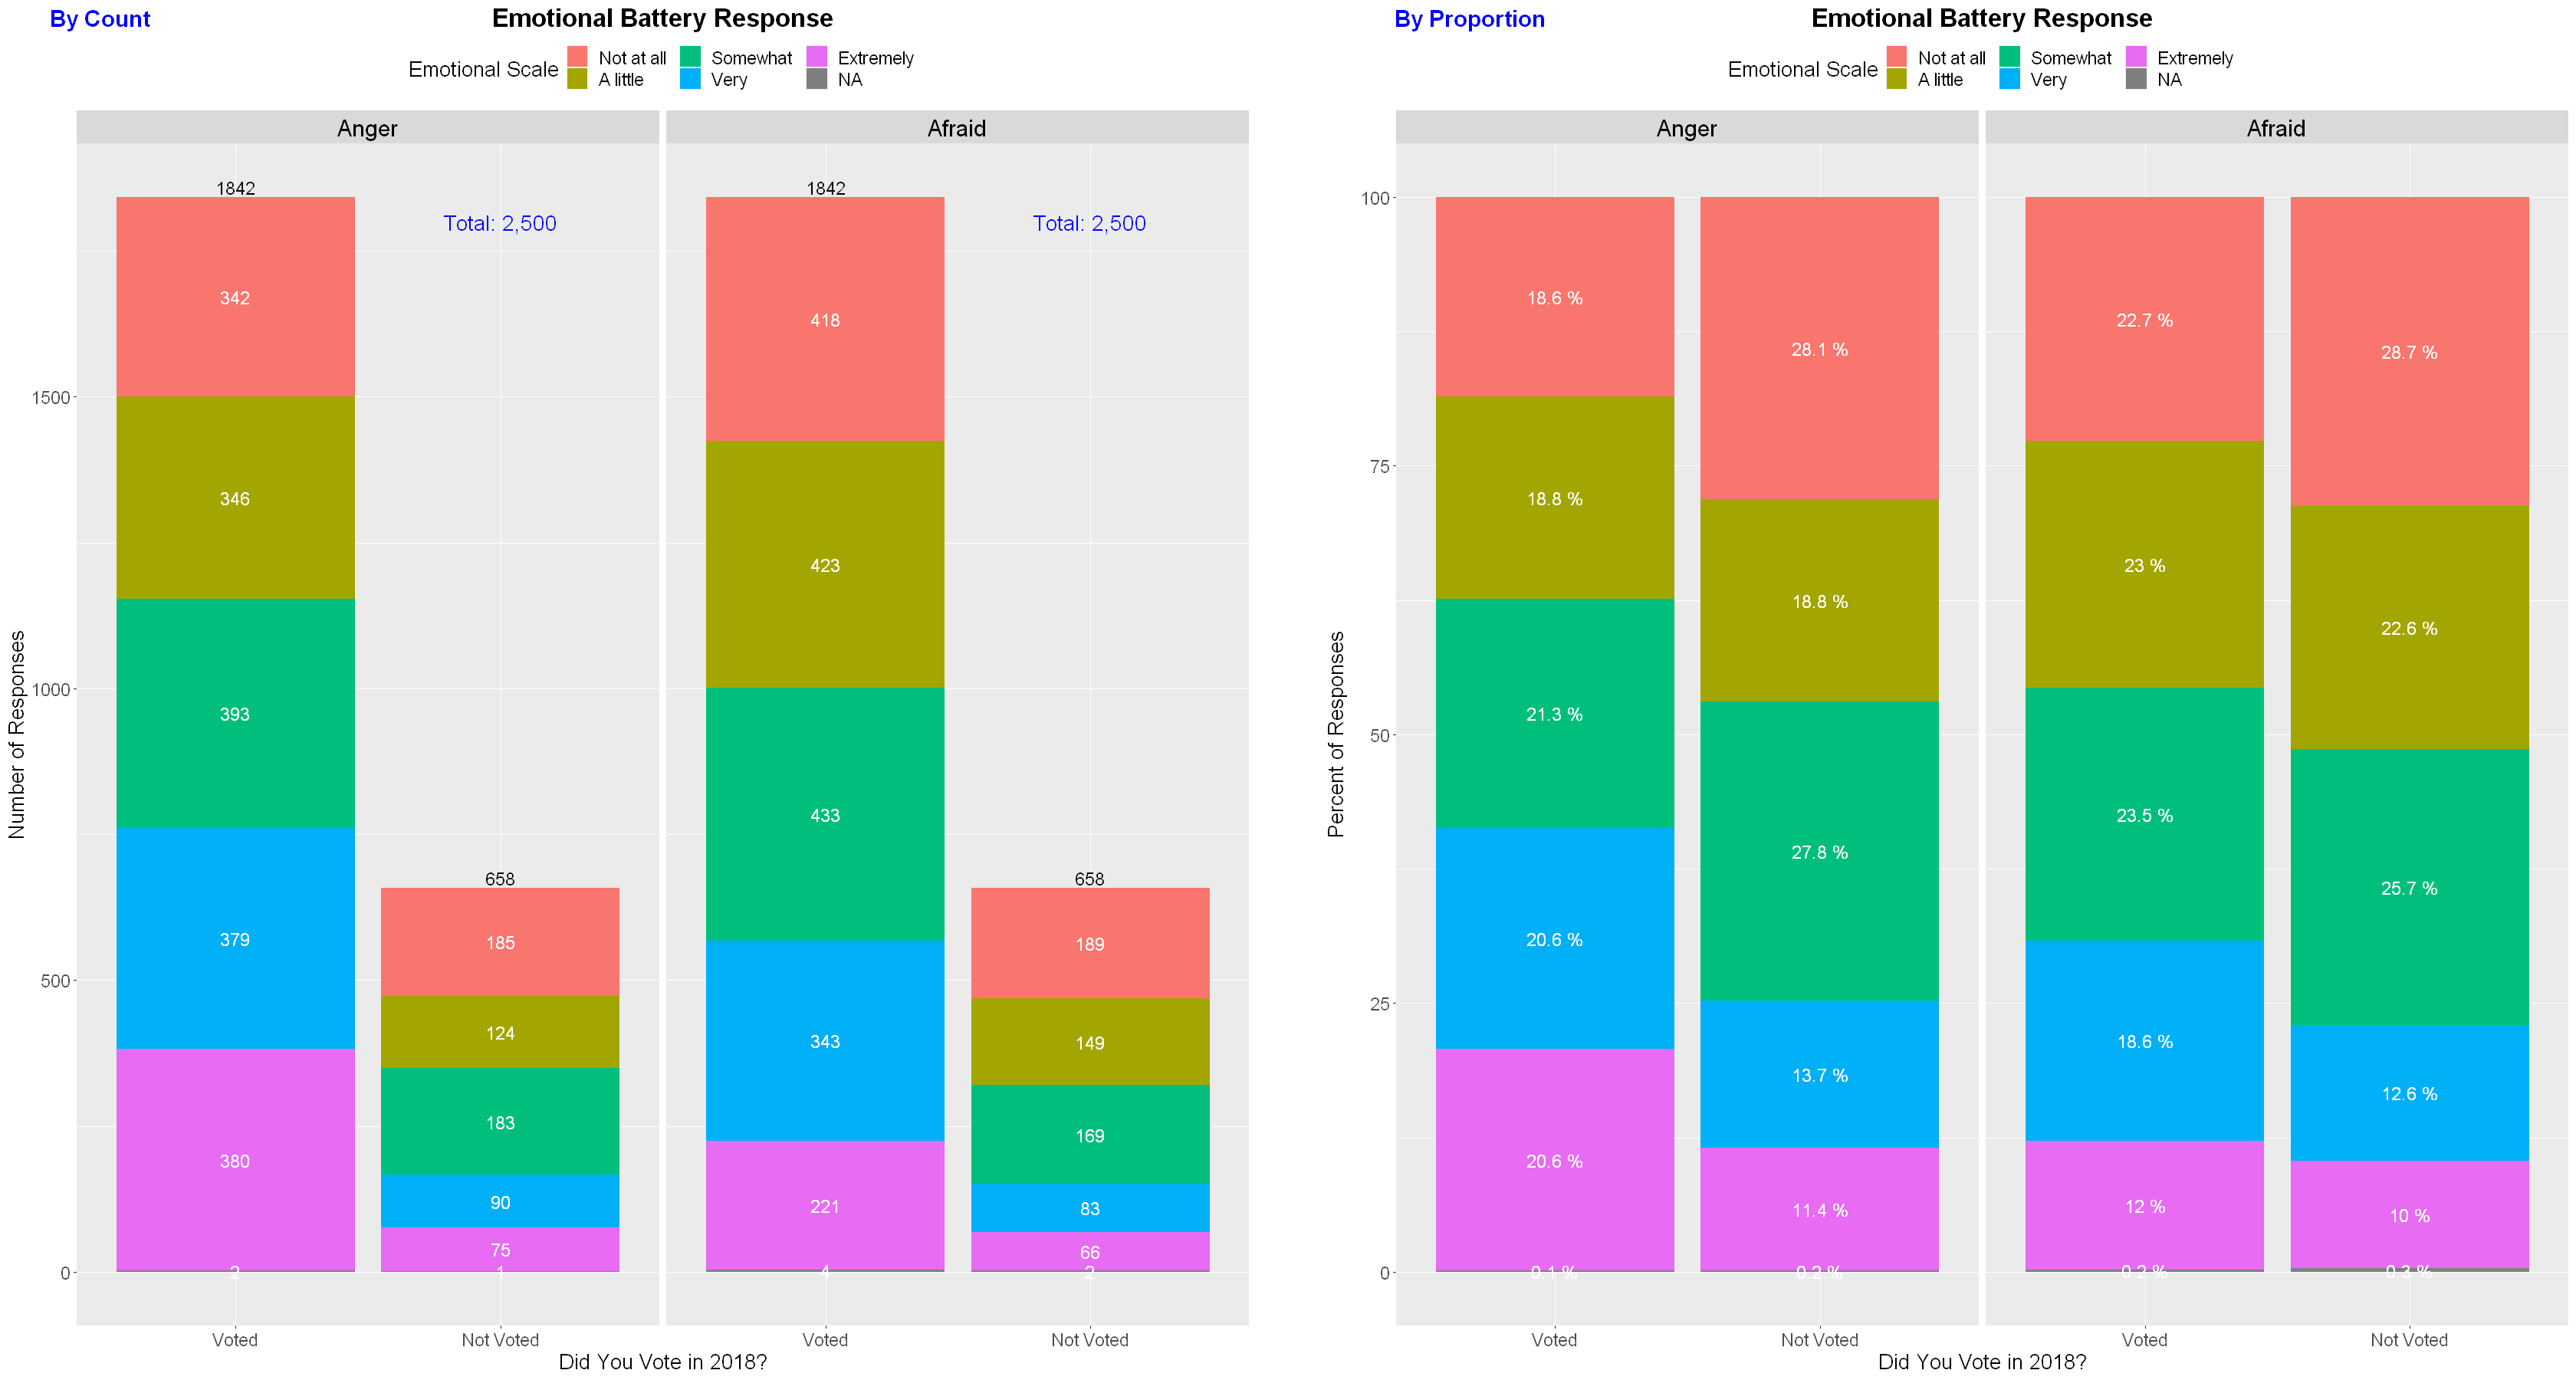

In [54]:
#Side by side plots of count and proportion
plot_grid(emo_c, NULL, emo_p, nrow = 1, align = "v", rel_widths = c(2, .1, 2), labels = c("By Count", "", "By Proportion"), label_size = 18, label_colour = "blue")

There were disproportionately more voters than non-voters in the 2018 election by almost a 3x factor. When we examine the scale of emotional response with respect to both anger and fear (afraid), it seems that voters were more emotionally charged than non-voters. For example, over 40% of voters said they felt extremely or very angry with the way things were going in 2018 while only 25% of non-voters felt the same way. 

Similarily, over 30% voters stated that they were extremely or very fearful of how things were in 2018 while less than 23% of non-voters responded with the same emotional degree. 

Qualified voters who had an extreme representation of their emotional state were more compelled to vote in 2018.

### Based on your EDA, select an appropriate hypothesis test.  (5 points)

Due to the way the Emotional Battery Response data are formatted (i.e. ordinal data and with factors), the assumptions of conventional parametric statistical analysis are often violated. Thus, we turn to the **Wilcoxon Ranked Sum (Mann–Whitney U) and chi-square test**. We believe the two-sample Wilcoxon Ranked Sum test to be appropriate for 4 reasons:

1. We are interested in knowing if anger or fear is different (higher or lower) between voters and non-voters 
2. Each observation in the sample is independent of one another
3. Dependent variable, sentiment rating, is of interval data type
4. Independent variable, voter status, is a factor with 2 levels or groups

#### Wilcoxon Ranked Sum test hypothese
 **Anger**

Null hypothesis:
- $H_{0}: \mu_{voterAnger} = \mu_{nonVoterAnger}$; The two groups are sampled from populations with identical distributions and there is no difference in values between voters and non-voters with respect to the anger sentiment
 
Alternative hypothesis:
 - $H_{a}: \mu_{voterAnger} \ne \mu_{nonVoterAnger}$; The two groups are sampled from populations with different distributions and there is a difference in values between voters and non-voters with respect to the anger sentiment

**Fear (Afraid)**

Null hypothesis:
- $H_{0}: \mu_{voterFear} = \mu_{nonVoterFear}$; The two groups are sampled from populations with identical distributions and there is no difference in values between voters and non-voters with respect to the fear sentiment
 
Alternative hypothesis:
 - $H_{a}: \mu_{voterFear} \ne \mu_{nonVoterFear}$; The two groups are sampled from populations with different distributions and there is a difference in values between voters and non-voters with respect to the fear sentiment

Additionally, since we are dealing with categorical variables, the chi-square test of independence is the most approriate. Specifically, we will use the chi-square test to conduct two separate tests to determine if there are any significant relationships between either emotion of interest (anger and fear) with voter turnout in 2018. The chi-square tests will be used to  used to compare the distribution our categorical variables  of anger and fear in a sample . If the distribution of the anger or fear is not much different over different groups (voters and non-voters), we can conclude the distribution of the anger and fear categorical variables are not related to the different groups. Or we can say the categorical variable and groups are independent. In the event that both anger and fear are related to either groups, then we will use the effect size to determine which emotion is more influential. Thus, there are 2 chi-square tests that we will conduct one for each emotion variable.

#### Chi-squre test hypothese
**Anger**

Null hypothesis:

- $H_0{anger}:$ Distribution of responses for both voters and non-voters are those stated in the percent column of df_anger; no association between anger and voter turnout

Alternative hypothesis:

- $H_a{anger}:$ Distribution of responses for both voters and non-voters are dffierent than those stated in the percent column of df_anger; association between anger and voter turnout

**Fear (Afraid)**

Null hypothesis:

- $H_0{fear}:$ Distribution of responses for both voters and non-voters are those stated in the percent column of df_afraid; no association between fear and voter turnout

Alternative hypothesis:

- $H_a{fear}:$ Distribution of responses for both voters and non-voters are dffierent than those stated in the percent column of df_afraid; association between fear and voter turnout

### Conduct your test. (5 points)

### Wilcoxon Ranked Sum test (Mann–Whitney U)

In [55]:
A4a = data.frame(A)

In [56]:
df_w = select(A4a, geangry, geafraid, turnout18)
names(df_w)[names(df_w) == "geangry"] = "anger" #renames geangry to anger
names(df_w)[names(df_w) == "geafraid"] = "afraid" #renames geafraid to fear
names(df_w)[names(df_w) == "turnout18"] = "voted18" #renames turnout18 to voted18
df_w$voted18 = ifelse(df_w$voted18 %in% 1:3, "Voted", "Not Voted" )
head(df_w)

,anger,afraid,voted18
,<int>,<int>,<chr>
1,2,2,Voted
2,3,5,Not Voted
3,3,2,Not Voted
4,1,1,Not Voted
5,2,3,Voted
6,3,3,Voted


In [57]:
#fear vs. anger Wilcoxon ranked sum test
#two sided test indicate there is a difference in the distribution between the 2 emotions, regardless of voting status
#one sided test indicate afraid's distribution is not greater than anger (i.e. anger is more influential overall)
df_long = df_w %>% gather(emo_type, rating, 1:2)

df_long %>% wilcox_test(rating ~ emo_type, paired = TRUE, detailed = TRUE, alternative = "two.sided") %>% add_significance() #are the sentiments different between fear and anger?
df_long %>% wilcox_test(rating ~ emo_type, paired = TRUE, detailed = TRUE, alternative = "less") %>% add_significance() #is the fear score higher than that of anger?

estimate,.y.,group1,group2,n1,n2,statistic,p,conf.low,conf.high,method,alternative,p.signif
<dbl>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
-0.4999902,rating,afraid,anger,2500,2500,325495,4.06e-26,-0.5000077,-0.4999283,Wilcoxon,two.sided,****


estimate,.y.,group1,group2,n1,n2,statistic,p,conf.low,conf.high,method,alternative,p.signif
<dbl>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
-0.4999902,rating,afraid,anger,2500,2500,325495,2.03e-26,-Inf,-0.4999965,Wilcoxon,less,****


In [58]:
#fear vs. anger effect size
#small effect size
df_long %>% wilcox_effsize(rating ~ emo_type, paired = TRUE, detailed = TRUE)

,.y.,group1,group2,effsize,n1,n2,magnitude
,<chr>,<chr>,<chr>,<dbl>,<int>,<int>,<ord>
1,rating,afraid,anger,0.1989098,2500,2500,small


In [59]:
#anger vs. voter status Wilcoxon ranked sum test
#two sided test indicate there is a difference in the distribution between voter status with respect to anger
#one sided test indicate non-voters' anger distribution less than voter's anger distribution (i.e. anger is more influential among voters)

df_w %>% wilcox_test(anger ~ voted18, detailed = TRUE, alternative = "two.sided") %>% add_significance()
df_w %>% wilcox_test(anger ~ voted18, detailed = TRUE, alternative = "less") %>% add_significance()

estimate,.y.,group1,group2,n1,n2,statistic,p,conf.low,conf.high,method,alternative,p.signif
<dbl>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
-1.848827e-05,anger,Not Voted,Voted,658,1842,496768.5,2.24e-12,-0.9999474,-1.882954e-05,Wilcoxon,two.sided,****


estimate,.y.,group1,group2,n1,n2,statistic,p,conf.low,conf.high,method,alternative,p.signif
<dbl>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
-1.848827e-05,anger,Not Voted,Voted,658,1842,496768.5,1.12e-12,-Inf,-4.208257e-05,Wilcoxon,less,****


In [60]:
#anger vs. voter status effect size
#small effect size
df_w %>% wilcox_effsize(anger ~ voted18, detailed = TRUE)

,.y.,group1,group2,effsize,n1,n2,magnitude
,<chr>,<chr>,<chr>,<dbl>,<int>,<int>,<ord>
1,anger,Not Voted,Voted,0.1403743,658,1842,small


In [61]:
#comparing fear (afraid) against voters and non-voters
#two sided test indicate there is a difference in the distribution between voter status with respect to anger
#one sided test indicate non-voters' fear distribution less than voter's fear distribution (i.e. fear is more influential among voters)

df_w %>% wilcox_test(afraid ~ voted18, detailed = TRUE, alternative = "two.sided") %>% add_significance()
df_w %>% wilcox_test(afraid ~ voted18, detailed = TRUE, alternative = "less") %>% add_significance()

estimate,.y.,group1,group2,n1,n2,statistic,p,conf.low,conf.high,method,alternative,p.signif
<dbl>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
-5.007923e-05,afraid,Not Voted,Voted,658,1842,548633.5,0.000217,-2.363405e-05,-6.920132e-05,Wilcoxon,two.sided,***


estimate,.y.,group1,group2,n1,n2,statistic,p,conf.low,conf.high,method,alternative,p.signif
<dbl>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
-5.007923e-05,afraid,Not Voted,Voted,658,1842,548633.5,0.000109,-Inf,-3.888975e-05,Wilcoxon,less,***


In [62]:
#fear vs. voter status effect size
#small effect size
df_w %>% wilcox_effsize(afraid ~ voted18, detailed = TRUE)

,.y.,group1,group2,effsize,n1,n2,magnitude
,<chr>,<chr>,<chr>,<dbl>,<int>,<int>,<ord>
1,afraid,Not Voted,Voted,0.07395867,658,1842,small


Both anger and fear were influential among both voters and non-voters (via individual emotion vs. voting status tests). But when we compared the distribution of the 2 emotions together, agnostic of voting status, anger elicited a higher degree of response than fear.

### Chi-Square test

In [258]:
#setting up the wide format of df_anger to prep for chi-square test (association between anger and 2018 voter turnout)
df_a = select(df_angry, voted18, scale, count)
df_a = spread(df_a, voted18, count)
df_a = head(df_a, -1) #remove "NA" row from analysis

df_a

scale,Voted,Not Voted
<ord>,<int>,<int>
Not at all,342,185
A little,346,124
Somewhat,393,183
Very,379,90
Extremely,380,75


In [259]:
#anger vs. turnout chi-square test and analysis
anger_chi = chisq.test(as.matrix(df_a[, -1]))
anger_chi


	Pearson's Chi-squared test

data:  as.matrix(df_a[, -1])
X-squared = 64.806, df = 4, p-value = 2.827e-13


anger_scale,Voted,Not Voted
<chr>,<dbl>,<dbl>
1-Not at all,-2.35,3.94
2-A little,-0.02,0.03
3-Somewhat,-1.53,2.55
4-Very,1.80,-3.01
5-Extremely,2.44,-4.09


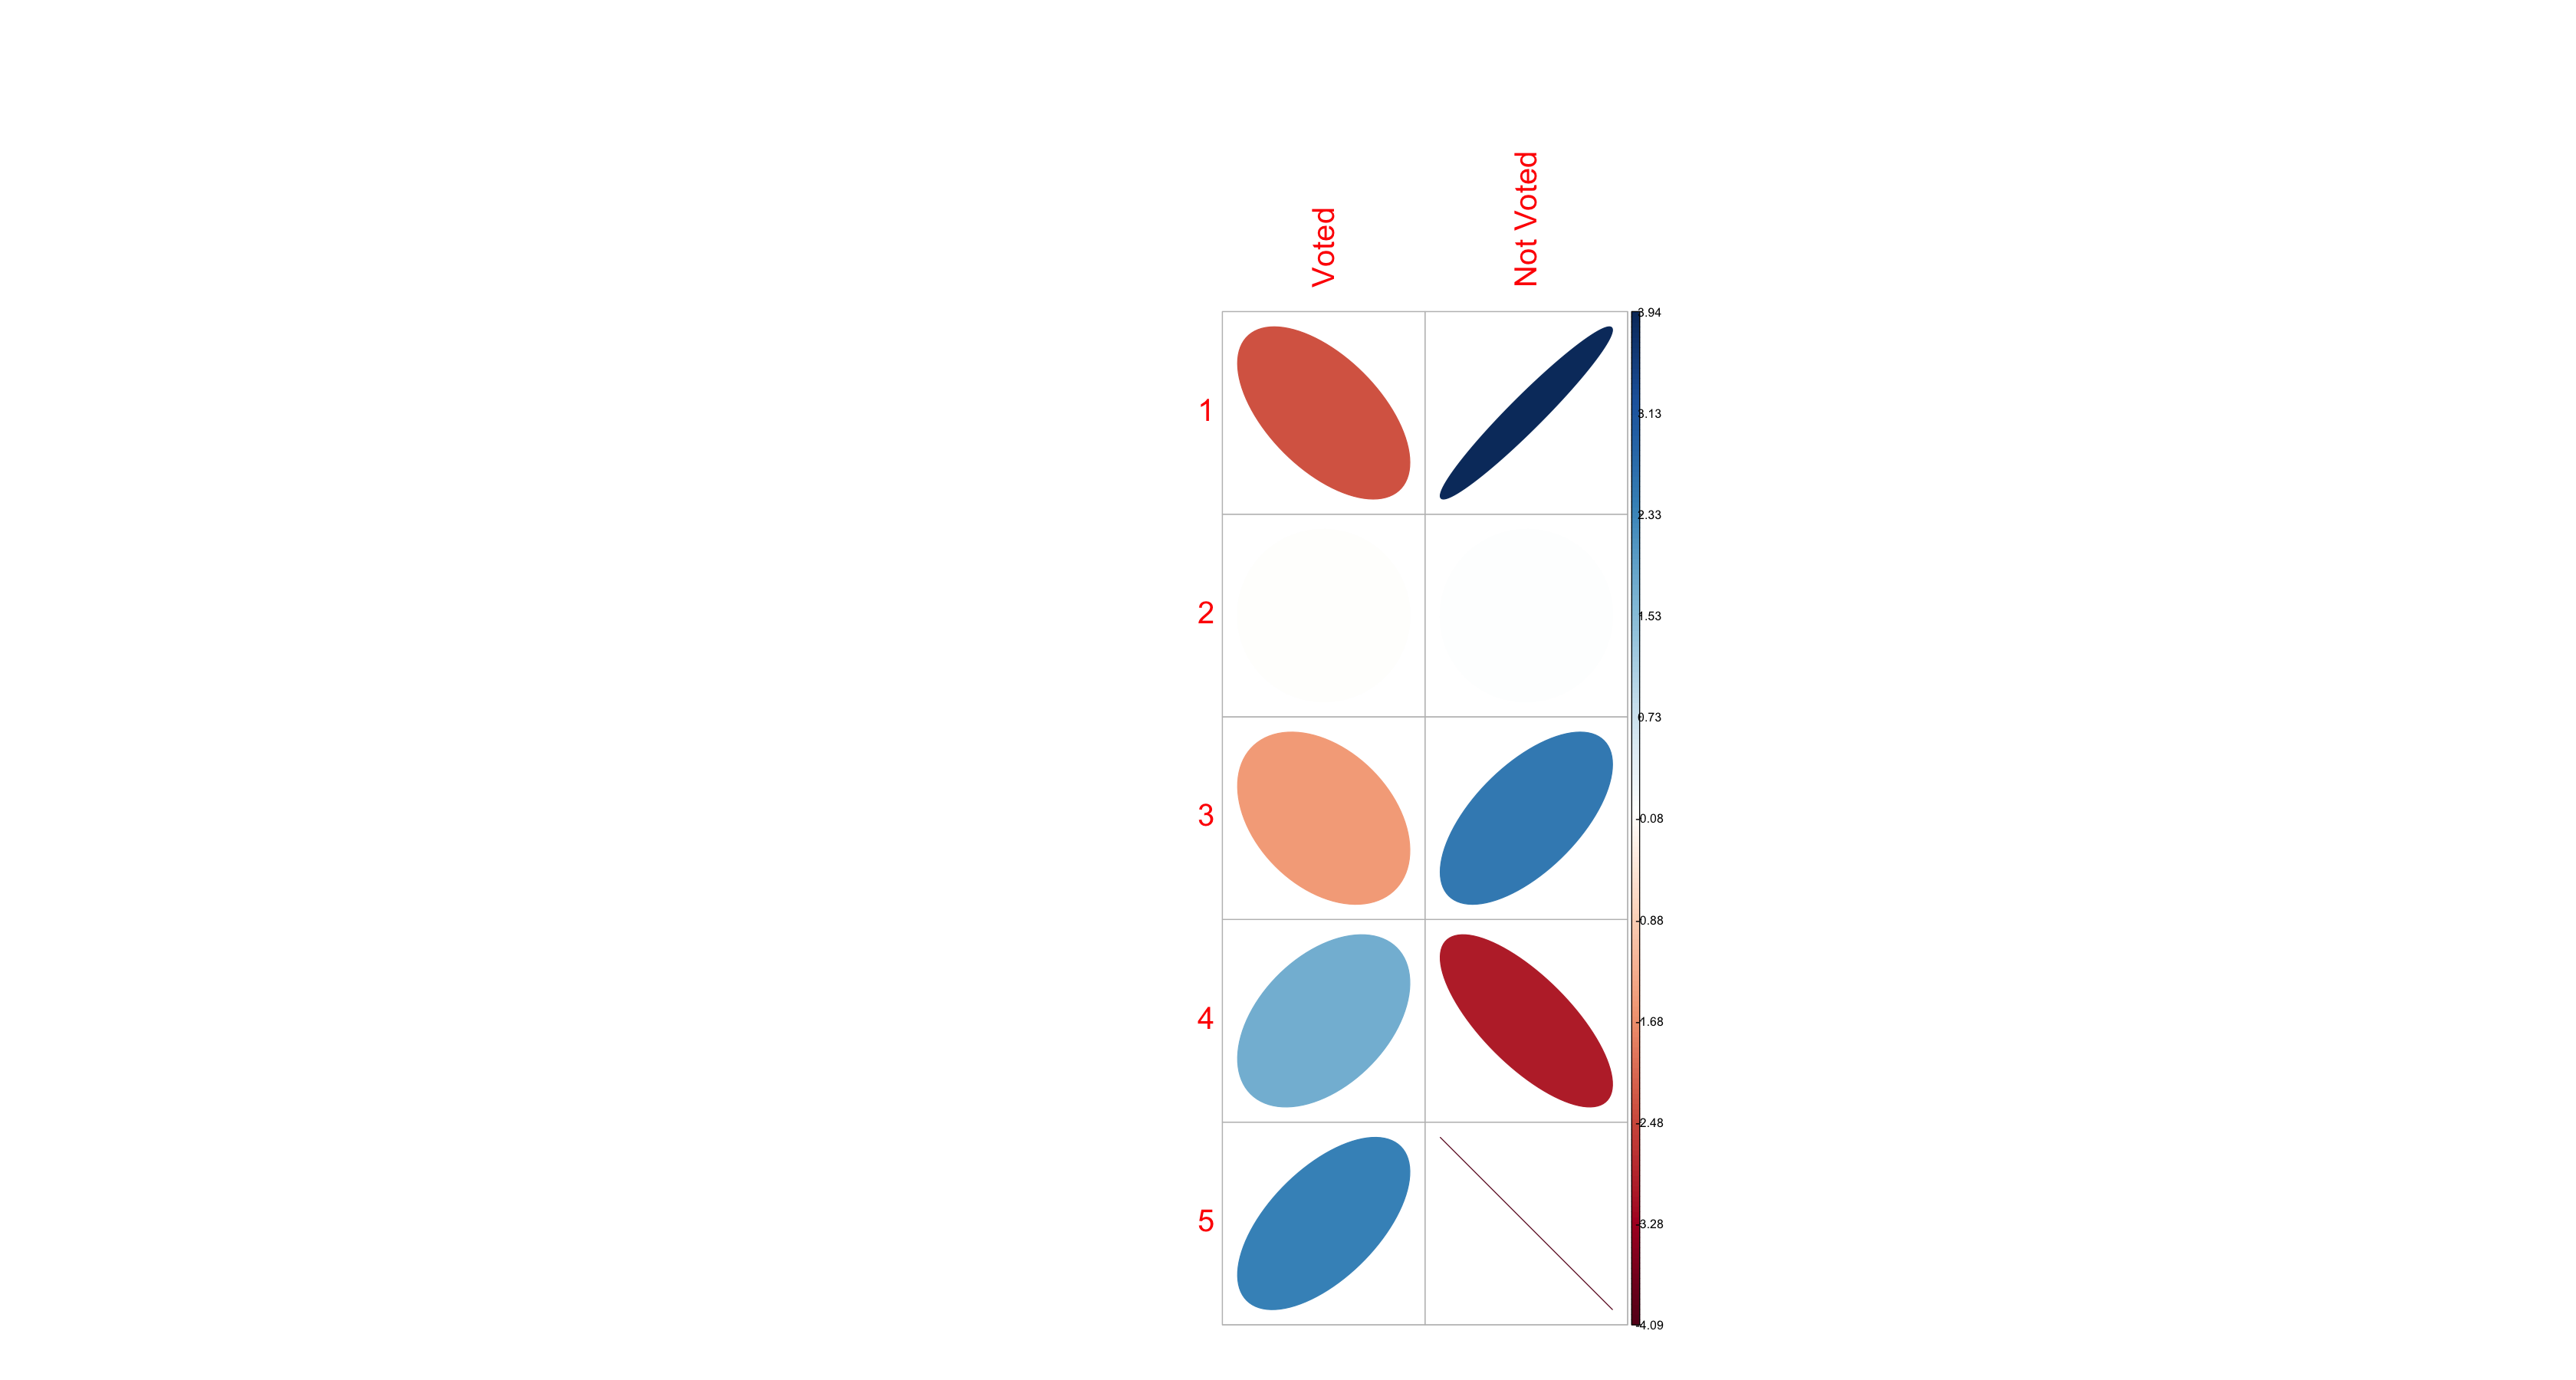

In [265]:
#anger chi square residuals
anger_chi_res = as.data.frame(round(anger_chi$residuals,2))
anger_chi_res$anger_scale = c("1-Not at all", "2-A little", "3-Somewhat", "4-Very", "5-Extremely")
anger_chi_res = anger_chi_res[c(3,1,2)]
anger_chi_res

corrplot(anger_chi$residuals, is.cor = FALSE, method="ellipse", tl.cex = 2)

The residuals tell us the most contributing cells to the total Chi-square score, which is also visualized in a plot by the size of the circle. The sign of the standardized residuals is important to interpret the association between fear scale and voting participation group. 
- **Positive Residuals:** Positive values specify an attraction (positive association) between the each anger scale and each of the voter/non-voter group. This is shown as blue in the plot.
    - In the plot above, we can see that voters have a strong positive associaton with "very" and "extreme" rating of anger 
- **Negative Residuals:** Negative values specify a repulsion (negative association) between the each anger scale and each of the voter/non-voter group. This is shown as red in the plot.
    - In the plot above, we can see that non-voters have a strong negative associaton with "very" and "extreme" rating of anger while they have a strong positive association with no fear (Not at all)

In [249]:
#setting up the wide format of df_fear to prep for chi-square test (association between fear and 2018 voter turnout)
df_f = select(df_afraid, voted18, scale, count)
df_f = spread(df_f, voted18, count)
df_f = head(df_f, -1) #remove "NA" row from analysis

df_f

scale,Voted,Not Voted
<ord>,<int>,<int>
Not at all,418,189
A little,423,149
Somewhat,433,169
Very,343,83
Extremely,221,66


In [250]:
#fear vs. turnout chi-square test and analysis
fear_chi = chisq.test(as.matrix(df_f[, -1]))
fear_chi


	Pearson's Chi-squared test

data:  as.matrix(df_f[, -1])
X-squared = 20.147, df = 4, p-value = 0.0004671


fear_scale,Voted,Not Voted
<chr>,<dbl>,<dbl>
1-Not at all,-1.39,2.32
2-A little,0.07,-0.12
3-Somewhat,-0.51,0.85
4-Very,1.64,-2.74
5-Extremely,0.65,-1.09


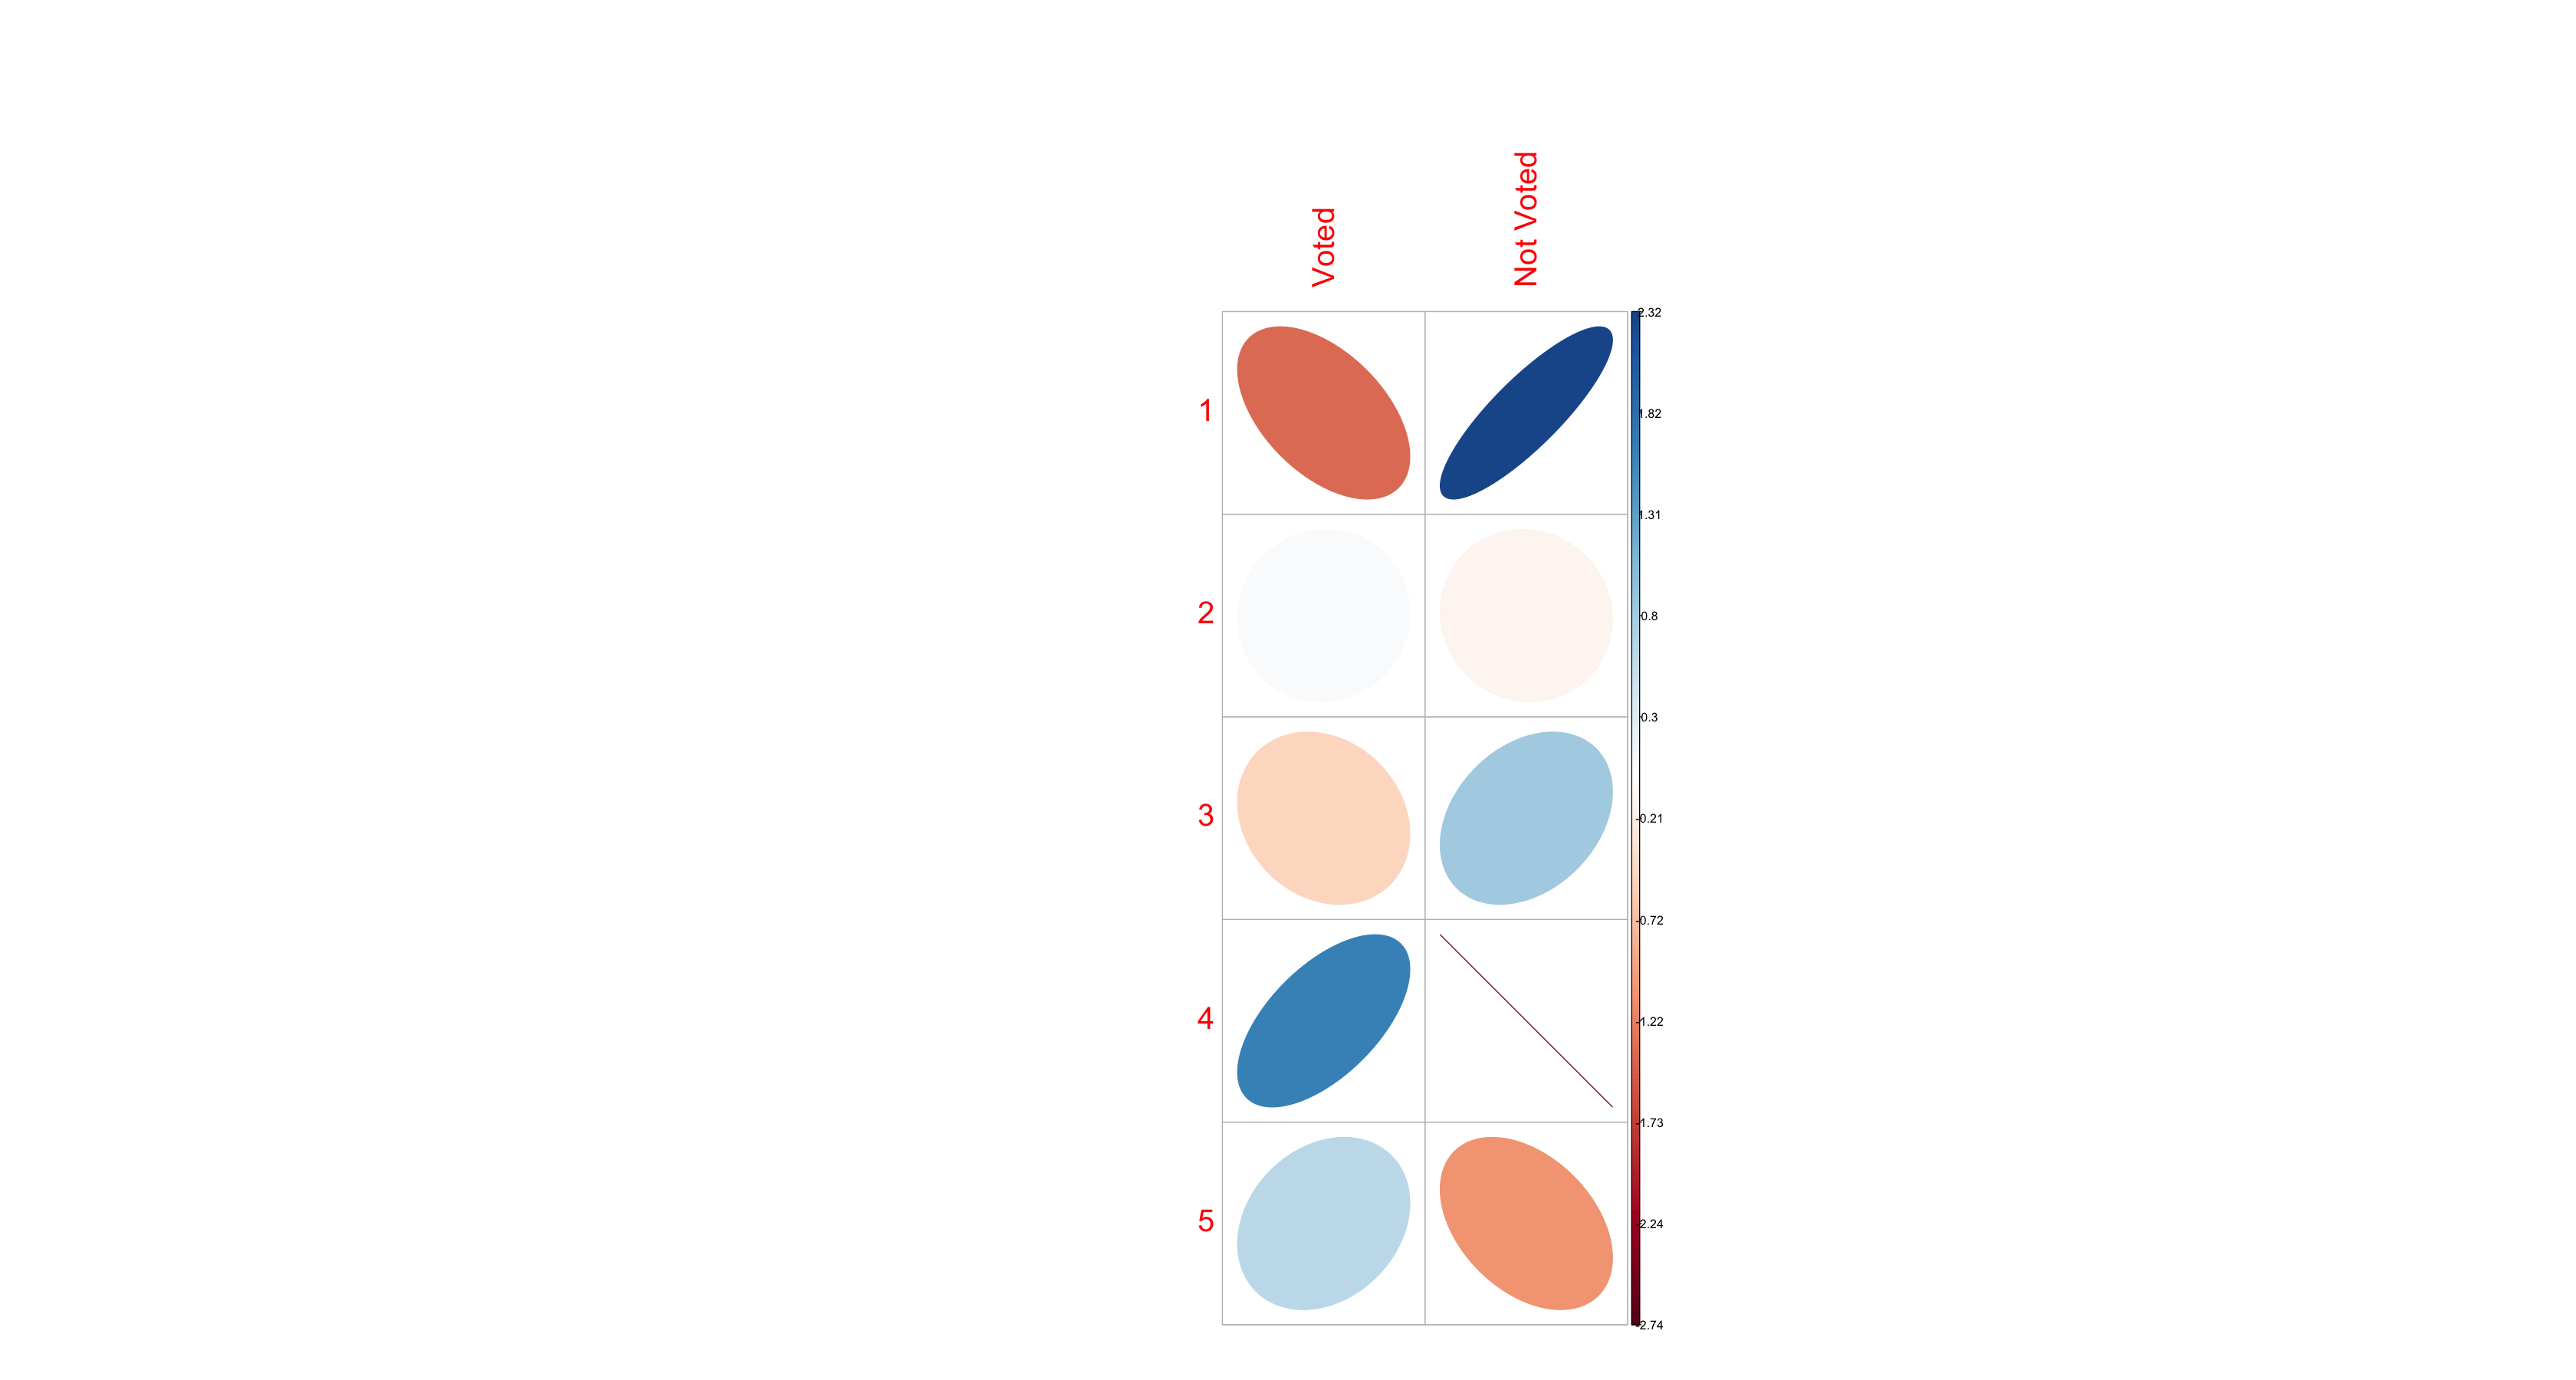

In [263]:
#fear chi square residuals
fear_chi_res = as.data.frame(round(fear_chi$residuals,2))
fear_chi_res$fear_scale = c("1-Not at all", "2-A little", "3-Somewhat", "4-Very", "5-Extremely")
fear_chi_res = fear_chi_res[c(3,1,2)]
fear_chi_res

corrplot(fear_chi$residuals, 
         is.cor = FALSE, 
         method = "ellipse",
         tl.cex = 2,
)

Similar to the previous anger chi-square test, we observe an identical pattern in terms of association with fear, but to a lesser degree:
- **Voters:** In the plot above, there is a strong positive association with "very" rating of fear and a moderate association with the "extreme" rating of fear
- **Non-Voters:** In the plot above, there is a strong positive association with the no fear (Not at all) rating and a strong disassociation with the "very" and "extreme" fear rating

To assess for practical significance or the effect size of the chi-square tests, there are 3 options at our disposal:
1. Cramer's V
2. Phi ($\phi$)
3. Odds ratio (OR) 

For the goodness of fit in 2 × 2 contingency tables, Phi is appropriate as it's equivalent to the correlation coefficient r, and a measure of effect size. However, our dataset is a not a 2x2 contingency table. Thus, we decided to leverage Cramer's V to assess for practical significance, which can be characterized in the equation below. We also referenced this [article from the National Center for Biotechnology Information](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5426219/).

$$V = \sqrt{\frac{\chi^2}{n * df}}$$ 
df = min(r – 1, c – 1) and r = number of rows and c = number of columns in the contingency table.

We will also be using the below table to interpret the computed effect size (based on Jacob Cohen's [Statistical Power Analysis for the Behavioral Sciences](https://books.google.com/books?hl=en&lr=&id=rEe0BQAAQBAJ&oi=fnd&pg=PP1&ots=sv0TKsMPs6&sig=Rpfkd0H-EB0-ZhKjsdDdSDgTdx4#v=onepage&q&f=false)): 

|df   |Small   |Medium   |Large   |
|---|---|---|---|
|1  |.10   |.30   |.50   |
|2 |.07   |.21   |.35   |
|3   |.06   |.17   |.29   |
|4   |.05   |.15   |.25   |
|5   |.04   |.13   |.22   |

In [69]:
#anger effect size
Cramers_V <- function(chi, n, df) round(sqrt((as.numeric(chi))/(n * df)),3) #custom Cramers_V function

df = min(dim(df_a)) - 1 #degrees of freedom; min(r – 1, c – 1) and r = number of rows and c = number of columns in the contingency table.
paste("Degree of freedom is:", df)

anger_effect = Cramers_V(chi = anger_chi$statistic, n = sum(colSums(df_a[,-1])), df = df) #V value calculation
paste("Anger V-value:", anger_effect)

[1] "Degree of freedom is: 2"

[1] "Anger V-value: 0.114"

In [70]:
#fear effect size
df2 = min(dim(df_f)) - 1 #degrees of freedom; min(r – 1, c – 1) and r = number of rows and c = number of columns in the contingency table.
paste("Degree of freedom is:", df)

fear_effect = Cramers_V(chi = fear_chi$statistic, n = sum(colSums(df_f[,-1])), df = df2) #V value calculation
paste("Fear V-value:", fear_effect)

[1] "Degree of freedom is: 2"

[1] "Fear V-value: 0.064"

#### Q4 Results Interpretation
- **Statistical significance:** Because the Wilcoxon Ranked sum tests for both anger and fear returned extremely small p-value when compared between voters and non-voters, we can reject the null hypothesis and claim that the sentiment for both emotions were of a higher degree among voters rather than non-voters (by examining both the two-sided and less than tests for each emotion). Furthermore,the chi-square test also returned extremely small p-value, which provides evidence and confidence we can reject the null hypothesis and support the alternative hypothesis in which both emotions were influential. Similarily, the chi-square residuals also indicate that voters tended to have more extreme ratings of both anger and fear when compared against non-voters. 

- **Practical significance:** Because the r (Wilcoxon Ranked sum test) the V (chi_square) value for both emotions are quite small, neither of them are practically significant. However, because anger's effect value (both r and V) is higher than fear, anger seems to be more influential with respect to voter turnout.

In conclusion, both the Wilcoxon Ranked sum and chi-square tests indicate that if you want people to show up at the ballot box, anger is a compelling impetus.

## Question 5: Select a fifth question that you believe is important for understanding the behavior of voters

>Is there a difference in racial favorability between self-identified Democrats and Republicans on people of non-Caucasian descent?

Voter behavior is a complex topic often fueled with emotional and latent biases. We are interested in voters' sentiment towards people of non-Caucasian descent and if there are substantial differences between self-identified Republicans and Democrats. 

We also aim to identify the minority group among those surveyed that exhibit the largest contrast in favorability score between Republican and Democratic respondents. 

We hope this analysis can fuel further research in systematic racism and the role political parties play in distributing and shaping such beliefs in the minds of American people.

We will perform the below analysis in order to gain a better understanding of the racial profile of the sample. Specifically:
- We want to understand the racial makeup of self-identified Democrats and Republicans that partook in the survey, since a dominant race in any group can optimize for one's own interest (i.e. give higher rating score to one's own race) while minimizing minority groups  
- We want to visually inspect the score distribution of each race between Democrats and Republicans and observe any large differences where it could lead to divergent feelings
- We want to identify potential races that we hypothesize could be statisitically and practically significant between the 2 political parties, so we can conduct the approriate testings at the individual race level

 **Data**
- Party affliation: We will operationalize "pid1d" and "pid1r" variables to identify each respondent's political party (exclude no answers, legitimate skips and all non-Democrat and Republican respondents)
- Race: We will identify each respondent's race through the "race" variable
- Racial sentiment scores: We will operationalize ftblack (blacks), ftasian (Asians), fthisp (Hispanics), ftmuslim (Muslims), and ftwhite (whites) to extract the sentiment scores. The specific question and score scale is described below.

**Question format:** How would you rate (blacks, Hispanics, Asians, Muslims)?

**Hypothesis Testing**

We believe a two sided, two sample T-test is appropriate for 4 reasons:

1. We're interested in knowing whether there is a difference between 2 groups (self-professed Republicans and Democrats)
2. Each observation is a random sample (independently and identically distributed) from the population meaning that each observation is independent of one another
4. We have over 600 observations for each party, well over the n > 30 minimum requirement to invoke the Central Limit Theorem
5. The dependent variable, sentiment score, is interval

Thus, we will conduct an independent two-sample T-test to determine if the mean difference of racial sentiment scores for non-Caucasians between self-identified Republicans and Democrats are statistically significant or not.

Null hypothesis:
 - $H_{0}: \mu_{DemocratRace} = \mu_{RepublicanRace}$; there is no difference in mean racial sentiment score of non-Caucasians between Democrats and Republicans
 
Alternative hypothesis:
 - $H_{a}: \mu_{DemocratRace} \ne \mu_{RepublicanRace}$; there is a difference in mean racial sentiment score of non-Caucasians between Democrats and Republicans

### Perform EDA and select your hypothesis test (5 points)

In [266]:
#create a copy of the original dataframe
A5 = data.frame(A)

In [243]:
#create dataframe with race and pid1d variables
race_d = select(A, race, pid1d)
race_d = race_d[!(race_d$pid1d == -7 | race_d$pid1d == -1 | race_d$pid1d == 4),] #removes no answer, legit skips and something else from pid1d
names(race_d)[names(race_d) == "pid1d"] = "party"

#unique(race_d$party)
head(race_d)

,race,party
,<int>,<int>
1,1,2
4,3,3
10,3,1
11,1,1
12,1,2
14,1,1


In [244]:
#create dataframe with race and pid1r variables
race_r = select(A, race, pid1r)
race_r = race_r[!(race_r$pid1r == -7 | race_r$pid1r == -1 | race_r$pid1r == 4),]
names(race_r)[names(race_r) == "pid1r"] = "party"

#unique(race_d$party)
head(race_r)

,race,party
,<int>,<int>
2,1,2
3,6,3
5,1,2
6,3,1
7,1,3
8,1,2


In [245]:
#combine df_muel_r and df_muel_d
race_c = rbind(race_d, race_r)
race_c = race_c[!(race_c$race == -7 | race_c$race == -1),]
race_c$party = factor(race_c$party, levels = 1:3, labels = c("Democrat", "Republican", "Independent"))
race_c$race = factor(race_c$race, levels = 1:7, labels = c("White", "Black", "Hispanic", "Asian", "Native American", "Mixed", "Other"))

#unique(race_c$party)
#unique(race_c$race)
head(race_c)

,race,party
,<fct>,<fct>
1,White,Republican
4,Hispanic,Independent
10,Hispanic,Democrat
11,White,Democrat
12,White,Republican
14,White,Democrat


In [246]:
#convert race_c dataframe into long format with relative proportion by party
race_long = race_c %>%
    group_by(party, race) %>%
    tally() %>%
    mutate(percent = n / sum(n) * 100) %>%
    group_by(party)

names(race_long)[names(race_long) == "n"] = "count" #renames n to count
#sum(race_long$count)
head(race_long)

party,race,count,percent
<fct>,<fct>,<int>,<dbl>
Democrat,White,571,66.6277713
Democrat,Black,152,17.7362894
Democrat,Hispanic,95,11.0851809
Democrat,Asian,18,2.1003501
Democrat,Native American,2,0.2333722
Democrat,Mixed,16,1.8669778


In [76]:
#count of respondents' race by political party affliation
options(repr.plot.width = 24, repr.plot.height = 16)
race_count = ggplot(race_long, mapping = aes(x = party, y = count, fill = race)) +
    facet_grid() + 
    geom_col() +
    coord_flip() + 
    geom_text(aes(label = count, y = count), size = 5, position = position_stack(vjust = 0.5), color = "white") +
    stat_summary(fun = sum, aes(label = ..y.., group = party), size = 5, geom = "text", hjust = -.3) +
    annotate(geom = "text", x = 2, y = 800, label = "Total: 2,232", color = "blue", size = 7) +
    labs(title="Distribution of Respondent Race by Political Affliation (Self-Identified)", y = "Number of Responses", x = "Political Party") +
    theme(strip.text.x = element_text(size = 18, color = "black")) +
    scale_fill_discrete(name = "Race") + 
    plot_theme

In [77]:
#relative proportion of respondents' race by political party affliation
race_prop = ggplot(race_long, mapping = aes(x = party, y = percent, fill = race)) +
    facet_grid() + 
    geom_col() +
    coord_flip() + 
    geom_text(aes(label = paste(round(percent,0),"%")), size = 5, position = position_stack(vjust = 0.5), color = "white") +
    labs(title="Proportion of Respondent Race by Political Affliation (Self-Identified)", y = "Percent of Responses", x = "Political Party") +
    theme(strip.text.x = element_text(size = 18, color = "black")) +
    scale_fill_discrete(name = "Race") + 
    plot_theme

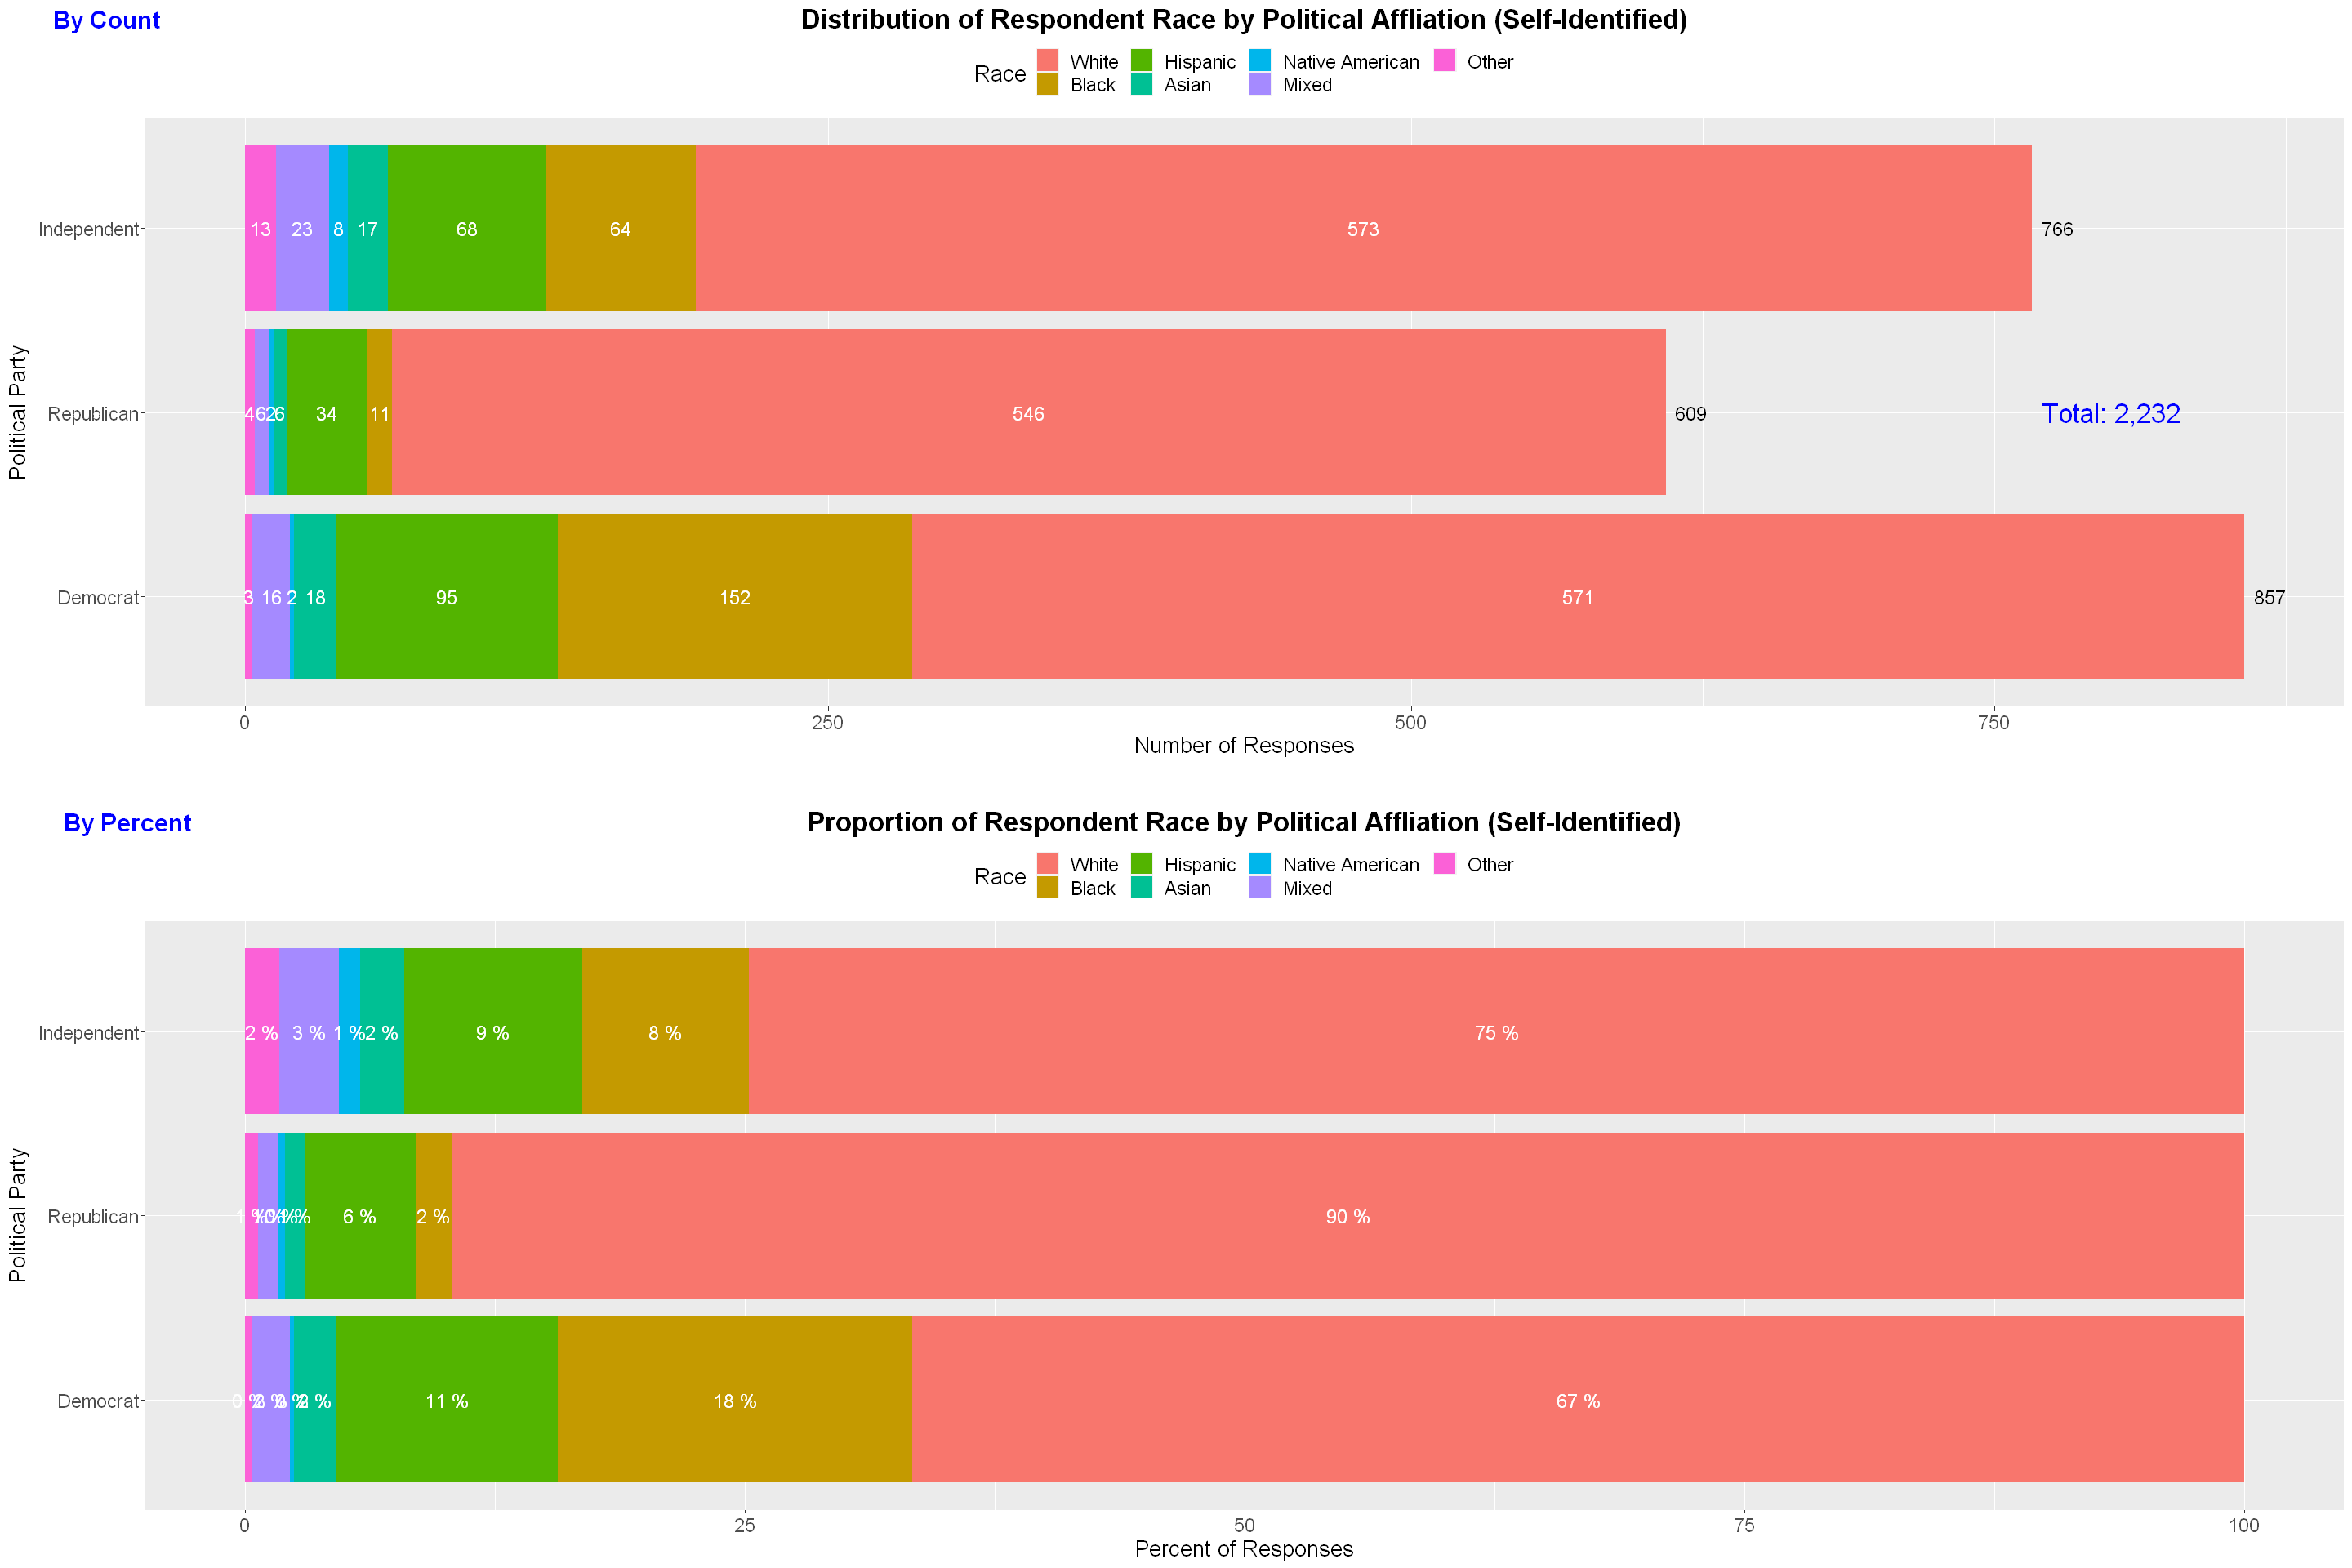

In [78]:
#Side by side plots of count and proportion
plot_grid(race_count, NULL, race_prop, ncol = 1, align = "h", rel_heights = c(2, .1, 2), labels = c("By Count", "", "By Percent"), label_size = 18, label_colour = "blue")

While white is the predominant race in each of the 3 parties, the least diversified race mixtures  resides with self-proclaimed Republicans and the most diversified lies with Democrats. 

Next, we will ignore each respondent's race and examine the relationship between the thermometer ratings of non-Caucasian races (blacks, Hispanics, Asians, and Muslims) and the 2 dominant political parties of the United States, Democratic and Republican. Ultimately, we would like to know whether if there is a substantial difference in the perception of non-Caucasians, especially given that both parties are predominantly white. Below is the question and response scale used in the survey.

In [271]:
#extract pid1d and response column for blacks (ftblack), Hispanics (fthisp), Asians (ftasian), Muslims (ftmuslim), and whites (ftwhite)
therm_d = select(A5, pid1d, ftblack, fthisp, ftasian, ftmuslim, ftwhite)
therm_d = therm_d[!(therm_d$pid1d == -7 | therm_d$pid1d == -1 | therm_d$pid1d == 3 | therm_d$pid1d == 4),] #removes no answer, legit skips and non Democrats and Republicans
colnames(therm_d) = c("party", "black", "hispanic", "asian", "muslim", "white") #rename column names

#extract pid1r and response column for blacks (ftblack), Hispanics (fthisp), Asians (ftasian), Muslims (ftmuslim), and whites (ftwhite)
therm_r = select(A5, pid1r, ftblack, fthisp, ftasian, ftmuslim, ftwhite)
therm_r = therm_r[!(therm_r$pid1r == -7 | therm_r$pid1r == -1 | therm_r$pid1r == 3 | therm_r$pid1r == 4),] #removes no answer, legit skips and non Democrats and Republicans
colnames(therm_r) = c("party", "black", "hispanic", "asian", "muslim", "white") #rename column names

#combine both dataframes
therma_wide = rbind(therm_d, therm_r)
therma_wide$party = factor(therma_wide$party, levels = 1:2, labels = c("Democrat", "Republican"))

#convert combined wide into long format
therma_long = therma_wide %>% gather(race, rating, "black", "hispanic", "asian", "muslim", "white")
therma_long = therma_long[!(therma_long$rating == -7),] #remove no responses
therma_long = transform(therma_long, group = ifelse(race == "white", "Caucasian", "Non-Caucasian"))
therma_long = therma_long[c(4,1,2,3)]

stopifnot(unique(therma_long$race) == c('black','hispanic','asian','muslim','white'))
stopifnot(nrow(therma_long) == 7326)
#head(therma_long)

In [276]:
#summary of count, mean, standard deviation, and standard error of the sample
sumdata = ddply(therma_long, c("party", "race"), summarize, count = length(rating), mean = round(mean(rating),2), median = median(rating),
               sd = round(sd(rating),2))
"Summary of party, race, count, mean, median and standard deviation of the sample"
sumdata

[1] "Summary of party, race, count, mean, median and standard deviation of the sample"

party,race,count,mean,median,sd
<fct>,<chr>,<int>,<dbl>,<dbl>,<dbl>
Democrat,asian,857,74.27,80.0,23.57
Democrat,black,857,79.91,86.0,21.08
Democrat,hispanic,857,77.31,84.0,22.81
Democrat,muslim,857,68.77,73.0,25.35
Democrat,white,857,67.04,70.0,23.67
Republican,asian,608,69.36,71.5,24.69
Republican,black,609,68.74,72.0,26.00
Republican,hispanic,607,65.12,70.0,27.29
Republican,muslim,609,36.71,39.0,28.10


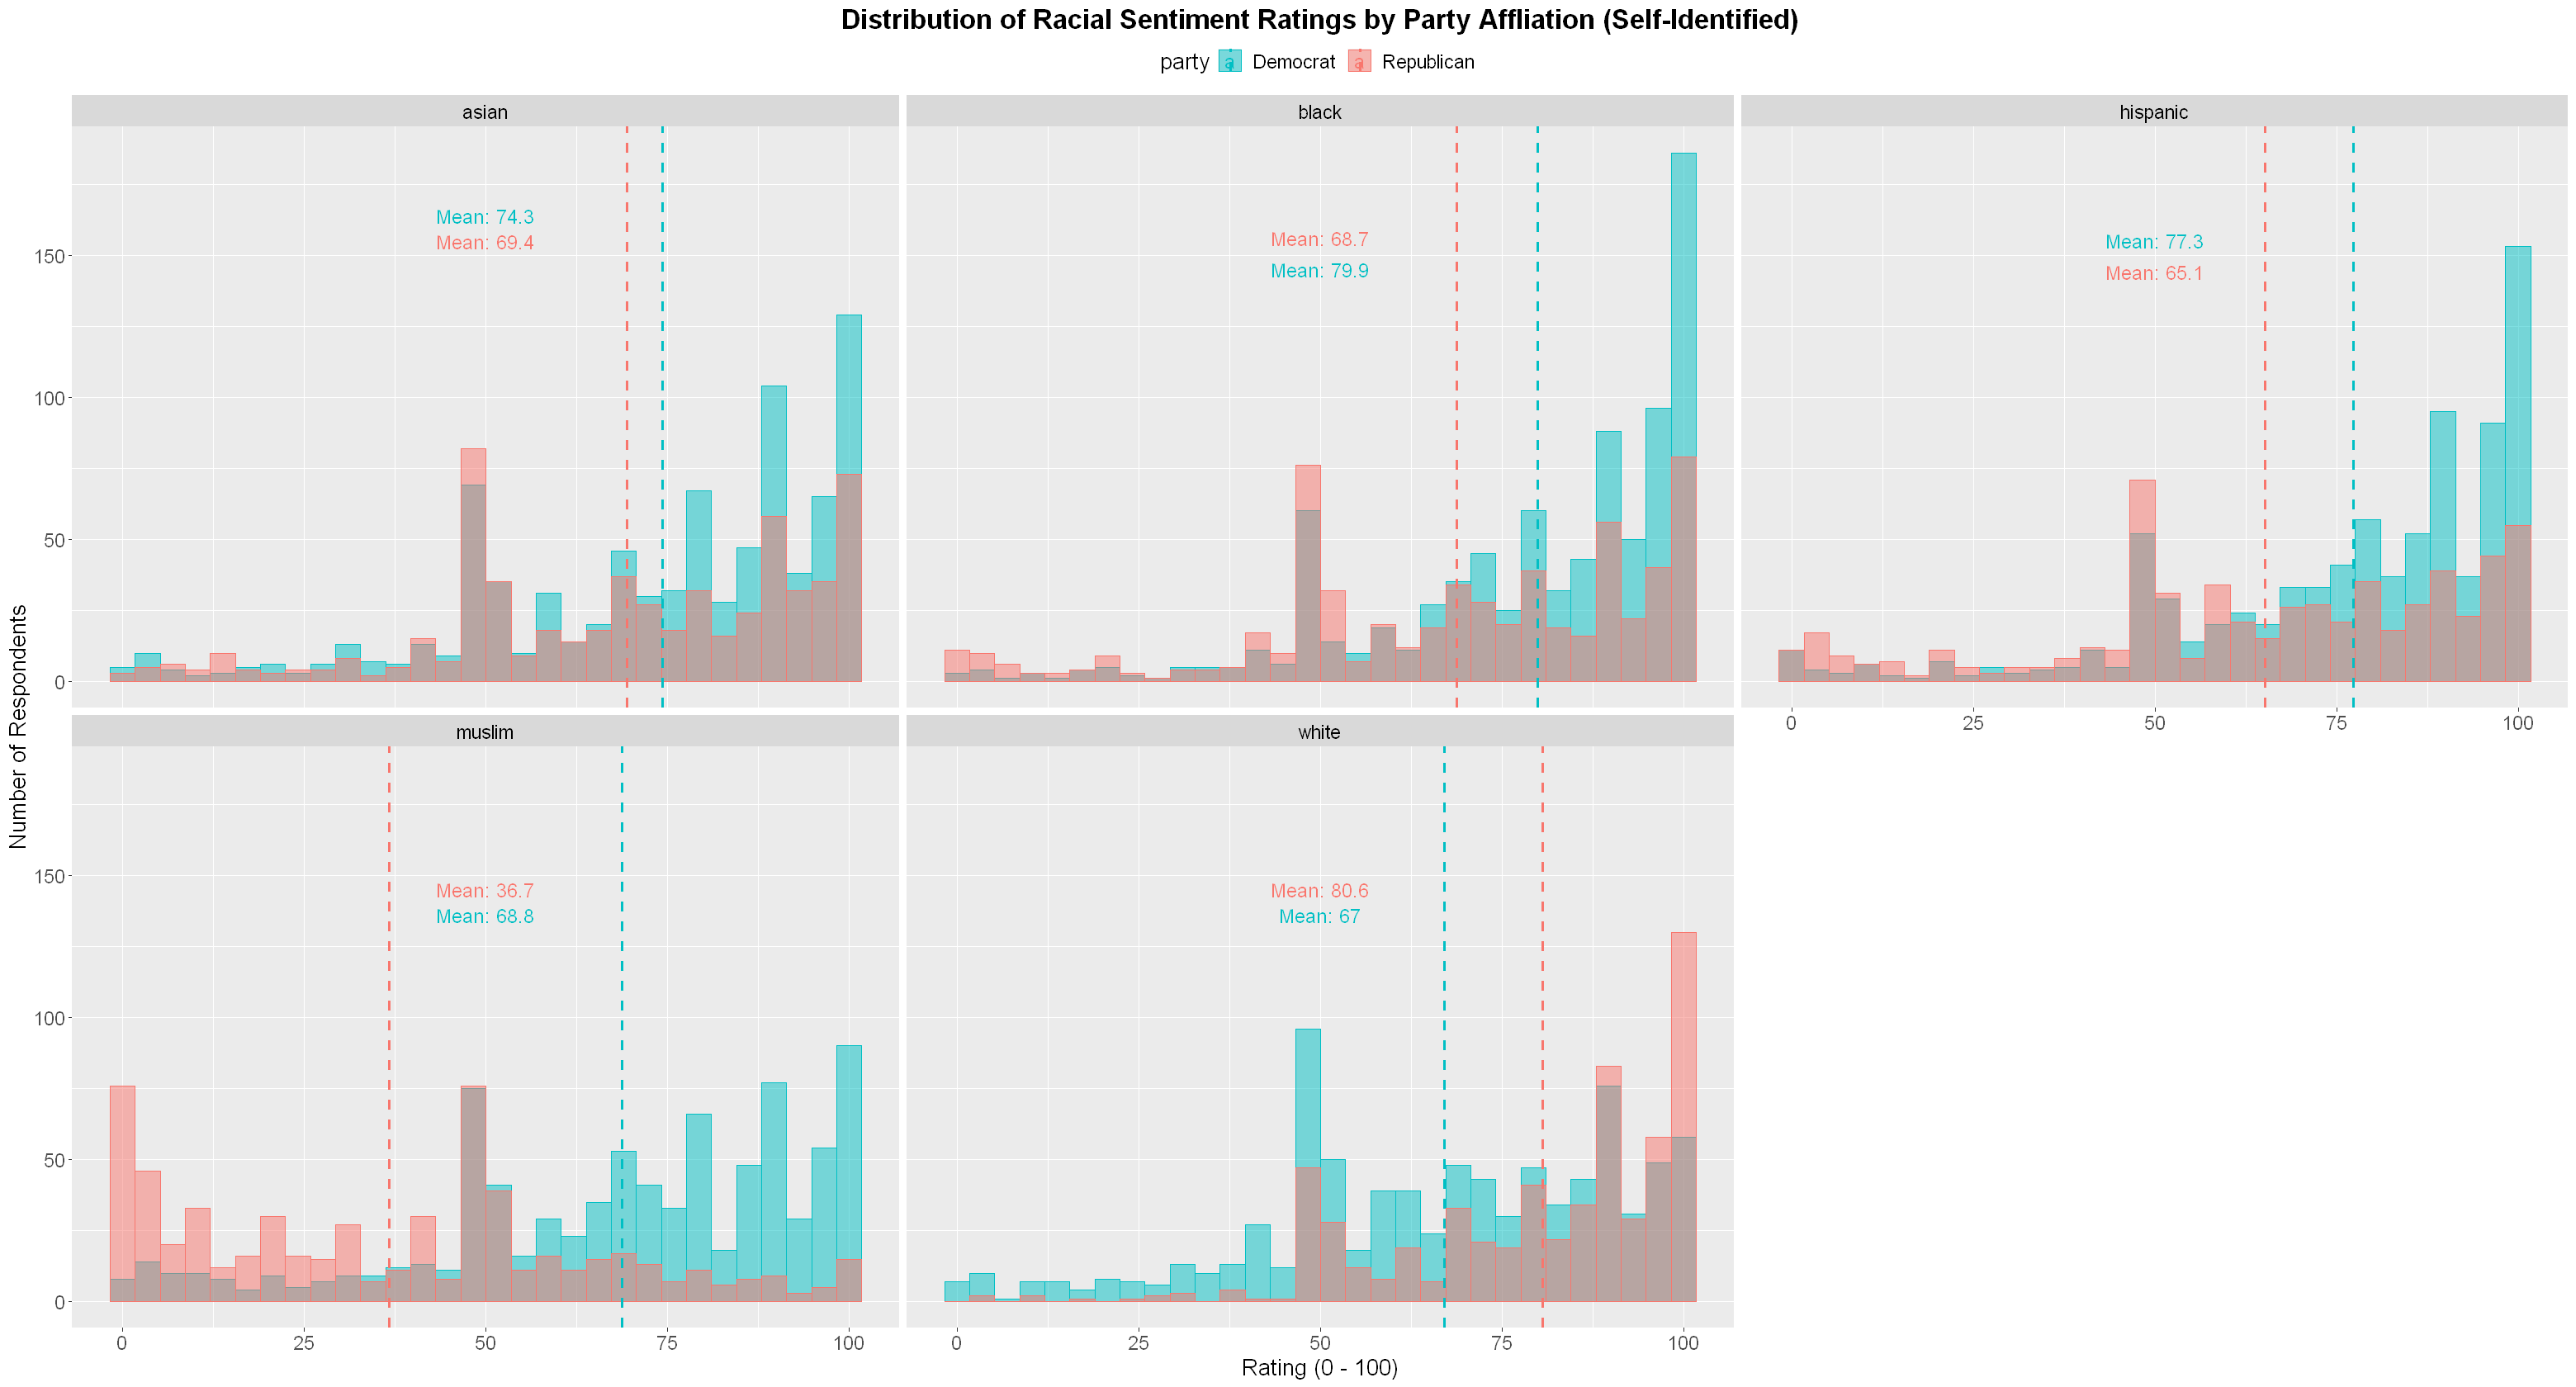

In [81]:
#facted histogram of sentiment scores towards difference race by party affliation
options(repr.plot.width = 26, repr.plot.height = 14)
race_histo = ggplot(therma_long, aes(rating, fill = party, color = party)) + 
    geom_histogram(position = "identity", alpha = .5, bins = 30) + 
    facet_wrap(.~race) + 
    geom_vline(data = sumdata, aes(xintercept = mean, color = party), linetype = "dashed", size = 1) + 
    geom_text_repel(data = sumdata, aes(label = paste("Mean:" , round(mean,1)), color = party, x = 50, y = 150), size = 5, direction = "y", segment.color = "white") + 
    labs(title = "Distribution of Racial Sentiment Ratings by Party Affliation (Self-Identified)", x = "Rating (0 - 100)", y = "Number of Respondents") +
    theme(strip.text.x = element_text(size = 14, colour = "black")) + 
    scale_fill_manual(values = c("#00BFC4", "#F8766D")) + 
    scale_color_manual(values = c("#00BFC4", "#F8766D")) +
    plot_theme

race_histo

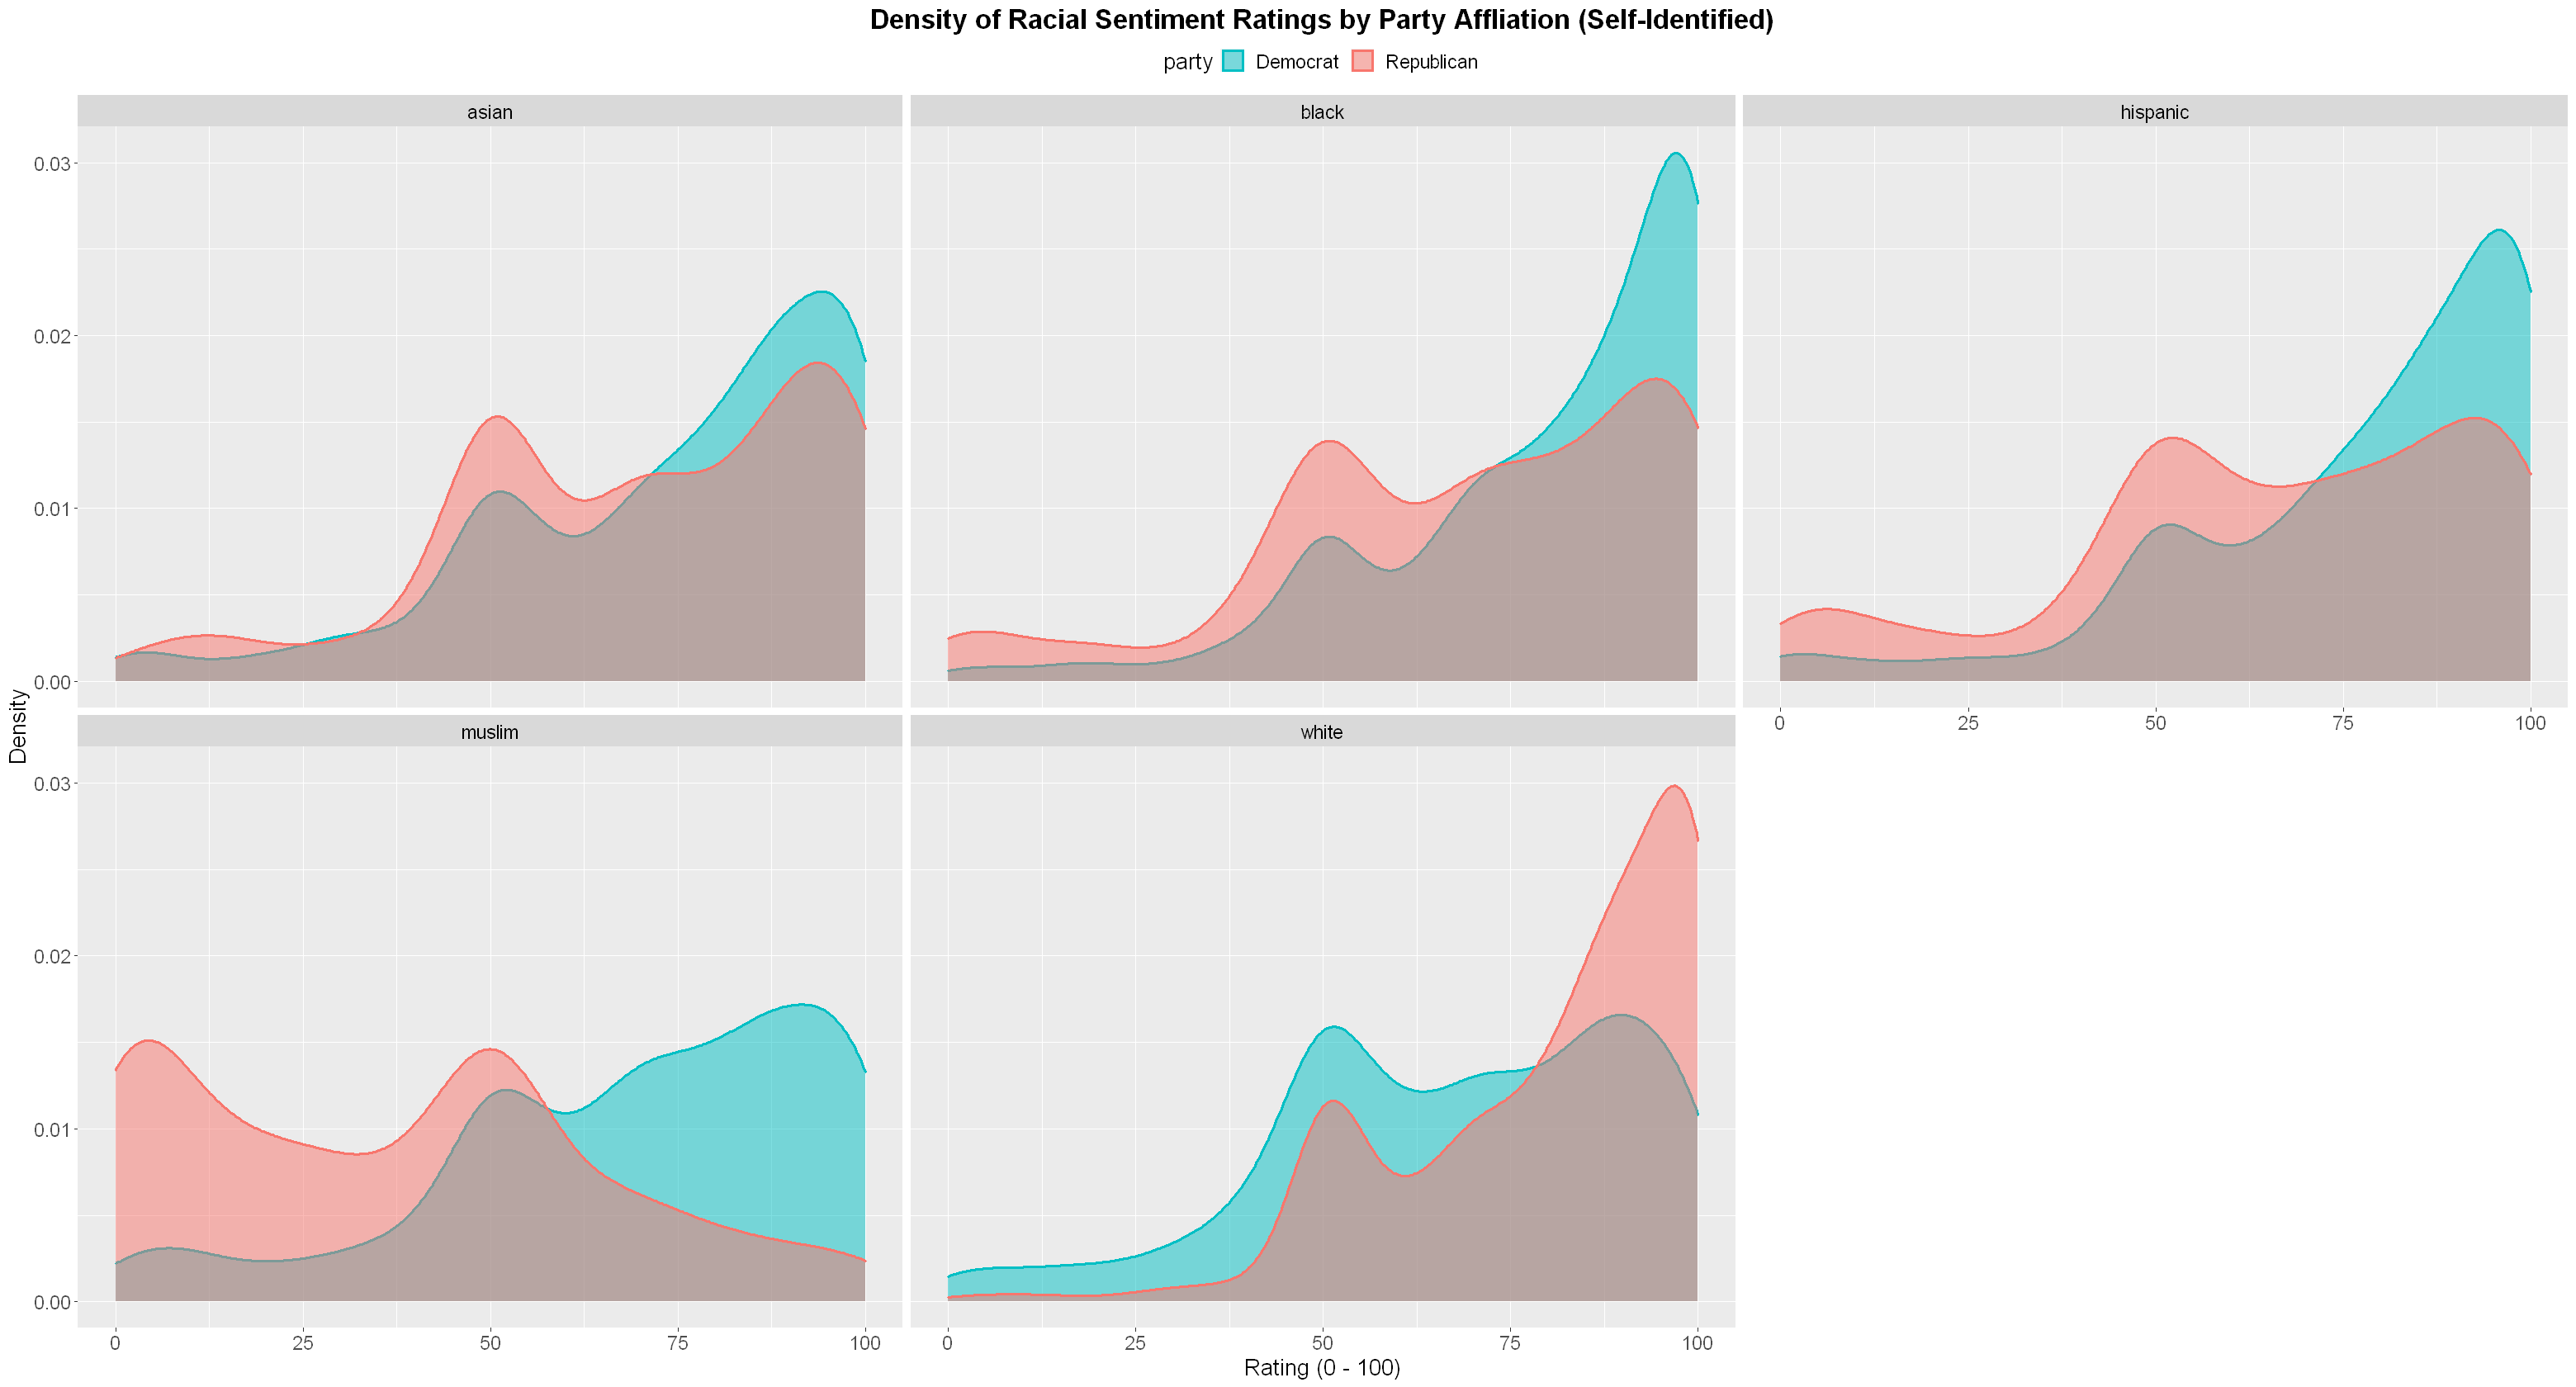

In [82]:
#facted density plot of sentiment scores towards difference race by party affliation
race_dens = ggplot(therma_long, aes(rating, fill = party, color = party)) + 
    geom_density(position = "identity", size = 1, alpha = .5) + 
    facet_wrap(.~race, nrow = 2) +
    labs(title = "Density of Racial Sentiment Ratings by Party Affliation (Self-Identified)", x = "Rating (0 - 100)", y = "Density") +
    scale_fill_manual(values = c("#00BFC4", "#F8766D")) + 
    scale_color_manual(values = c("#00BFC4", "#F8766D")) +
    theme(strip.text.x = element_text(size = 14, colour = "black")) + 
    plot_theme

race_dens

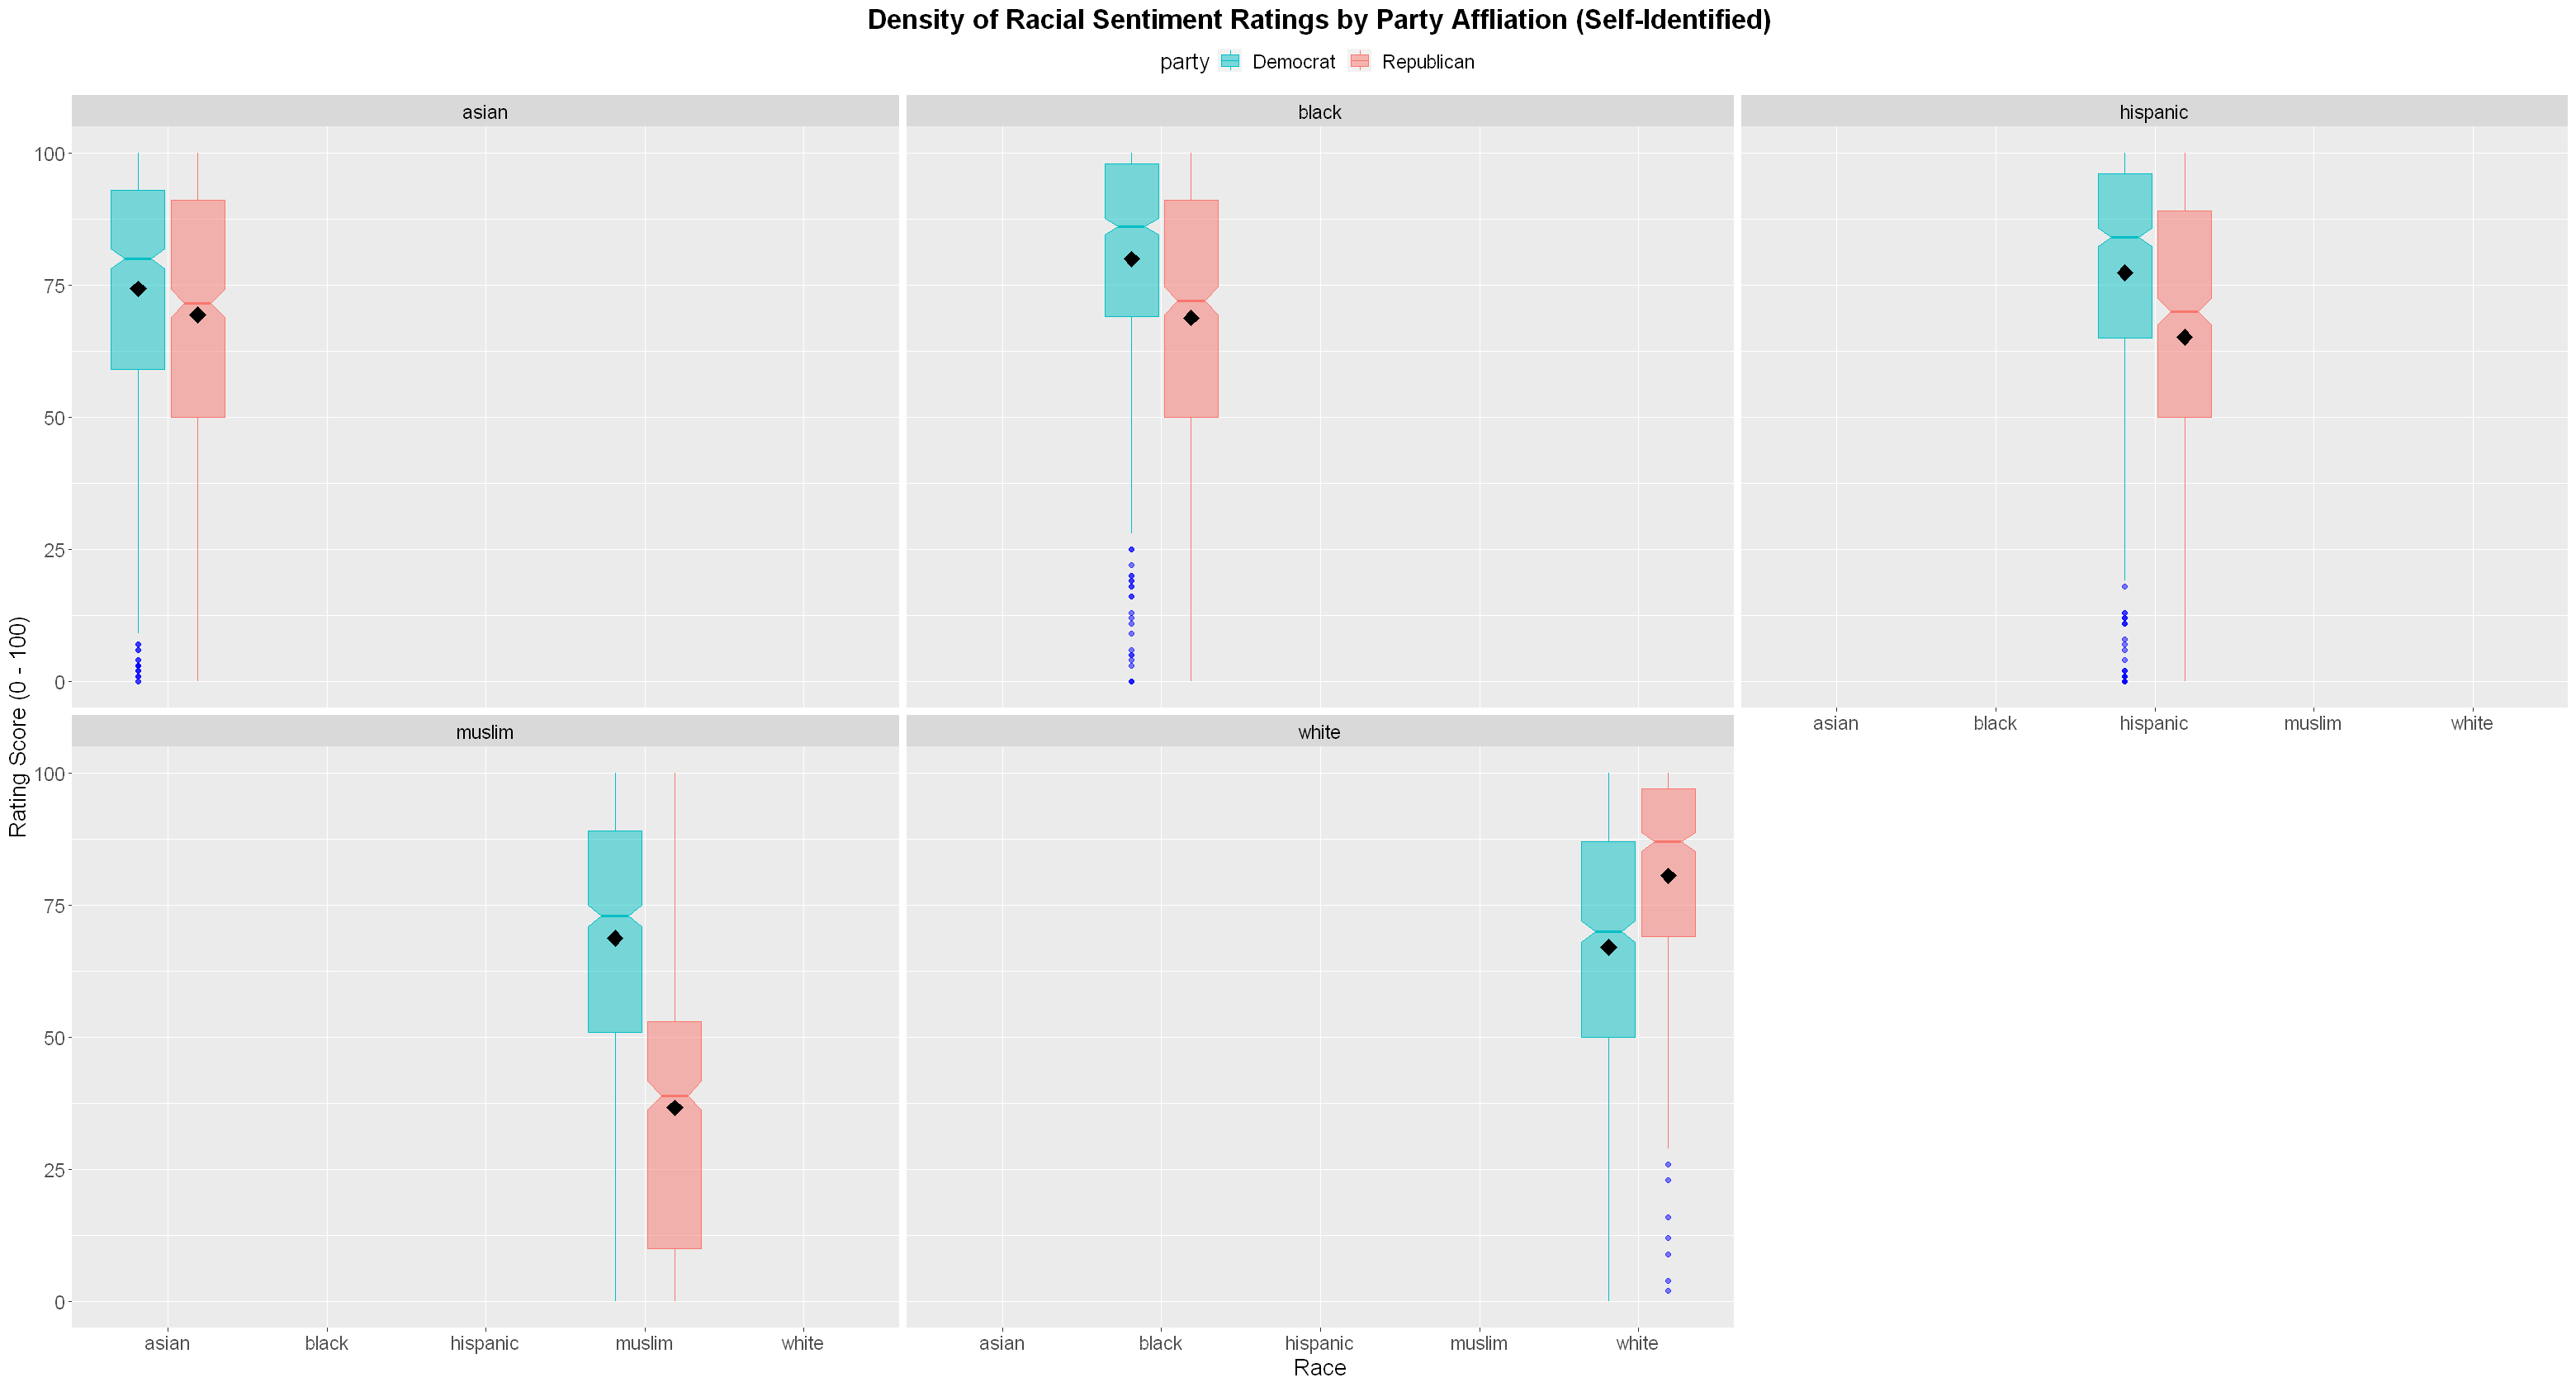

In [84]:
#facted notched box plot of sentiment scores towards difference race by party affliation
race_box = ggplot(therma_long, aes(x = race, y = rating, fill = party, color = party)) + 
    geom_boxplot(alpha = .5, outlier.color = "blue", notch = TRUE) + 
    facet_wrap(race ~., nrow = 2) +
    labs(title = "Density of Racial Sentiment Ratings by Party Affliation (Self-Identified)", x = "Race", y = "Rating Score (0 - 100)") +
    scale_fill_manual(values = c("#00BFC4", "#F8766D")) + 
    scale_color_manual(values = c("#00BFC4", "#F8766D")) +
    theme(strip.text.x = element_text(size = 14, colour = "black")) + 
    stat_summary(fun = mean, geom ="point", shape = 23, fill = "black", aes(group = party), 
                 position = position_dodge2(.75), color = "black", size = 4) +
    plot_theme

race_box

From the facted histogram and density plots and summary statistics table, we can draw several interesting conclusions just from the visual inspection:
- Self-identified Republicans rated white the highest while Democrats rated white the lowest out of the 5 races
- The largest disparity in sentiment rating between Democrats and Republicans is Muslim
- White is the only race in which Republicans had a higher mean and median sentiment score than Democrats
- Outliers in Asian, black, and Hispanic by Democrats indicate potentially dissenting views while the lack of outliers in the same set of races by Republicans indicate consistent views

### Conduct your test. (2 points)
Explain (1) the statistical significance of your result, and (2) the practical significance of your result.

### All minority races grouped together

In [85]:
#Shapiro-Wilke test to assess normality
minority = data.frame(therma_long[!(therma_long$group == "Caucasian"),])

shapiro.test(minority$rating[0:5000]) #Shapiro-Wilke test in R is limited to 5,000 sample and there are 5,861 samples


	Shapiro-Wilk normality test

data:  minority$rating[0:5000]
W = 0.89642, p-value < 2.2e-16


In [86]:
#two-sample T-test to determine if the mean difference of racial favorability score for all surveyed minority races is statistically significant between Republicans and Democrats
t.test(rating ~ party, data = minority)


	Welch Two Sample t-test

data:  rating by party
t = 20.779, df = 4455, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 13.66668 16.51426
sample estimates:
  mean in group Democrat mean in group Republican 
                75.06622                 59.97575 


In [87]:
#Cohen's d to assess practical significance
cohen.d(rating ~ party, data = minority)


Cohen's d

d estimate: 0.5726353 (medium)
95 percent confidence interval:
    lower     upper 
0.5196435 0.6256271 


### Asian specific tests

In [88]:
#Shapiro-Wilke test to assess normality
asian = data.frame(therma_long[(therma_long$race == "asian"),])

shapiro.test(asian$rating)


	Shapiro-Wilk normality test

data:  asian$rating
W = 0.90854, p-value < 2.2e-16


In [89]:
#two-sample T-test to determine if the mean difference of racial favorability towards Asians is statistically significant between Republicans and Democrats
t.test(rating ~ party, data = asian)


	Welch Two Sample t-test

data:  rating by party
t = 3.8226, df = 1269.3, p-value = 0.0001384
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 2.390679 7.431728
sample estimates:
  mean in group Democrat mean in group Republican 
                74.27305                 69.36184 


In [90]:
#Cohen's d to assess practical significance
cohen.d(rating ~ party, data = asian)


Cohen's d

d estimate: 0.204302 (small)
95 percent confidence interval:
    lower     upper 
0.1000267 0.3085774 


### Black specific tests

In [91]:
#Shapiro-Wilke test to assess normality
black = data.frame(therma_long[(therma_long$race == "black"),])

shapiro.test(black$rating)


	Shapiro-Wilk normality test

data:  black$rating
W = 0.88076, p-value < 2.2e-16


In [92]:
#two-sample T-test to determine if the mean difference of racial favorability towards blacks is statistically significant between Republicans and Democrats
t.test(rating ~ party, data = black)


	Welch Two Sample t-test

data:  rating by party
t = 8.7535, df = 1133.2, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
  8.667048 13.674906
sample estimates:
  mean in group Democrat mean in group Republican 
                79.91482                 68.74384 


In [93]:
#Cohen's d to assess practical significance
cohen.d(rating ~ party, data = black)


Cohen's d

d estimate: 0.4804505 (small)
95 percent confidence interval:
    lower     upper 
0.3750415 0.5858595 


### Hispanic specific tests

In [94]:
#Shapiro-Wilke test to assess normality
hispanic = data.frame(therma_long[(therma_long$race == "hispanic"),])

shapiro.test(hispanic$rating)


	Shapiro-Wilk normality test

data:  hispanic$rating
W = 0.89001, p-value < 2.2e-16


In [95]:
#two-sample T-test to determine if the mean difference of racial favorability towards Hispanics is statistically significant between Republicans and Democrats
t.test(rating ~ party, data = hispanic)


	Welch Two Sample t-test

data:  rating by party
t = 8.9972, df = 1154.1, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
  9.527416 14.841569
sample estimates:
  mean in group Democrat mean in group Republican 
                77.30805                 65.12356 


In [96]:
#Cohen's d to assess practical significance
cohen.d(rating ~ party, data = hispanic)


Cohen's d

d estimate: 0.491993 (small)
95 percent confidence interval:
    lower     upper 
0.3864133 0.5975727 


### Muslim specific tests

In [97]:
#Shapiro-Wilke test to assess normality
muslim = data.frame(therma_long[(therma_long$race == "muslim"),])

shapiro.test(muslim$rating)


	Shapiro-Wilk normality test

data:  muslim$rating
W = 0.93851, p-value < 2.2e-16


In [98]:
#two-sample T-test to determine if the mean difference of racial favorability towards Muslims is statistically significant between Republicans and Democrats
t.test(rating ~ party, data = muslim)


	Welch Two Sample t-test

data:  rating by party
t = 22.414, df = 1223.7, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 29.25635 34.86942
sample estimates:
  mean in group Democrat mean in group Republican 
                68.76896                 36.70608 


In [99]:
#Cohen's d to assess practical significance
cohen.d(rating ~ party, data = muslim)


Cohen's d

d estimate: 1.208754 (large)
95 percent confidence interval:
   lower    upper 
1.095946 1.321562 


### Conclusion (3 points)

If we bundle all of the surveyed minorities' (Asian, black, Hispanic, Muslim) favorability scores into a single group, we can conclude that there is a statistically significant (at 1% level) difference in the mean sentiment between self-identified Republicans and Democrats towards non-Caucasians. Additionally, the difference is moderately high, which is enough for us and policy makers to take into consideration. Moreover, if we were to repeat this study numerous times, we are 95% confident that the true difference in mean sentiment score between Democrats and Republicans is between 13.7 and 16.5. Democrats tend to rate non-Caucasians 13.7 to 16.5 points higher than Republicans on average. 

When we performed the same analysis by examining the sentiment score of each race separately, we found all of the race specific tests to be statistically signifiant, but the largest disparity of racial favorability score were among Muslims. Specifically, we can be 95% confident that Democrats will rate Muslims between 29 - 35 points higher than Republicans on average. The smallest difference were among Asians while Hispanics and blacks observed similar differences among Republican and Democratic respondents.

|   Race   | Statistically Significant? |   Effect Size  | 95% Confidence Interval |
|:--------:|:--------------------------:|:--------------:|:-----------------------:|
|   Asian  |             Yes            |      Small     |        2.4 - 7.4        |
|   Black  |             Yes            |      Small     |        8.7 - 13.7       |
| Hispanic |             Yes            | Small - Medium |        9.5 - 14.8       |
|  Muslim  |             Yes            |      Large     |       29.3 - 34.9       |

In conclusion, not only is there a difference in racial sentiment/favorability between self-identified Republicans and Democrats towards all minority groups that were part of the survey, but there also seems to be an underlying pattern in Republican idealogy and belief system that influences the perception of whites to be more favorable than non-whites in which results in a consistently lower racial sentiment score of non-Caucasians when compared to Democrats. 